In [1]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos
from climpyrical.mask import gen_raster_mask_from_vector
import climpyrical.spytialProcess as sp
from climpyrical.rkrig import krigit_north

from pkg_resources import resource_filename


from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib


from pykrige.ok import OrdinaryKriging

importr("fields")
font = {'weight' : 'bold',
        'size'   : 15}
%load_ext autoreload
%autoreload 2

R[write to console]: Installing package into ‘/home/nannau/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/fields_11.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3280216 bytes (3.1 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to

In [2]:
OLD_PATH = resource_filename(
    'climpyrical',
    'nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
)

# dsold = xr.open_dataset('/home/nannau/nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc')
dsold = xr.open_dataset(OLD_PATH)
dsold_max = dsold.rlat.values.max()

DS_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/pre_processed.nc'
)

MASK_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/canada_mask_rp.nc'
)

ds = xr.open_dataset(DS_PATH)
mask = xr.open_dataset(MASK_PATH)['mask'].values

In [3]:
# station_dv = 'RL50 (kPa)'
# dv = 'Rain-RL50'

# station_dv = 'HDD (degC-day)'
# dv = 'heating_degree_days_per_time_period'

# station_dv = 'SL50 (kPa)'
# dv = 'snw'

# station_dv = 'TJan1.0 (degC)'
# dv = 'tas'

station_dv = 'TJan2.5 (degC)'
dv = 'tas'

df_path = resource_filename('climpyrical', 'nrc_data/processed/processed_station.csv')

df = pd.read_csv(df_path)
df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

# df = df.assign(station_dv = df[station_dv] + 273.15)

# df = df[df[station_dv] != 0.0]

In [4]:
df

,Unnamed: 0,ilocy,ilocx,TJan2.5 (degC),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,0,552,1011,257.35,-4.517790,10.457750,42.03330,-82.90000,HARROW CDA AUTO,0.984641,262.315497,1.00364
1,1,552,1017,257.15,-4.549355,10.752628,41.94860,-82.51890,POINT PELEE CS,0.966329,267.078832,1.00364
2,2,558,1009,256.55,-4.286849,10.373390,42.27560,-82.95560,WINDSOR A,0.997070,258.240339,1.00364
3,3,560,1026,258.15,-4.166610,11.147744,42.25010,-81.90010,ERIEAU (AUT),0.980031,264.368823,1.00364
4,4,565,1026,253.85,-3.968063,11.121350,42.45000,-81.88330,RIDGETOWN RCS,0.975062,261.290093,1.00364
...,...,...,...,...,...,...,...,...,...,...,...,...
492,492,1240,915,233.05,25.955689,6.197115,72.69330,-77.95750,POND INLET CLIMATE,1.013085,230.877232,1.00364
493,493,1246,562,235.15,26.214276,-9.387969,71.99250,-125.25400,SACHS HARBOUR CLIMATE,1.024517,230.358237,1.00364
494,494,1269,788,233.05,27.224160,0.599798,74.71635,-94.97625,RESOLUTE CARS,1.033713,226.270033,1.00364
495,495,1315,859,234.25,29.264606,3.758251,76.42280,-82.90220,GRISE FIORD CLIMATE,1.065369,220.677166,1.00364


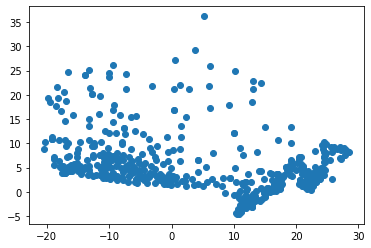

In [5]:
import matplotlib.pyplot as plt
plt.scatter(df.rlon, df.rlat)
plt.show()

In [6]:
# df = df[df.ratio < 3]

df_north = df[df.rlat > dsold_max].copy()
# df_no_zero = df[df[station_dv] != 0.0]
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

# df

# Krig the station only values in the north

In [7]:
# X_n_d =  np.stack([np.deg2rad(df.lat), np.deg2rad(df.lon)]).T
# X_n_d_r = np.stack([df.rlon, df.rlat]).T

# print(X_n_d, "\n", np.fliplr(X_n_d))
# nbrs = NearestNeighbors(n_neighbors=20, metric='haversine').fit(X_n_d)
# dist, ind = nbrs.kneighbors(X_n_d)
# imax = df.rlat.idxmax(axis=0, skipna=True)
# temp_df = df.iloc[ind[imax]]

# xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
# ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

# latlon = np.stack([temp_df.rlon, temp_df.rlat])
# stats = temp_df[station_dv]

# lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
# l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)
# ylim = u-lw
# xlim = r-l    

# z, x, y = sp.fit(latlon, stats, xlim, ylim, extrap=True)

# final = ds[dv].values.copy()
# final[:, :] = np.nan
# final[lw:u, l:r] = z.T

# nanmask = ~np.isnan(final)

# station_final_north = final.copy()

station_final_north = krigit_north(df, station_dv, 20, ds)

 [1]  114.8198  152.7018  203.0820  270.0839  359.1914  477.6978  635.3025
 [8]  844.9049 1123.6606 1494.3848
 [1] -43.98810 -43.37394 -43.01945 -42.95267 -43.11655 -43.42170 -43.76997
 [8] -44.11534 -44.44466 -44.75078


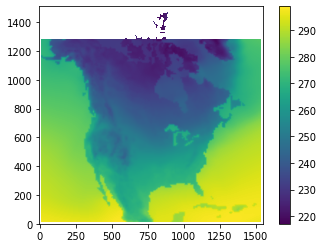

In [8]:
fig, ax = plt.subplots()
col = ax.imshow(ds[dv].values, origin='lower')
plt.colorbar(col)

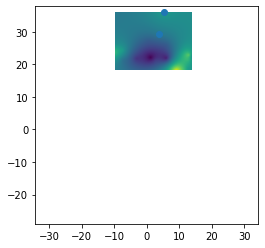

In [9]:
extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]
plt.imshow(station_final_north, extent=extent, origin = 'lower')
plt.scatter(df_north.rlon, df_north.rlat)

<AxesSubplot:>

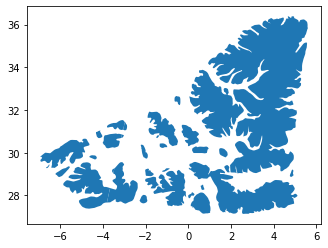

In [10]:
canada = gpd.read_file('./data/processed/canada_final.shp').geometry
def to_polygons(geometries):
    for geometry in geometries:
        if isinstance(geometry, Polygon):
            yield geometry
        else:
            yield from geometry

canada_polygons = MultiPolygon(to_polygons(canada))

polygon_above_north_idx = np.array(
    [p.centroid.y + 1 >= dsold_max for p in canada]
)

M2 = gpd.GeoSeries(
    MultiPolygon(
        [P for P in canada_polygons if (P.is_valid and P.centroid.y + 1 >= dsold_max)]
    )
)
M2.plot()

100%|██████████| 59147/59147 [00:07<00:00, 7563.00it/s]


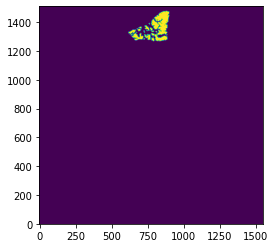

In [11]:
northern_mask = np.zeros(ds[dv].shape) == 1.0
north_ext = 210
northern_mask[-(north_ext+50):, :] = gen_raster_mask_from_vector(
    ds.rlon.values, 
    ds.rlat.values[-(north_ext+50):], 
    M2
)

station_final_north[~northern_mask] = np.nan
plt.imshow(northern_mask, origin='lower')

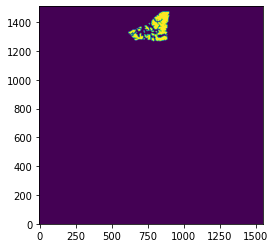

In [12]:
plt.imshow(~np.isnan(station_final_north), origin='lower')

## Find areas in north that are not covered by station only reconstruction

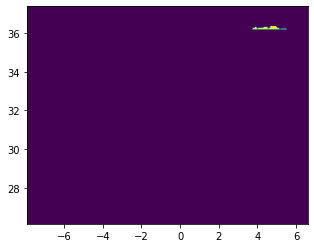

In [13]:
north_nan = ~np.isnan(station_final_north)
missed_station_only = (northern_mask^north_nan)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]

plt.imshow(missed_station_only, origin='lower', extent=extent)
plt.gca().set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
plt.gca().set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.show()

# station_final_north[~northern_mask] = np.nan

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])

station_final_north_filled = station_final_north.copy()
station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)

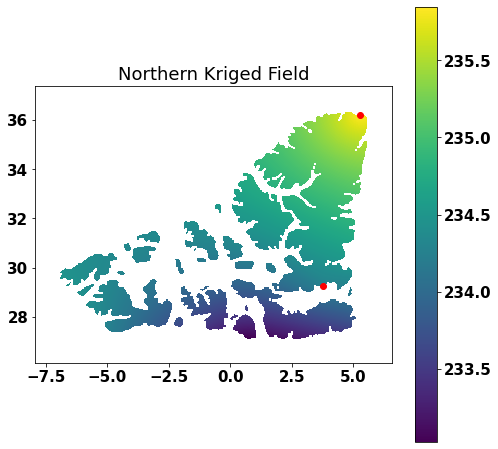

In [66]:
matplotlib.rc('font', **font)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(station_final_north_filled, origin='lower', extent = extent)
plt.scatter(df_north.rlon, df_north.rlat, color='r')
ax.set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
ax.set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.colorbar(img)
plt.title("Northern Kriged Field")
plt.savefig("northern_krig")

In [15]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

df['ilocy'] = iy 
df['ilocx'] = ix

In [16]:
# choose starting value
model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
station_vals = df[station_dv]
best_tol = df.best_tol.mean()    

print(best_tol)

# apply correction
model_vals_corrected = model_vals/best_tol
mean_corrected = ds[dv].values/best_tol

mean_corrected

1.0036396586208232


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [17]:
# latlon = np.stack([df.rlon, df.rlat])
# hull = ConvexHull(points=latlon.T)
# poly = Polygon(latlon.T[hull.vertices])
# poly_mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values[l:r], gpd.GeoSeries(poly), progress_bar=False)
# plt.imshow(poly_mask)

In [18]:
# ok = OrdinaryKriging(
#     df.rlon, 
#     df.rlat, 
#     df.ratio, 
#     exact_values=False,
#     variogram_function='exponential',
# )
# z, ss = ok.execute("grid", ds.rlon.values, ds.rlat.values, backend='C', n_closest_points=30)

In [19]:
# plt.imshow(z, origin='lower')

In [20]:
df[['rlon', 'rlat', 'ratio']].values[:, :2]

import rpy2

In [22]:
from climpyrical.rkrig import rkrig_r

Zl = rkrig_r(df, 30, ds)

  0%|          | 0/497 [00:00<?, ?it/s]

 [1]  12.01566  16.69178  23.18770  32.21163  44.74740  62.16170  86.35310
 [8] 119.95905 166.64339 231.49582
 [1] 97.58633 97.77444 97.92785 97.98209 97.88876 97.64750 97.28480 96.83156
 [9] 96.32082 95.79813


  0%|          | 2/497 [00:00<01:37,  5.07it/s]

 [1]  12.01566  16.58777  22.89965  31.61327  43.64254  60.24912  83.17472
 [8] 114.82382 158.51583 218.83323
 [1] 96.49997 96.85914 97.21035 97.44682 97.50302 97.38308 97.12000 96.74195
 [9] 96.26494 95.70466


  1%|          | 3/497 [00:00<02:04,  3.95it/s]

 [1]  12.01566  16.69178  23.18770  32.21163  44.74740  62.16170  86.35310
 [8] 119.95905 166.64339 231.49582
 [1] 97.58633 97.77444 97.92785 97.98209 97.88876 97.64750 97.28480 96.83156
 [9] 96.32082 95.79813


  1%|          | 4/497 [00:01<02:23,  3.44it/s]

 [1]  12.01566  16.58777  22.89965  31.61327  43.64254  60.24912  83.17472
 [8] 114.82382 158.51583 218.83323
 [1] 96.49997 96.85914 97.21035 97.44682 97.50302 97.38308 97.12000 96.74195
 [9] 96.26494 95.70466


  1%|          | 5/497 [00:01<02:36,  3.14it/s]

 [1]  12.01566  16.58777  22.89965  31.61327  43.64254  60.24912  83.17472
 [8] 114.82382 158.51583 218.83323
 [1] 96.49997 96.85914 97.21035 97.44682 97.50302 97.38308 97.12000 96.74195
 [9] 96.26494 95.70466


  1%|          | 6/497 [00:01<02:44,  2.99it/s]

 [1]  12.01566  16.58870  22.90220  31.61856  43.65228  60.26592  83.20255
 [8] 114.86865 158.58656 218.94309
 [1] 97.64179 97.79633 97.89660 97.88809 97.73973 97.46040 97.07631 96.61675
 [9] 96.11781 95.62997


  1%|▏         | 7/497 [00:02<02:49,  2.88it/s]

 [1]  12.01566  16.62177  22.99360  31.80802  44.00139  60.86899  84.20266
 [8] 116.48111 161.13328 222.90251
 [1] 100.67960 100.87135 100.87021 100.68126 100.36709  99.99266  99.59885
 [8]  99.20813  98.83466  98.48872


  2%|▏         | 8/497 [00:02<02:54,  2.80it/s]

 [1]  12.01566  16.58777  22.89965  31.61327  43.64254  60.24912  83.17472
 [8] 114.82382 158.51583 218.83323
 [1] 96.49997 96.85914 97.21035 97.44682 97.50302 97.38308 97.12000 96.74195
 [9] 96.26494 95.70466


  2%|▏         | 9/497 [00:03<02:58,  2.74it/s]

 [1]  12.01566  16.57687  22.86954  31.55095  43.52787  60.05130  82.84711
 [8] 114.29635 157.68389 217.54160
 [1] 96.79952 97.58743 98.15428 98.43811 98.46497 98.30413 98.02587 97.68282
 [9] 97.30795 96.91692


  2%|▏         | 10/497 [00:03<02:59,  2.71it/s]

 [1]  12.01566  16.57687  22.86954  31.55095  43.52787  60.05130  82.84711
 [8] 114.29635 157.68389 217.54160
 [1] 96.79952 97.58743 98.15428 98.43811 98.46497 98.30413 98.02587 97.68282
 [9] 97.30795 96.91692


  2%|▏         | 11/497 [00:03<02:59,  2.70it/s]

 [1]  12.01566  16.57687  22.86954  31.55095  43.52787  60.05130  82.84711
 [8] 114.29635 157.68389 217.54160
 [1] 96.79952 97.58743 98.15428 98.43811 98.46497 98.30413 98.02587 97.68282
 [9] 97.30795 96.91692


  2%|▏         | 12/497 [00:04<03:01,  2.67it/s]

 [1]  12.01566  16.50954  22.68416  31.16810  42.82506  58.84176  80.84874
 [8] 111.08640 152.63303 209.71822
 [1] 103.9046 104.2620 104.3867 104.2807 104.0125 103.6597 103.2781 102.8987
 [9] 102.5358 102.1928


  3%|▎         | 13/497 [00:04<02:59,  2.69it/s]

 [1]  12.01566  16.57687  22.86954  31.55095  43.52787  60.05130  82.84711
 [8] 114.29635 157.68389 217.54160
 [1] 96.79952 97.58743 98.15428 98.43811 98.46497 98.30413 98.02587 97.68282
 [9] 97.30795 96.91692


  3%|▎         | 14/497 [00:04<02:59,  2.69it/s]

 [1]  12.01566  16.57687  22.86954  31.55095  43.52787  60.05130  82.84711
 [8] 114.29635 157.68389 217.54160
 [1] 96.79952 97.58743 98.15428 98.43811 98.46497 98.30413 98.02587 97.68282
 [9] 97.30795 96.91692


  3%|▎         | 15/497 [00:05<03:00,  2.67it/s]

 [1]  12.01566  16.51166  22.68998  31.18009  42.84702  58.87947  80.91093
 [8] 111.18609 152.78958 209.96023
 [1] 96.90486 97.35714 97.60563 97.59532 97.37504 97.04088 96.67142 96.30637
 [9] 95.95844 95.62938


  3%|▎         | 16/497 [00:05<03:00,  2.67it/s]

 [1]  12.01566  16.58870  22.90220  31.61856  43.65228  60.26592  83.20255
 [8] 114.86865 158.58656 218.94309
 [1] 97.64179 97.79633 97.89660 97.88809 97.73973 97.46040 97.07631 96.61675
 [9] 96.11781 95.62997


  3%|▎         | 17/497 [00:06<02:59,  2.68it/s]

 [1]  12.01566  16.44065  22.49524  30.77955  42.11471  57.62426  78.84551
 [8] 107.88189 147.61148 201.97225
 [1]  99.97385 100.31786 100.59470 100.72747 100.67961 100.46817 100.13580
 [8]  99.72258  99.25639  98.75895


  4%|▎         | 18/497 [00:06<02:57,  2.69it/s]

 [1]  12.01566  16.26734  22.02347  29.81639  40.36679  54.65040  73.98821
 [8] 100.16862 135.61286 183.59889
 [1] 100.64628 100.87387 100.97117 100.91423 100.73008 100.46634 100.16432
 [8]  99.85035  99.53831  99.23456


  4%|▍         | 19/497 [00:06<02:59,  2.66it/s]

 [1]  12.01566  16.26734  22.02347  29.81639  40.36679  54.65040  73.98821
 [8] 100.16862 135.61286 183.59889
 [1] 100.64628 100.87387 100.97117 100.91423 100.73008 100.46634 100.16432
 [8]  99.85035  99.53831  99.23456


  4%|▍         | 20/497 [00:07<02:58,  2.67it/s]

 [1]  12.01566  16.44287  22.50131  30.79201  42.13745  57.66315  78.90937
 [8] 107.98384 147.77091 202.21768
 [1] 97.11639 97.69334 98.14828 98.40606 98.46094 98.35543 98.14327 97.86772
 [9] 97.55662 97.22359


  4%|▍         | 21/497 [00:07<02:58,  2.67it/s]

 [1]  12.01566  16.26734  22.02347  29.81639  40.36679  54.65040  73.98821
 [8] 100.16862 135.61286 183.59889
 [1] 100.64628 100.87387 100.97117 100.91423 100.73008 100.46634 100.16432
 [8]  99.85035  99.53831  99.23456


  4%|▍         | 22/497 [00:07<02:56,  2.69it/s]

 [1]  12.01566  16.44065  22.49524  30.77955  42.11471  57.62426  78.84551
 [8] 107.88189 147.61148 201.97225
 [1]  99.97385 100.31786 100.59470 100.72747 100.67961 100.46817 100.13580
 [8]  99.72258  99.25639  98.75895


  5%|▍         | 23/497 [00:08<02:55,  2.70it/s]

 [1]  12.01566  16.26734  22.02347  29.81639  40.36679  54.65040  73.98821
 [8] 100.16862 135.61286 183.59889
 [1] 100.64628 100.87387 100.97117 100.91423 100.73008 100.46634 100.16432
 [8]  99.85035  99.53831  99.23456


  5%|▍         | 24/497 [00:08<02:55,  2.70it/s]

 [1]  12.01566  16.28304  22.06598  29.90276  40.52277  54.91451  74.41749
 [8] 100.84699 136.66297 185.19906
 [1] 102.5263 102.7803 102.9795 103.0391 102.9355 102.7016 102.3880 102.0366
 [9] 101.6744 101.3170


  5%|▌         | 25/497 [00:09<02:55,  2.69it/s]

 [1]  12.01566  16.56721  22.84291  31.49586  43.42656  59.87664  82.55805
 [8] 113.83123 156.95075 216.40406
 [1]  99.62151  99.94551 100.09292 100.00797  99.71955  99.29936  98.81815
 [8]  98.32666  97.85496  97.42055


  5%|▌         | 26/497 [00:09<02:54,  2.69it/s]

 [1]  11.43177  16.08918  22.64405  31.86944  44.85333  63.12697  88.84546
 [8] 125.04189 175.98507 247.68296
 [1]  97.97647  98.87034  99.65341 100.11902 100.23944 100.10975  99.84014
 [8]  99.50584  99.14507  98.76623


  5%|▌         | 27/497 [00:09<02:55,  2.68it/s]

 [1]  12.01566  16.44375  22.50372  30.79696  42.14647  57.67860  78.93473
 [8] 108.02433 147.83424 202.31519
 [1] 102.8121 102.9382 102.9484 102.7769 102.4402 102.0114 101.5681 101.1658
 [9] 100.8331 100.5775


  6%|▌         | 28/497 [00:10<02:55,  2.67it/s]

 [1]  11.43177  16.01421  22.43352  31.42603  44.02318  61.66992  86.39038
 [8] 121.02006 169.53109 237.48782
 [1]  98.42020  99.16330  99.78516 100.13466 100.19778 100.05087  99.78182
 [8]  99.45240  99.09461  98.71455


  6%|▌         | 29/497 [00:10<02:55,  2.67it/s]

 [1]  12.25135  17.00819  23.61197  32.77980  45.50722  63.17633  87.70583
 [8] 121.75941 169.03499 234.66628
 [1] 96.51872 96.82412 97.25067 97.67213 97.91239 97.88746 97.60725 97.10908
 [9] 96.43317 95.65172


  6%|▌         | 30/497 [00:10<02:56,  2.65it/s]

 [1]  12.01566  16.28306  22.06606  29.90290  40.52304  54.91495  74.41822
 [8] 100.84814 136.66476 185.20179
 [1] 95.23616 95.73158 96.24428 96.65215 96.87731 96.90895 96.77712 96.52255
 [9] 96.17908 95.76729


  6%|▌         | 31/497 [00:11<02:56,  2.64it/s]

 [1]  12.01566  16.60016  22.93387  31.68416  43.77308  60.47446  83.54817
 [8] 115.42552 159.46550 220.30870
 [1] 100.91738 101.14710 101.21778 101.09740 100.82722 100.47285 100.08765
 [8]  99.70451  99.34065  99.00469


  6%|▋         | 32/497 [00:11<02:56,  2.64it/s]

 [1]  12.01566  16.47461  22.58827  30.97068  42.46376  58.22188  79.82776
 [8] 109.45150 150.06847 205.75823
 [1] 93.82834 94.33287 94.87463 95.30540 95.52339 95.51921 95.33903 95.03718
 [9] 94.65200 94.20052


  7%|▋         | 33/497 [00:12<02:55,  2.64it/s]

 [1]  15.18729  21.14975  29.45303  41.01613  57.11886  79.54343 110.77176
 [8] 154.26019 214.82195 299.15994
 [1] 100.9811 101.8076 102.3628 102.5451 102.4155 102.0964 101.6885 101.2505
 [9] 100.8050 100.3473


  7%|▋         | 34/497 [00:12<02:55,  2.64it/s]

 [1]  13.17588  18.57006  26.17261  36.88763  51.98936  73.27371 103.27185
 [8] 145.55116 205.13956 289.12335
 [1] 94.96400 95.64628 96.50476 97.26091 97.67473 97.69613 97.38383 96.80438
 [9] 96.00850 95.06481


  7%|▋         | 35/497 [00:12<02:56,  2.62it/s]

 [1]  13.32952  18.58283  25.90653  36.11659  50.35054  70.19425  97.85859
 [8] 136.42576 190.19267 265.14973
 [1] 102.84845 103.21340 103.25584 102.94461 102.37303 101.66340 100.91027
 [8] 100.18284  99.54533  99.05943


  7%|▋         | 36/497 [00:13<02:55,  2.63it/s]

 [1]  12.25135  16.92890  23.39233  32.32349  44.66455  61.71741  85.28102
 [8] 117.84119 162.83279 225.00210
 [1] 95.60872 96.57647 97.70001 98.70121 99.38937 99.74585 99.84634 99.77675
 [9] 99.57704 99.20864


  7%|▋         | 37/497 [00:13<02:54,  2.64it/s]

 [1]  13.17588  18.13556  24.96217  34.35846  47.29172  65.09334  89.59586
 [8] 123.32166 169.74257 233.63730
 [1] 93.70243 94.71785 95.93572 97.07392 97.91166 98.39937 98.59755 98.59112
 [9] 98.42998 98.09281


  8%|▊         | 38/497 [00:13<02:53,  2.64it/s]

 [1]  13.32952  18.58283  25.90653  36.11659  50.35054  70.19425  97.85859
 [8] 136.42576 190.19267 265.14973
 [1] 102.84845 103.21340 103.25584 102.94461 102.37303 101.66340 100.91027
 [8] 100.18284  99.54533  99.05943


  8%|▊         | 39/497 [00:14<02:53,  2.64it/s]

 [1]  15.18729  20.63152  28.02734  38.07437  51.72298  70.26424  95.45202
 [8] 129.66893 176.15165 239.29714
 [1] 100.34723 101.11161 101.67913 101.93487 101.88882 101.62415 101.23184
 [8] 100.77725 100.29416  99.79001


  8%|▊         | 40/497 [00:14<02:53,  2.64it/s]

 [1]  16.78816  23.58789  33.14172  46.56516  65.42551  91.92489 129.15736
 [8] 181.47013 254.97123 358.24257
 [1] 95.34780 96.36836 97.54886 98.46017 98.87152 98.80396 98.37668 97.70525
 [9] 96.88509 96.00168


  8%|▊         | 41/497 [00:15<02:57,  2.57it/s]

 [1]  16.26163  22.67985  31.63123  44.11558  61.52732  85.81119 119.67953
 [8] 166.91518 232.79401 324.67419
 [1] 95.22663 96.17952 97.17523 97.89523 98.20971 98.17099 97.88708 97.42812
 [9] 96.80354 96.00560


  8%|▊         | 42/497 [00:15<02:59,  2.53it/s]

 [1]  13.32952  18.49994  25.67592  35.63541  49.45812  68.64254  95.26845
 [8] 132.22236 183.51039 254.69266
 [1] 103.69661 103.89918 103.77245 103.32640 102.66778 101.91802 101.17686
 [8] 100.52670 100.03626  99.74101


  9%|▊         | 43/497 [00:15<03:00,  2.52it/s]

 [1]  16.11887  21.94140  29.86716  40.65591  55.34182  75.33264 102.54463
 [8] 139.58625 190.00822 258.64382
 [1]  99.06956  99.69376 100.05101 100.07460  99.81393  99.37050  98.83618
 [8]  98.26879  97.69286  97.11040


  9%|▉         | 44/497 [00:16<02:57,  2.55it/s]

 [1]  35.06649  47.21930  63.58383  85.61975 115.29253 155.24884 209.05261
 [8] 281.50286 379.06181 510.43124
 [1] 91.43678 92.60235 93.48786 93.92564 93.93632 93.64560 93.17964 92.61591
 [9] 91.98057 91.26521


  9%|▉         | 45/497 [00:16<03:03,  2.46it/s]

 [1]  13.32952  18.49994  25.67592  35.63541  49.45812  68.64254  95.26845
 [8] 132.22236 183.51039 254.69266
 [1] 103.69661 103.89918 103.77245 103.32640 102.66778 101.91802 101.17686
 [8] 100.52670 100.03626  99.74101


  9%|▉         | 46/497 [00:17<02:59,  2.51it/s]

 [1]  13.32952  18.49994  25.67592  35.63541  49.45812  68.64254  95.26845
 [8] 132.22236 183.51039 254.69266
 [1] 103.69661 103.89918 103.77245 103.32640 102.66778 101.91802 101.17686
 [8] 100.52670 100.03626  99.74101


  9%|▉         | 47/497 [00:17<02:59,  2.51it/s]

 [1]  10.92107  15.19045  21.12888  29.38882  40.87783  56.85826  79.08594
 [8] 110.00311 153.00678 212.82194
 [1] 109.9225 110.4492 110.5661 110.3470 109.9097 109.3603 108.7732 108.1831
 [9] 107.5899 106.9823


 10%|▉         | 48/497 [00:17<02:57,  2.53it/s]

 [1]  10.92107  15.18105  21.10273  29.33428  40.77671  56.68250  78.79266
 [8] 109.52735 152.25073 211.63923
 [1] 110.3577 110.9403 111.0728 110.8304 110.3555 109.7749 109.1735 108.5912
 [9] 108.0301 107.4727


 10%|▉         | 49/497 [00:18<02:56,  2.54it/s]

 [1]  27.18609  35.44873  46.22265  60.27106  78.58921 102.47478 133.61987
 [8] 174.23087 227.18475 296.23286
 [1] 100.42819 100.25784  99.91689  99.48013  99.01460  98.56520  98.15693
 [8]  97.80170  97.50430  97.26639


 10%|█         | 50/497 [00:18<02:59,  2.50it/s]

 [1]  10.49710  14.78950  20.83712  29.35768  41.36241  58.27602  82.10583
 [8] 115.67995 162.98295 229.62876
 [1] 108.4504 108.9741 109.0321 108.7017 108.1353 107.4691 106.7832 106.1043
 [9] 105.4350 104.7912


 10%|█         | 51/497 [00:19<02:59,  2.48it/s]

 [1]  32.90673  42.21819  54.16448  69.49114  89.15472 114.38241 146.74866
 [8] 188.27344 241.54828 309.89806
 [1] 97.77988 98.36343 98.71239 98.82887 98.75666 98.54869 98.24534 97.86374
 [9] 97.39789 96.83143


 10%|█         | 52/497 [00:19<02:59,  2.48it/s]

 [1]  32.90673  43.05171  56.32433  73.68884  96.40673 126.12843 165.01318
 [8] 215.88590 282.44241 369.51797
 [1] 97.00992 97.59339 97.88779 97.90256 97.69975 97.34502 96.88156 96.32642
 [9] 95.68455 94.97340


 11%|█         | 53/497 [00:19<03:00,  2.47it/s]

 [1]  10.92107  15.18105  21.10273  29.33428  40.77671  56.68250  78.79266
 [8] 109.52735 152.25073 211.63923
 [1] 110.3577 110.9403 111.0728 110.8304 110.3555 109.7749 109.1735 108.5912
 [9] 108.0301 107.4727


 11%|█         | 54/497 [00:20<02:59,  2.47it/s]

 [1]  10.92107  15.23531  21.25384  29.64992  41.36279  57.70268  80.49746
 [8] 112.29706 156.65872 218.54494
 [1] 110.4498 111.0184 111.1221 110.8417 110.3229 109.6980 109.0561 108.4374
 [9] 107.8456 107.2733


 11%|█         | 55/497 [00:20<03:03,  2.41it/s]

 [1]  13.09223  18.16491  25.20305  34.96816  48.51684  67.31505  93.39678
 [8] 129.58408 179.79241 249.45435
 [1] 114.9901 115.1823 115.1012 114.7601 114.2303 113.5990 112.9367 112.2882
 [9] 111.6935 111.2070


 11%|█▏        | 56/497 [00:21<03:03,  2.40it/s]

 [1]  10.92107  15.18105  21.10273  29.33428  40.77671  56.68250  78.79266
 [8] 109.52735 152.25073 211.63923
 [1] 110.3577 110.9403 111.0728 110.8304 110.3555 109.7749 109.1735 108.5912
 [9] 108.0301 107.4727


 11%|█▏        | 57/497 [00:21<03:01,  2.43it/s]

 [1]  10.92107  15.18105  21.10273  29.33428  40.77671  56.68250  78.79266
 [8] 109.52735 152.25073 211.63923
 [1] 110.3577 110.9403 111.0728 110.8304 110.3555 109.7749 109.1735 108.5912
 [9] 108.0301 107.4727


 12%|█▏        | 58/497 [00:22<02:57,  2.47it/s]

 [1]  22.55860  28.92489  37.08781  47.55440  60.97478  78.18254 100.24653
 [8] 128.53721 164.81184 211.32357
 [1] 80.34640 81.12679 81.60034 81.77934 81.71128 81.44827 81.02950 80.47610
 [9] 79.79409 78.98297


 12%|█▏        | 59/497 [00:22<02:58,  2.45it/s]

 [1]  10.92107  15.15143  21.02045  29.16290  40.45938  56.13164  77.87469
 [8] 108.04007 149.89026 207.95146
 [1] 109.7406 110.3932 110.6197 110.4734 110.0774 109.5494 108.9721 108.3854
 [9] 107.7878 107.1567


 12%|█▏        | 60/497 [00:22<02:57,  2.47it/s]

 [1]  10.49710  14.70565  20.60152  28.86118  40.43236  56.64270  79.35219
 [8] 111.16647 155.73590 218.17433
 [1] 108.5231 109.0169 109.0678 108.7418 108.1812 107.5187 106.8356 106.1626
 [9] 105.5055 104.8797


 12%|█▏        | 61/497 [00:23<02:53,  2.51it/s]

 [1]  10.92107  15.13647  20.97898  29.07663  40.29987  55.85517  77.41463
 [8] 107.29580 148.71076 206.11143
 [1] 109.7464 110.4365 110.6478 110.4421 109.9772 109.3963 108.7920 108.2064
 [9] 107.6400 107.0696


 12%|█▏        | 62/497 [00:23<02:55,  2.48it/s]

 [1]  32.67762  41.86015  53.62299  68.69124  87.99371 112.72024 144.39501
 [8] 184.97050 236.94784 303.53100
 [1] 99.25944 99.65015 99.82864 99.80568 99.62323 99.32684 98.94881 98.50281
 [9] 97.99011 97.41626


 13%|█▎        | 63/497 [00:24<02:55,  2.48it/s]

 [1]  22.55860  28.91205  37.05489  47.49110  60.86658  78.00916  99.97981
 [8] 128.13831 164.22743 210.48075
 [1] 80.51900 81.18502 81.55503 81.65411 81.53175 81.23553 80.79782 80.23321
 [9] 79.54275 78.72358


 13%|█▎        | 64/497 [00:24<02:52,  2.51it/s]

 [1]  10.49710  14.65149  20.45003  28.54344  39.83993  55.60719  77.61456
 [8] 108.33169 151.20559 211.04747
 [1] 107.2024 107.7301 107.8177 107.5078 106.9430 106.2647 105.5581 104.8538
 [9] 104.1571 103.4853


 13%|█▎        | 65/497 [00:24<02:55,  2.46it/s]

 [1]  10.05134  13.92595  19.29415  26.73169  37.03626  51.31306  71.09330
 [8]  98.49847 136.46782 189.07367
 [1] 103.5910 104.1073 104.2553 104.0541 103.6008 103.0032 102.3398 101.6560
 [9] 100.9778 100.3264


 13%|█▎        | 66/497 [00:25<02:56,  2.44it/s]

 [1]  13.09223  18.35724  25.73956  36.09066  50.60444  70.95489  99.48923
 [8] 139.49859 195.59762 274.25674
 [1] 106.6036 107.2159 107.7264 108.0044 107.9838 107.6934 107.2022 106.5529
 [9] 105.7602 104.8700


 13%|█▎        | 67/497 [00:25<02:55,  2.45it/s]

 [1]  10.49710  14.65149  20.45003  28.54344  39.83993  55.60719  77.61456
 [8] 108.33169 151.20559 211.04747
 [1] 107.2024 107.7301 107.8177 107.5078 106.9430 106.2647 105.5581 104.8538
 [9] 104.1571 103.4853


 14%|█▎        | 68/497 [00:26<02:52,  2.48it/s]

 [1]  10.05134  13.92595  19.29415  26.73169  37.03626  51.31306  71.09330
 [8]  98.49847 136.46782 189.07367
 [1] 103.5910 104.1073 104.2553 104.0541 103.6008 103.0032 102.3398 101.6560
 [9] 100.9778 100.3264


 14%|█▍        | 69/497 [00:26<02:52,  2.49it/s]

 [1]  12.23933  16.89839  23.33098  32.21222  44.47421  61.40389  84.77807
 [8] 117.04993 161.60649 223.12406
 [1] 111.6940 111.9690 111.8474 111.3964 110.7420 110.0022 109.2592 108.5608
 [9] 107.9418 107.4416


 14%|█▍        | 70/497 [00:26<02:49,  2.52it/s]

 [1]  10.92107  15.09652  20.86838  28.84700  39.87609  55.12194  76.19674
 [8] 105.32908 145.59961 201.26679
 [1] 109.0620 109.7856 110.1047 110.0454 109.7147 109.2273 108.6725 108.1000
 [9] 107.5164 106.8978


 14%|█▍        | 71/497 [00:27<02:47,  2.54it/s]

 [1]  23.42386  29.87059  38.09159  48.57518  61.94407  78.99235 100.73267
 [8] 128.45637 163.81021 208.89414
 [1] 80.29988 80.85987 81.17706 81.26032 81.13875 80.84413 80.40057 79.82178
 [9] 79.11466 78.28839


 14%|█▍        | 72/497 [00:27<02:49,  2.50it/s]

 [1]  50.71145  66.55355  87.34468 114.63088 150.44122 197.43859 259.11780
 [8] 340.06540 446.30079 585.72378
 [1] 91.52279 91.71363 91.63787 91.34885 90.93141 90.45978 89.98297 89.52718
 [9] 89.10342 88.71489


 15%|█▍        | 73/497 [00:28<02:55,  2.42it/s]

 [1]  48.77261  65.46738  87.87675 117.95679 158.33319 212.53034 285.27909
 [8] 382.92959 514.00568 689.94888
 [1] 99.75836 99.61497 99.37609 99.07593 98.75881 98.46188 98.20940 98.01410
 [9] 97.88012 97.80516


 15%|█▍        | 74/497 [00:28<02:58,  2.37it/s]

 [1]  23.35657  32.25747  44.55039  61.52800  84.97555 117.35869 162.08263
 [8] 223.85031 309.15688 426.97274
 [1] 105.2716 105.2678 105.1900 105.0336 104.8053 104.5286 104.2444 103.9960
 [9] 103.8119 103.6996


 15%|█▌        | 75/497 [00:28<02:53,  2.44it/s]

 [1]  10.05134  13.85953  19.11054  26.35103  36.33475  50.10103  69.08300
 [8]  95.25675 131.34704 181.11100
 [1] 102.9744 103.6224 103.9038 103.8060 103.4167 102.8556 102.2172 101.5547
 [9] 100.8874 100.2167


 15%|█▌        | 76/497 [00:29<02:50,  2.47it/s]

 [1]  22.55860  28.92489  37.08781  47.55440  60.97478  78.18254 100.24653
 [8] 128.53721 164.81184 211.32357
 [1] 80.34640 81.12679 81.60034 81.77934 81.71128 81.44827 81.02950 80.47610
 [9] 79.79409 78.98297


 15%|█▌        | 77/497 [00:29<02:49,  2.47it/s]

 [1]  10.05134  13.85953  19.11054  26.35103  36.33475  50.10103  69.08300
 [8]  95.25675 131.34704 181.11100
 [1] 102.9744 103.6224 103.9038 103.8060 103.4167 102.8556 102.2172 101.5547
 [9] 100.8874 100.2167


 16%|█▌        | 78/497 [00:30<02:51,  2.44it/s]

 [1]  23.42386  30.06829  38.59747  49.54605  63.60030  81.64119 104.79957
 [8] 134.52707 172.68708 221.67157
 [1] 81.82655 82.36833 82.62150 82.60410 82.35964 81.93339 81.35906 80.65684
 [9] 79.84028 78.92864


 16%|█▌        | 79/497 [00:30<02:49,  2.47it/s]

 [1]  23.35657  32.83659  46.16439  64.90171  91.24418 128.27859 180.34463
 [8] 253.54335 356.45216 501.12985
 [1] 104.1374 104.0809 103.9541 103.7597 103.5187 103.2693 103.0556 102.9086
 [9] 102.8350 102.8210


 16%|█▌        | 80/497 [00:30<02:48,  2.47it/s]

 [1]  34.31753  45.09996  59.27020  77.89267 102.36624 134.52932 176.79792
 [8] 232.34715 305.34972 401.28943
 [1] 98.84364 99.04637 98.96047 98.62288 98.11503 97.51781 96.89342 96.28886
 [9] 95.74280 95.28510


 16%|█▋        | 81/497 [00:31<02:49,  2.46it/s]

 [1]  10.05134  13.98001  19.44423  27.04421  37.61470  52.31679  72.76533
 [8] 101.20638 140.76391 195.78290
 [1] 100.44218 101.19811 101.72945 101.92380 101.77670 101.36222 100.75721
 [8] 100.00137  99.11571  98.15557


 16%|█▋        | 82/497 [00:31<02:46,  2.49it/s]

 [1]  22.55860  28.92489  37.08781  47.55440  60.97478  78.18254 100.24653
 [8] 128.53721 164.81184 211.32357
 [1] 80.34640 81.12679 81.60034 81.77934 81.71128 81.44827 81.02950 80.47610
 [9] 79.79409 78.98297


 17%|█▋        | 83/497 [00:32<02:45,  2.51it/s]

 [1]  21.41097  28.66474  38.37600  51.37732  68.78332  92.08626 123.28395
 [8] 165.05104 220.96830 295.82964
 [1] 102.3002 102.4872 102.5923 102.6042 102.5393 102.4148 102.2432 102.0373
 [9] 101.8130 101.5873


 17%|█▋        | 84/497 [00:32<02:43,  2.52it/s]

 [1]  10.05134  13.87564  19.15501  26.44305  36.50402  50.39295  69.56631
 [8]  96.03469 132.57368 183.01491
 [1] 101.06936 102.02790 102.63596 102.81682 102.62869 102.18819 101.59080
 [8] 100.87896 100.05250  99.10707


 17%|█▋        | 85/497 [00:32<02:41,  2.55it/s]

 [1]  21.41097  28.66474  38.37600  51.37732  68.78332  92.08626 123.28395
 [8] 165.05104 220.96830 295.82964
 [1] 102.3002 102.4872 102.5923 102.6042 102.5393 102.4148 102.2432 102.0373
 [9] 101.8130 101.5873


 17%|█▋        | 86/497 [00:33<02:40,  2.57it/s]

 [1]  21.41097  29.26014  39.98677  54.64575  74.67864 102.05550 139.46861
 [8] 190.59719 260.46928 355.95618
 [1] 101.3873 101.5520 101.6437 101.6472 101.5766 101.4459 101.2653 101.0488
 [9] 100.8157 100.5866


 18%|█▊        | 87/497 [00:33<02:39,  2.57it/s]

 [1]  10.05134  13.91829  19.27293  26.68761  36.95487  51.17214  70.85908
 [8]  98.11997 135.86867 188.14005
 [1] 102.34390 103.13580 103.59203 103.64105 103.34304 102.81368 102.14284
 [8] 101.36811 100.49867  99.56458


 18%|█▊        | 88/497 [00:34<02:40,  2.55it/s]

 [1]  53.88320  71.15378  93.95991 124.07583 163.84448 216.35972 285.70709
 [8] 377.28161 498.20748 657.89238
 [1] 93.55394 93.82415 93.83567 93.65573 93.36264 93.01543 92.64890 92.27846
 [9] 91.90618 91.52585


 18%|█▊        | 89/497 [00:34<02:53,  2.36it/s]

 [1]  10.05134  13.87564  19.15501  26.44305  36.50402  50.39295  69.56631
 [8]  96.03469 132.57368 183.01491
 [1] 101.06936 102.02790 102.63596 102.81682 102.62869 102.18819 101.59080
 [8] 100.87896 100.05250  99.10707


 18%|█▊        | 90/497 [00:34<02:48,  2.42it/s]

 [1]  24.76000  32.67945  43.13193  56.92763  75.13586  99.16797 130.88672
 [8] 172.75067 228.00475 300.93178
 [1] 82.93883 83.17602 83.08825 82.72022 82.15115 81.45966 80.71162 79.96209
 [9] 79.26077 78.65294


 18%|█▊        | 91/497 [00:35<02:46,  2.43it/s]

 [1]  22.55860  29.00315  37.28878  47.94145  61.63737  79.24596 101.88497
 [8] 130.99149 168.41318 216.52552
 [1] 79.13965 79.88995 80.25820 80.29614 80.08662 79.70522 79.20498 78.61600
 [9] 77.95154 77.21594


 19%|█▊        | 92/497 [00:35<02:43,  2.47it/s]

 [1]  21.41097  28.50932  37.96097  50.54611  67.30359  89.61665 119.32713
 [8] 158.88747 211.56320 281.70245
 [1] 103.7417 103.8669 103.9332 103.9243 103.8475 103.7138 103.5339 103.3218
 [9] 103.0957 102.8761


 19%|█▊        | 93/497 [00:36<02:40,  2.52it/s]

 [1]  21.41097  28.66232  38.36952  51.36431  68.76010  92.04740 123.22153
 [8] 164.95354 220.81912 295.60496
 [1] 102.1627 102.3673 102.4967 102.5345 102.4949 102.3941 102.2439 102.0560
 [9] 101.8452 101.6273


 19%|█▉        | 94/497 [00:36<02:39,  2.53it/s]

 [1]  27.82976  39.17681  55.15039  77.63689 109.29182 153.85344 216.58420
 [8] 304.89220 429.20607 604.20651
 [1] 101.09902 101.12887 101.11508 101.02573 100.85841 100.63917 100.40782
 [8] 100.19823 100.02904  99.90625


 19%|█▉        | 95/497 [00:36<02:45,  2.42it/s]

 [1]  10.49710  14.86684  21.05561  29.82066  42.23441  59.81577  84.71591
 [8] 119.98149 169.92744 240.66492
 [1] 97.81879 98.54136 99.08514 99.26105 99.02162 98.44266 97.62216 96.64647
 [9] 95.63343 94.74320


 19%|█▉        | 96/497 [00:37<02:41,  2.48it/s]

 [1]  23.42386  30.06829  38.59747  49.54605  63.60030  81.64119 104.79957
 [8] 134.52707 172.68708 221.67157
 [1] 81.82655 82.36833 82.62150 82.60410 82.35964 81.93339 81.35906 80.65684
 [9] 79.84028 78.92864


 20%|█▉        | 97/497 [00:37<02:38,  2.52it/s]

 [1]  37.56066  48.03454  61.42908  78.55872 100.46501 128.47992 164.30685
 [8] 210.12420 268.71783 343.65044
 [1] 120.3707 120.1546 119.9546 119.7733 119.6069 119.4541 119.3174 119.2012
 [9] 119.1094 119.0442


 20%|█▉        | 98/497 [00:38<02:36,  2.55it/s]

 [1]  26.35763  34.61275  45.45336  59.68921  78.38368 102.93320 135.17155
 [8] 177.50686 233.10145 306.10808
 [1] 109.1585 109.2587 109.2990 109.2810 109.2119 109.0972 108.9438 108.7629
 [9] 108.5701 108.3818


 20%|█▉        | 99/497 [00:38<02:35,  2.56it/s]

 [1]  30.83743  40.39058  52.90322  69.29216  90.75825 118.87434 155.70054
 [8] 203.93517 267.11245 349.86148
 [1] 111.4078 111.5377 111.6252 111.6263 111.5423 111.3907 111.1916 110.9663
 [9] 110.7369 110.5232


 20%|██        | 100/497 [00:38<02:32,  2.60it/s]

 [1]  42.29617  54.63846  70.58229  91.17864 117.78513 152.15555 196.55547
 [8] 253.91156 328.00451 423.71823
 [1] 97.39876 97.48639 97.35176 97.03835 96.61433 96.14361 95.67284 95.22970
 [9] 94.82684 94.46774


 20%|██        | 101/497 [00:39<02:35,  2.54it/s]

 [1]  21.41097  28.49359  37.91909  50.46250  67.15518  89.36971 118.93267
 [8] 158.27487 210.63123 280.30677
 [1] 103.7313 103.8609 103.9293 103.9213 103.8443 103.7101 103.5314 103.3243
 [9] 103.1077 102.8996


 21%|██        | 102/497 [00:39<02:32,  2.59it/s]

 [1]  10.22859  14.39084  20.24680  28.48569  40.07717  56.38549  79.33004
 [8] 111.61124 157.02841 220.92686
 [1] 100.72464 101.55709 102.08550 102.18565 101.88245 101.28858 100.50579
 [8]  99.59109  98.59620  97.61884


 21%|██        | 103/497 [00:40<02:30,  2.61it/s]

 [1]  64.39137  83.87247 109.24743 142.29938 185.35094 241.42742 314.46939
 [8] 409.60964 533.53382 694.95029
 [1] 98.00026 97.71612 97.28897 96.80910 96.34487 95.92741 95.56395 95.25360
 [9] 94.99525 94.78933


 21%|██        | 104/497 [00:40<02:38,  2.49it/s]

 [1]  37.14166  47.53248  60.83024  77.84822  99.62717 127.49904 163.16839
 [8] 208.81665 267.23556 341.99784
 [1] 120.2412 119.9862 119.7426 119.5296 119.3551 119.2196 119.1194 119.0490
 [9] 119.0029 118.9769


 21%|██        | 105/497 [00:40<02:34,  2.53it/s]

 [1]  37.56066  47.96181  61.24320  78.20242  99.85793 127.51019 162.81980
 [8] 207.90721 265.48005 338.99573
 [1] 120.3713 120.1619 119.9689 119.7934 119.6316 119.4823 119.3480 119.2331
 [9] 119.1417 119.0763


 21%|██▏       | 106/497 [00:41<02:32,  2.56it/s]

 [1]  21.41097  28.18130  37.09247  48.82144  64.25920  84.57851 111.32297
 [8] 146.52426 192.85650 253.83940
 [1] 103.7108 103.8340 103.9024 103.9011 103.8358 103.7173 103.5567 103.3672
 [9] 103.1636 102.9614


 22%|██▏       | 107/497 [00:41<02:31,  2.58it/s]

 [1]  21.41097  28.48627  37.89961  50.42362  67.08621  89.25500 118.74950
 [8] 157.99052 210.19882 279.65946
 [1] 103.9169 104.0124 104.0542 104.0262 103.9307 103.7759 103.5730 103.3403
 [9] 103.1023 102.8852


 22%|██▏       | 108/497 [00:41<02:28,  2.61it/s]

 [1]  23.42386  29.89397  38.15124  48.68932  62.13821  79.30194 101.20661
 [8] 129.16175 164.83862 210.37011
 [1] 80.21336 80.87140 81.25826 81.38234 81.28083 80.99592 80.56113 79.99721
 [9] 79.31480 78.52156


 22%|██▏       | 109/497 [00:42<02:27,  2.64it/s]

 [1]  42.29617  54.98051  71.46878  92.90178 120.76238 156.97818 204.05486
 [8] 265.24951 344.79601 448.19795
 [1] 98.24705 98.16521 97.87401 97.43380 96.91733 96.38560 95.88074 95.42963
 [9] 95.05011 94.75472


 22%|██▏       | 110/497 [00:42<02:31,  2.56it/s]

 [1]  35.31164  46.73550  61.85516  81.86627 108.35129 143.40461 189.79824
 [8] 251.20093 332.46834 440.02702
 [1] 100.05851 100.57933 100.82682 100.80454 100.57342 100.19946  99.72884
 [8]  99.18866  98.59868  97.98109


 22%|██▏       | 111/497 [00:43<02:33,  2.52it/s]

 [1]  35.31164  46.56450  61.40334  80.97093 106.77417 140.80020 185.66941
 [8] 244.83722 322.86021 425.74702
 [1] 99.17323 99.62581 99.81049 99.73467 99.45996 99.05250 98.56098 98.01760
 [9] 97.44613 96.86763


 23%|██▎       | 112/497 [00:43<02:34,  2.49it/s]

 [1]  22.55860  28.89022  36.99896  47.38361  60.68297  77.71512  99.52775
 [8] 127.46262 163.23809 209.05482
 [1] 81.21481 82.13071 82.71359 82.98123 82.98721 82.79061 82.43655 81.94857
 [9] 81.32897 80.56438


 23%|██▎       | 113/497 [00:43<02:32,  2.52it/s]

 [1]  22.55860  29.16093  37.69558  48.72812  62.98960  81.42504 105.25607
 [8] 136.06184 175.88366 227.36032
 [1] 80.82097 81.73830 82.19673 82.26204 82.04638 81.65067 81.14224 80.55448
 [9] 79.89494 79.15595


 23%|██▎       | 114/497 [00:44<02:30,  2.55it/s]

 [1]  30.89118  41.29555  55.20417  73.79730  98.65274 131.87965 176.29761
 [8] 235.67585 315.05307 421.16509
 [1] 107.6693 107.5687 107.2873 106.8681 106.3741 105.8671 105.3929 104.9798
 [9] 104.6436 104.3919


 23%|██▎       | 115/497 [00:44<02:32,  2.51it/s]

 [1]   9.094633  12.972043  18.502549  26.390935  37.642457  53.690959
 [7]  76.581587 109.231415 155.801185 222.225531
 [1] 100.13742 101.14208 101.94548 102.31219 102.18539 101.67543 100.91758
 [8]  99.99795  98.98261  97.96693


 23%|██▎       | 116/497 [00:45<02:29,  2.54it/s]

 [1]   9.094633  12.972043  18.502549  26.390935  37.642457  53.690959
 [7]  76.581587 109.231415 155.801185 222.225531
 [1] 100.13742 101.14208 101.94548 102.31219 102.18539 101.67543 100.91758
 [8]  99.99795  98.98261  97.96693


 24%|██▎       | 117/497 [00:45<02:27,  2.58it/s]

 [1]  22.55860  29.19323  37.77914  48.89022  63.26914  81.87700 105.95754
 [8] 137.12031 177.44826 229.63691
 [1] 80.45115 81.33763 81.78001 81.84092 81.62768 81.23705 80.73464 80.15529
 [9] 79.51131 78.80221


 24%|██▎       | 118/497 [00:45<02:27,  2.57it/s]

 [1]  23.35657  32.25747  44.55039  61.52800  84.97555 117.35869 162.08263
 [8] 223.85031 309.15688 426.97274
 [1] 106.1999 106.2076 106.1588 106.0429 105.8596 105.6249 105.3722 105.1402
 [9] 104.9575 104.8356


 24%|██▍       | 119/497 [00:46<02:26,  2.58it/s]

 [1]   9.492443  13.475204  19.129018  27.155012  38.548486  54.722339
 [7]  77.682282 110.275567 156.544072 222.225531
 [1]  98.19617  99.05085  99.76766 100.09818  99.93588  99.34895  98.46002
 [8]  97.37786  96.24267  95.24820


 24%|██▍       | 120/497 [00:46<02:24,  2.60it/s]

 [1]  21.77712  27.99903  35.99858  46.28368  59.50731  76.50905  98.36832
 [8] 126.47297 162.60735 209.06563
 [1] 79.69533 80.78088 81.49126 81.84778 81.92132 81.78873 81.50898 81.11569
 [9] 80.61784 80.00330


 24%|██▍       | 121/497 [00:47<02:23,  2.62it/s]

 [1]  23.35657  31.72692  43.09698  58.54176  79.52151 108.01984 146.73118
 [8] 199.31560 270.74483 367.77234
 [1] 107.5479 107.5483 107.4938 107.3880 107.2362 107.0487 106.8434 106.6419
 [9] 106.4629 106.3181


 25%|██▍       | 122/497 [00:47<02:22,  2.63it/s]

 [1]  34.13234  44.17990  57.18517  74.01880  95.80776 124.01074 160.51586
 [8] 207.76701 268.92751 348.09187
 [1] 105.5932 105.5147 105.3963 105.2474 105.0804 104.9066 104.7345 104.5697
 [9] 104.4157 104.2751


 25%|██▍       | 123/497 [00:47<02:21,  2.65it/s]

 [1]  31.41558  41.11709  53.81456  70.43316  92.18379 120.65129 157.90990
 [8] 206.67443 270.49805 354.03119
 [1] 114.6272 114.7552 114.8790 114.9499 114.9584 114.9139 114.8323 114.7308
 [9] 114.6252 114.5281


 25%|██▍       | 124/497 [00:48<02:21,  2.64it/s]

 [1]  21.41097  28.44215  37.78232  50.18971  66.67160  88.56599 117.65032
 [8] 156.28570 207.60862 275.78556
 [1] 103.7311 103.8533 103.9149 103.9021 103.8227 103.6885 103.5119 103.3076
 [9] 103.0929 102.8851


 25%|██▌       | 125/497 [00:48<02:21,  2.63it/s]

 [1]  22.55860  29.16007  37.69336  48.72380  62.98216  81.41302 105.23743
 [8] 136.03372 175.84213 227.29992
 [1] 80.70472 81.61808 82.08219 82.15504 81.94575 81.55452 81.04859 80.46131
 [9] 79.80046 79.05934


 25%|██▌       | 126/497 [00:48<02:21,  2.62it/s]

 [1]  21.41097  28.33746  37.50470  49.63755  65.69541  86.94801 115.07589
 [8] 152.30320 201.57362 266.78313
 [1] 106.8064 106.8769 106.9079 106.8915 106.8283 106.7224 106.5809 106.4156
 [9] 106.2429 106.0800


 26%|██▌       | 127/497 [00:49<02:20,  2.63it/s]

 [1]  21.41097  28.18070  37.09088  48.81830  64.25369  84.56945 111.30865
 [8] 146.50227 192.82343 253.79043
 [1] 103.7186 103.8381 103.9058 103.9049 103.8406 103.7232 103.5622 103.3688
 [9] 103.1573 102.9449


 26%|██▌       | 128/497 [00:49<02:20,  2.63it/s]

 [1]  21.41097  28.44215  37.78232  50.18971  66.67160  88.56599 117.65032
 [8] 156.28570 207.60862 275.78556
 [1] 103.7311 103.8533 103.9149 103.9021 103.8227 103.6885 103.5119 103.3076
 [9] 103.0929 102.8851


 26%|██▌       | 129/497 [00:50<02:18,  2.65it/s]

 [1]  10.22859  14.39688  20.26379  28.52154  40.14444  56.50381  79.52984
 [8] 111.93927 157.55596 221.76204
 [1] 102.73916 103.45713 103.77998 103.57189 102.89360 101.90642 100.77089
 [8]  99.64608  98.72293  98.15143


 26%|██▌       | 130/497 [00:50<02:18,  2.65it/s]

 [1]  26.89111  34.57100  44.44421  57.13714  73.45506  94.43326 121.40266
 [8] 156.07432 200.64793 257.95142
 [1] 77.18042 77.65035 77.86014 77.82656 77.59721 77.22436 76.74775 76.18921
 [9] 75.55578 74.84906


 26%|██▋       | 131/497 [00:50<02:18,  2.64it/s]

 [1]  21.41097  28.60644  38.22007  51.06450  68.22549  91.15369 121.78725
 [8] 162.71568 217.39873 290.45883
 [1] 108.6859 108.8107 108.8842 108.9004 108.8624 108.7741 108.6400 108.4693
 [9] 108.2772 108.0826


 27%|██▋       | 132/497 [00:51<02:18,  2.64it/s]

 [1]  26.89111  34.57100  44.44421  57.13714  73.45506  94.43326 121.40266
 [8] 156.07432 200.64793 257.95142
 [1] 77.18042 77.65035 77.86014 77.82656 77.59721 77.22436 76.74775 76.18921
 [9] 75.55578 74.84906


 27%|██▋       | 133/497 [00:51<02:19,  2.62it/s]

 [1]  26.89111  34.57100  44.44421  57.13714  73.45506  94.43326 121.40266
 [8] 156.07432 200.64793 257.95142
 [1] 77.18042 77.65035 77.86014 77.82656 77.59721 77.22436 76.74775 76.18921
 [9] 75.55578 74.84906


 27%|██▋       | 134/497 [00:51<02:18,  2.62it/s]

 [1]  37.06233  47.46298  60.78231  77.83940  99.68316 127.65683 163.48064
 [8] 209.35754 268.10868 343.34691
 [1] 118.0791 117.8741 117.6790 117.5041 117.3560 117.2380 117.1504 117.0911
 [9] 117.0569 117.0434


 27%|██▋       | 135/497 [00:52<02:18,  2.62it/s]

 [1]  37.56066  47.55974  60.22069  76.25213  96.55133 122.25442 154.79995
 [8] 196.00949 248.18948 314.26039
 [1] 119.9976 119.7658 119.5577 119.3792 119.2292 119.1052 119.0052 118.9275
 [9] 118.8709 118.8338


 27%|██▋       | 136/497 [00:52<02:18,  2.62it/s]

 [1]  10.91850  15.73697  22.68189  32.69170  47.11895  67.91314  97.88407
 [8] 141.08154 203.34260 293.08025
 [1] 107.2894 107.9094 107.9202 107.3292 106.4016 105.4383 104.6134 103.9669
 [9] 103.4799 103.1288


 28%|██▊       | 137/497 [00:53<02:18,  2.60it/s]

 [1]  10.65544  15.04570  21.24481  29.99809  42.35789  59.81016  84.45311
 [8] 119.24943 168.38252 237.75939
 [1] 95.51827 96.35022 96.97800 97.14283 96.77397 96.00191 95.01986 93.99215
 [9] 93.04137 92.25389


 28%|██▊       | 138/497 [00:53<02:17,  2.61it/s]

 [1]  18.19930  24.40556  32.72825  43.88911  58.85601  78.92686 105.84220
 [8] 141.93611 190.33863 255.24719
 [1] 83.98019 85.13943 85.79450 85.94126 85.70664 85.23611 84.63279 83.94621
 [9] 83.18414 82.33407


 28%|██▊       | 139/497 [00:53<02:16,  2.62it/s]

 [1]  17.68048  23.90948  32.33300  43.72420  59.12863  79.96018 108.13086
 [8] 146.22634 197.74318 267.40988
 [1] 91.11446 91.64224 92.22025 92.73089 93.10606 93.33068 93.41535 93.37951
 [9] 93.25360 93.08010


 28%|██▊       | 140/497 [00:54<02:15,  2.63it/s]

 [1]  20.81309  26.65107  34.12658  43.69894  55.95630  71.65180  91.74983
 [8] 117.48526 150.43937 192.63697
 [1] 80.02865 81.41917 82.49822 83.22178 83.61225 83.72694 83.62662 83.35502
 [9] 82.92960 82.33976


 28%|██▊       | 141/497 [00:54<02:14,  2.64it/s]

 [1]  19.23115  24.86153  32.14036  41.55024  53.71509  69.44149  89.77219
 [8] 116.05521 150.03321 193.95911
 [1] 82.09776 83.29833 84.10701 84.49357 84.51499 84.25679 83.79056 83.15678
 [9] 82.36676 81.41678


 29%|██▊       | 142/497 [00:55<02:13,  2.65it/s]

 [1]  19.46238  25.77233  34.12804  45.19278  59.84484  79.24728 104.94023
 [8] 138.96316 184.01674 243.67726
 [1] 85.00820 85.96595 86.40373 86.38504 86.04941 85.52509 84.89325 84.18669
 [9] 83.40241 82.52066


 29%|██▉       | 143/497 [00:55<02:14,  2.64it/s]

 [1]  21.41097  28.12323  36.93977  48.52025  63.73118  83.71068 109.95368
 [8] 144.42378 189.70012 249.17044
 [1] 103.7159 103.8352 103.9023 103.9011 103.8371 103.7205 103.5606 103.3681
 [9] 103.1568 102.9432


 29%|██▉       | 144/497 [00:55<02:13,  2.65it/s]

 [1]  21.41097  28.70776  38.49129  51.60901  69.19721  92.77942 124.39839
 [8] 166.79300 223.63558 299.84994
 [1] 101.9708 102.0962 102.1635 102.1560 102.0801 101.9472 101.7693 101.5612
 [9] 101.3403 101.1244


 29%|██▉       | 145/497 [00:56<02:12,  2.65it/s]

 [1]  55.40996  72.87471  95.84421 126.05350 165.78450 218.03838 286.76225
 [8] 377.14731 496.02097 652.36262
 [1] 97.41071 97.45714 97.30984 97.02782 96.67943 96.31292 95.95325 95.61021
 [9] 95.28560 94.97677


 29%|██▉       | 146/497 [00:56<02:26,  2.39it/s]

 [1]   9.492443  13.536956  19.304742  27.530050  39.259973  55.987748
 [7]  79.842843 113.862047 162.376054 231.560767
 [1] 95.21028 95.96054 96.55102 96.76014 96.50453 95.86227 94.96260 93.92949
 [9] 92.91107 92.07457


 30%|██▉       | 147/497 [00:57<02:21,  2.48it/s]

 [1]  35.69469  47.66857  63.65912  85.01375 113.53183 151.61639 202.47652
 [8] 270.39781 361.10348 482.23661
 [1] 104.4726 104.3667 104.2194 104.0416 103.8466 103.6518 103.4749 103.3298
 [9] 103.2232 103.1549


 30%|██▉       | 148/497 [00:57<02:22,  2.45it/s]

 [1]  19.46238  25.77233  34.12804  45.19278  59.84484  79.24728 104.94023
 [8] 138.96316 184.01674 243.67726
 [1] 85.00820 85.96595 86.40373 86.38504 86.04941 85.52509 84.89325 84.18669
 [9] 83.40241 82.52066


 30%|██▉       | 149/497 [00:57<02:20,  2.48it/s]

 [1]  37.14166  47.27808  60.18086  76.60496  97.51141 124.12349 157.99833
 [8] 201.11804 256.00565 325.87278
 [1] 116.7199 116.5432 116.3732 116.2136 116.0659 115.9320 115.8143 115.7155
 [9] 115.6377 115.5821


 30%|███       | 150/497 [00:58<02:17,  2.52it/s]

 [1]  52.06396  67.63255  87.85658 114.12817 148.25569 192.58831 250.17763
 [8] 324.98776 422.16823 548.40839
 [1] 94.54469 94.71672 94.63503 94.36112 93.97400 93.53693 93.08877 92.64756
 [9] 92.21767 91.79777


 30%|███       | 151/497 [00:58<02:20,  2.47it/s]

 [1]  10.65544  15.06963  21.31247  30.14150  42.62810  60.28748  85.26254
 [8] 120.58391 170.53773 241.18572
 [1] 95.35489 96.40818 97.19538 97.43983 97.10099 96.34191 95.36364 94.31682
 [9] 93.30269 92.39325


 31%|███       | 152/497 [00:59<02:16,  2.53it/s]

 [1]  18.69955  25.08279  33.64502  45.13003  60.53554  81.19986 108.91812
 [8] 146.09824 195.97011 262.86616
 [1] 91.29844 91.84004 92.29222 92.56701 92.65603 92.59496 92.42999 92.20312
 [9] 91.94758 91.68493


 31%|███       | 153/497 [00:59<02:13,  2.57it/s]

 [1]  17.68048  23.90691  32.32605  43.71011  59.10321  79.91722 108.06115
 [8] 146.11635 197.57321 267.15131
 [1] 88.92491 89.80155 90.66183 91.34892 91.80203 92.02704 92.06024 91.95558
 [9] 91.78156 91.60367


 31%|███       | 154/497 [00:59<02:12,  2.59it/s]

 [1]  52.06396  67.63255  87.85658 114.12817 148.25569 192.58831 250.17763
 [8] 324.98776 422.16823 548.40839
 [1] 94.54469 94.71672 94.63503 94.36112 93.97400 93.53693 93.08877 92.64756
 [9] 92.21767 91.79777


 31%|███       | 155/497 [01:00<02:17,  2.49it/s]

 [1]  21.77712  28.05507  36.14283  46.56214  59.98515  77.27777  99.55554
 [8] 128.25557 165.22930 212.86188
 [1] 82.13725 82.77489 83.03172 82.95977 82.64523 82.16492 81.56831 80.87769
 [9] 80.09816 79.23415


 31%|███▏      | 156/497 [01:00<02:14,  2.53it/s]

 [1]  22.55860  28.80327  36.77658  46.95707  59.95571  76.55264  97.74393
 [8] 124.80138 159.34888 203.45980
 [1] 82.07405 82.63735 82.85277 82.76972 82.46581 82.01027 81.44817 80.79980
 [9] 80.06904 79.25773


 32%|███▏      | 157/497 [01:00<02:12,  2.57it/s]

 [1]  10.65544  15.07939  21.34009  30.20011  42.73865  60.48297  85.59441
 [8] 121.13167 171.42336 242.59525
 [1] 95.69205 96.54851 97.09997 97.15271 96.70256 95.88468 94.85305 93.74603
 [9] 92.71398 91.89684


 32%|███▏      | 158/497 [01:01<02:11,  2.58it/s]

 [1]  38.51517  48.85289  61.96532  78.59721  99.69321 126.45152 160.39193
 [8] 203.44216 258.04735 327.30894
 [1] 123.8118 123.6995 123.6649 123.6649 123.6697 123.6658 123.6508 123.6268
 [9] 123.5972 123.5652


 32%|███▏      | 159/497 [01:01<02:09,  2.60it/s]

 [1]  53.8832  70.7766  92.9664 122.1131 160.3979 210.6857 276.7396 363.5027
 [9] 477.4677 627.1629
 [1] 94.24229 94.54815 94.57459 94.37479 94.03027 93.61200 93.16686 92.71861
 [9] 92.27449 91.83312


 32%|███▏      | 160/497 [01:02<02:17,  2.45it/s]

 [1]  12.37635  17.34830  24.31765  34.08679  47.78050  66.97540  93.88146
 [8] 131.59653 184.46288 258.56728
 [1] 96.03166 96.88105 97.32287 97.17518 96.49697 95.49653 94.39243 93.34973
 [9] 92.46790 91.78632


 32%|███▏      | 161/497 [01:02<02:13,  2.52it/s]

 [1]  19.23115  24.85484  32.12306  41.51670  53.65728  69.34810  89.62732
 [8] 115.83673 149.71047 193.48979
 [1] 81.59830 82.81225 83.65963 84.09736 84.17103 83.96021 83.53538 82.93805
 [9] 82.18001 81.25542


 33%|███▎      | 162/497 [01:02<02:11,  2.55it/s]

 [1]  31.86152  41.29462  53.52053  69.36612  89.90305 116.52025 151.01789
 [8] 195.72909 253.67775 328.78300
 [1] 116.4070 116.5693 116.6756 116.7050 116.6653 116.5684 116.4259 116.2520
 [9] 116.0643 115.8815


 33%|███▎      | 163/497 [01:03<02:10,  2.56it/s]

 [1]  24.65530  32.57105  43.02822  56.84273  75.09248  99.20145 131.05076
 [8] 173.12553 228.70868 302.13720
 [1] 108.6469 108.7683 108.8349 108.8479 108.8125 108.7319 108.6082 108.4471
 [9] 108.2594 108.0610


 33%|███▎      | 164/497 [01:03<02:08,  2.58it/s]

 [1]  21.41097  28.12323  36.93977  48.52025  63.73118  83.71068 109.95368
 [8] 144.42378 189.70012 249.17044
 [1] 103.7159 103.8352 103.9023 103.9011 103.8371 103.7205 103.5606 103.3681
 [9] 103.1568 102.9432


 33%|███▎      | 165/497 [01:04<02:07,  2.61it/s]

 [1]  37.14166  47.27808  60.18086  76.60496  97.51141 124.12349 157.99833
 [8] 201.11804 256.00565 325.87278
 [1] 116.7199 116.5432 116.3732 116.2136 116.0659 115.9320 115.8143 115.7155
 [9] 115.6377 115.5821


 33%|███▎      | 166/497 [01:04<02:07,  2.60it/s]

 [1]  21.41097  28.70776  38.49129  51.60901  69.19721  92.77942 124.39839
 [8] 166.79300 223.63558 299.84994
 [1] 101.9708 102.0962 102.1635 102.1560 102.0801 101.9472 101.7693 101.5612
 [9] 101.3403 101.1244


 34%|███▎      | 167/497 [01:04<02:07,  2.60it/s]

 [1]  17.68048  24.05328  32.72311  44.51790  60.56405  82.39390 112.09216
 [8] 152.49494 207.46060 282.23821
 [1] 106.0200 106.0805 106.1173 106.1105 106.0497 105.9313 105.7584 105.5427
 [9] 105.3043 105.0676


 34%|███▍      | 168/497 [01:05<02:05,  2.61it/s]

 [1]  37.56066  47.52930  60.14363  76.10582  96.30439 121.86369 154.20645
 [8] 195.13302 246.92155 312.45482
 [1] 120.9923 120.7313 120.5207 120.3606 120.2422 120.1559 120.0937 120.0496
 [9] 120.0190 119.9986


 34%|███▍      | 169/497 [01:05<02:05,  2.61it/s]

 [1]  21.41097  28.45064  37.80488  50.23467  66.75124  88.69826 117.86120
 [8] 156.61257 208.10494 276.52739
 [1] 103.7307 103.8496 103.9106 103.8979 103.8173 103.6795 103.4971 103.2864
 [9] 103.0672 102.8587


 34%|███▍      | 170/497 [01:06<02:04,  2.63it/s]

 [1]  21.41097  28.45064  37.80488  50.23467  66.75124  88.69826 117.86120
 [8] 156.61257 208.10494 276.52739
 [1] 103.7307 103.8496 103.9106 103.8979 103.8173 103.6795 103.4971 103.2864
 [9] 103.0672 102.8587


 34%|███▍      | 171/497 [01:06<02:03,  2.64it/s]

 [1]  20.81309  26.73382  34.33884  44.10727  56.65455  72.77117  93.47252
 [8] 120.06282 154.21731 198.08779
 [1] 82.47009 83.65541 84.47944 84.91550 85.00646 84.81986 84.41348 83.81903
 [9] 83.04224 82.07574


 35%|███▍      | 172/497 [01:06<02:03,  2.64it/s]

 [1]  16.40980  22.72175  31.46156  43.56309  60.31942  83.52098 115.64691
 [8] 160.12992 221.72309 307.00778
 [1] 80.46201 80.97800 81.57090 82.08355 82.41407 82.53629 82.46862 82.23808
 [9] 81.85901 81.33645


 35%|███▍      | 173/497 [01:07<02:02,  2.64it/s]

 [1]  17.68048  23.88029  32.25411  43.56428  58.84045  79.47334 107.34132
 [8] 144.98144 195.82038 264.48640
 [1] 91.39370 91.85274 92.32505 92.70290 92.93394 93.01694 92.97576 92.84371
 [9] 92.65596 92.43788


 35%|███▌      | 174/497 [01:07<02:03,  2.62it/s]

 [1]  38.69944  48.74559  61.39968  77.33869  97.41539 122.70388 154.55713
 [8] 194.67930 245.21696 308.87392
 [1] 122.1395 122.0249 121.9207 121.8112 121.6859 121.5449 121.3954 121.2473
 [9] 121.1102 120.9910


 35%|███▌      | 175/497 [01:07<02:01,  2.64it/s]

 [1]  21.41097  28.46560  37.84463  50.31394  66.89171  88.93164 118.23344
 [8] 157.18979 208.98173 277.83844
 [1] 108.6340 108.7527 108.8242 108.8419 108.8084 108.7272 108.6021 108.4406
 [9] 108.2562 108.0668


 35%|███▌      | 176/497 [01:08<02:01,  2.65it/s]

 [1]  23.35657  32.36660  44.85233  62.15456  86.13129 119.35729 165.40054
 [8] 229.20542 317.62367 440.15013
 [1] 105.2709 105.2693 105.2139 105.0932 104.9054 104.6666 104.4123 104.1847
 [9] 104.0146 103.9118


 36%|███▌      | 177/497 [01:08<02:02,  2.61it/s]

 [1]  18.69955  25.08279  33.64502  45.13003  60.53554  81.19986 108.91812
 [8] 146.09824 195.97011 262.86616
 [1] 91.29844 91.84004 92.29222 92.56701 92.65603 92.59496 92.42999 92.20312
 [9] 91.94758 91.68493


 36%|███▌      | 178/497 [01:09<02:01,  2.63it/s]

 [1]  17.68048  23.88650  32.27089  43.59829  58.90170  79.57676 107.50897
 [8] 145.24565 196.22826 265.10626
 [1] 97.73305 97.87740 98.00081 98.05489 98.01801 97.89482 97.70606 97.47950
 [9] 97.24281 97.01793


 36%|███▌      | 179/497 [01:09<02:00,  2.65it/s]

 [1]  34.27169  44.00335  56.49838  72.54145  93.14005 119.58776 153.54545
 [8] 197.14565 253.12640 325.00323
 [1] 118.5274 118.7500 118.9212 119.0271 119.0752 119.0769 119.0424 118.9806
 [9] 118.8996 118.8072


 36%|███▌      | 180/497 [01:09<01:59,  2.65it/s]

 [1]  21.41097  28.49844  37.93201  50.48829  67.20096  89.44587 119.05430
 [8] 158.46373 210.91850 280.73689
 [1] 102.1905 102.3576 102.4561 102.4702 102.4102 102.2904 102.1225 101.9195
 [9] 101.6972 101.4732


 36%|███▋      | 181/497 [01:10<01:59,  2.65it/s]

 [1]  37.38078  47.13820  59.44258  74.95875  94.52506 119.19872 150.31290
 [8] 189.54873 239.02621 301.41868
 [1] 120.0001 119.7609 119.5560 119.3907 119.2628 119.1681 119.1015 119.0581
 [9] 119.0332 119.0226


 37%|███▋      | 182/497 [01:10<01:58,  2.65it/s]

 [1]  37.38078  47.04403  59.20530  74.51037  93.77192 118.01274 148.52003
 [8] 186.91369 235.23245 296.04200
 [1] 119.4536 119.2573 119.0841 118.9390 118.8197 118.7212 118.6389 118.5693
 [9] 118.5104 118.4616


 37%|███▋      | 183/497 [01:10<01:58,  2.65it/s]

 [1]  21.41097  28.21556  37.18272  48.99973  64.57228  85.09392 112.13753
 [8] 147.77584 194.74032 256.63053
 [1] 106.7489 106.8177 106.8500 106.8373 106.7800 106.6815 106.5481 106.3903
 [9] 106.2225 106.0610


 37%|███▋      | 184/497 [01:11<01:58,  2.65it/s]

 [1]  30.68339  39.51465  50.88773  65.53419  84.39618 108.68702 139.96922
 [8] 180.25504 232.13589 298.94904
 [1] 108.7612 108.7118 108.6151 108.4684 108.2771 108.0557 107.8250 107.6060
 [9] 107.4153 107.2624


 37%|███▋      | 185/497 [01:11<01:57,  2.66it/s]

 [1]  25.28006  33.23412  43.69084  57.43764  75.50970  99.26791 130.50137
 [8] 171.56205 225.54198 296.50605
 [1] 85.16928 84.79572 84.24495 83.60161 82.94994 82.35140 81.84004 81.43056
 [9] 81.12787 80.93095


 37%|███▋      | 186/497 [01:12<01:57,  2.65it/s]

 [1]  23.28319  31.54461  42.73739  57.90163  78.44650 106.28117 143.99225
 [8] 195.08411 264.30457 358.08609
 [1] 78.08601 79.48403 80.64851 81.39058 81.74167 81.81304 81.70966 81.50999
 [9] 81.26853 81.01832


 38%|███▊      | 187/497 [01:12<01:57,  2.63it/s]

 [1]  18.69955  25.04750  33.55041  44.93980  60.19557  80.63023 108.00187
 [8] 144.66539 193.77512 259.55619
 [1] 89.57938 90.10626 90.56401 90.86083 90.97694 90.94064 90.79687 90.58822
 [9] 90.34635 90.08825


 38%|███▊      | 188/497 [01:12<01:57,  2.63it/s]

 [1]  18.95083  24.75770  32.34389  42.25461  55.20216  72.11705  94.21497
 [8] 123.08407 160.79916 210.07080
 [1] 84.05950 85.09671 85.72125 85.94659 85.85619 85.54239 85.07225 84.47715
 [9] 83.75678 82.89318


 38%|███▊      | 189/497 [01:13<01:56,  2.65it/s]

 [1]   9.083772  13.285131  19.429672  28.416140  41.558963  60.780508
 [7]  88.892259 130.006049 190.135486 278.075545
 [1] 95.33858 96.63112 97.66013 98.04477 97.63377 96.58233 95.17818 93.70407
 [9] 92.39936 91.40852


 38%|███▊      | 190/497 [01:13<01:55,  2.65it/s]

 [1]  21.77712  28.20488  36.52987  47.31207  61.27676  79.36328 102.78825
 [8] 133.12735 172.42138 223.31348
 [1] 79.02725 80.23550 81.16119 81.74234 81.98828 81.94338 81.65201 81.13665
 [9] 80.39253 79.40055


 38%|███▊      | 191/497 [01:13<01:55,  2.64it/s]

 [1]  17.68048  23.74097  31.87887  42.80626  57.47933  77.18202 103.63835
 [8] 139.16336 186.86557 250.91908
 [1] 100.44867 100.49279 100.50875 100.47027 100.36756 100.20638 100.00411
 [8]  99.78505  99.57408  99.39078


 39%|███▊      | 192/497 [01:14<01:54,  2.65it/s]

 [1]  11.91242  16.88837  23.94283  33.94402  48.12281  68.22424  96.72226
 [8] 137.12422 194.40252 275.60661
 [1] 97.44931 98.40118 98.99006 98.96765 98.34461 97.33827 96.20107 95.11853
 [9] 94.19173 93.45467


 39%|███▉      | 193/497 [01:14<01:54,  2.65it/s]

 [1]  17.42637  23.62764  32.03567  43.43574  58.89259  79.84985 108.26487
 [8] 146.79153 199.02812 269.85340
 [1] 83.60949 85.15246 86.20789 86.70238 86.73001 86.44334 85.96813 85.37049
 [9] 84.65830 83.79827


 39%|███▉      | 194/497 [01:15<01:54,  2.64it/s]

 [1]  18.69955  25.42597  34.57195  47.00784  63.91705  86.90868 118.17064
 [8] 160.67785 218.47535 297.06321
 [1] 90.74766 90.97075 91.13407 91.15990 91.02884 90.77347 90.44586 90.08927
 [9] 89.72875 89.38254


 39%|███▉      | 195/497 [01:15<01:53,  2.65it/s]

 [1]  18.69955  25.02467  33.48927  44.81703  59.97640  80.26344 107.41257
 [8] 143.74491 192.36666 257.43474
 [1] 90.68738 91.09178 91.42501 91.60938 91.63145 91.52132 91.32319 91.07727
 [9] 90.81208 90.54221


 39%|███▉      | 196/497 [01:15<01:52,  2.67it/s]

 [1]  21.41097  28.33221  37.49080  49.60996  65.64673  86.86750 114.94803
 [8] 152.10579 201.27505 266.33862
 [1] 103.6627 103.7750 103.8355 103.8269 103.7535 103.6248 103.4504 103.2432
 [9] 103.0207 102.8027


 40%|███▉      | 197/497 [01:16<01:52,  2.66it/s]

 [1]  12.23933  17.38248  24.68684  35.06060  49.79356  70.71753 100.43404
 [8] 142.63785 202.57630 287.70174
 [1] 101.85113 102.48861 102.63143 102.20656 101.31647 100.17501  99.02015
 [8]  98.06147  97.41112  97.04211


 40%|███▉      | 198/497 [01:16<01:53,  2.63it/s]

 [1]  18.19930  24.09094  31.88987  42.21353  55.87927  73.96899  97.91488
 [8] 129.61275 171.57212 227.11495
 [1] 84.40153 85.62694 86.41219 86.73350 86.68137 86.37889 85.92472 85.37168
 [9] 84.72680 83.96129


 40%|████      | 199/497 [01:16<01:53,  2.62it/s]

 [1]  10.94691  15.85993  22.97794  33.29054  48.23148  69.87797 101.23950
 [8] 146.67623 212.50515 307.87837
 [1] 85.02053 85.44326 85.68762 85.59953 85.16342 84.51022 83.79719 83.12702
 [9] 82.55435 82.11910


 40%|████      | 200/497 [01:17<01:53,  2.63it/s]

 [1]  10.65544  15.29317  21.94943  31.50279  45.21421  64.89343  93.13793
 [8] 133.67568 191.85726 275.36204
 [1] 96.47852 97.27289 97.72793 97.62725 96.97278 95.92036 94.66732 93.45407
 [9] 92.54467 92.05955


 40%|████      | 201/497 [01:17<01:53,  2.62it/s]

 [1]  21.34386  27.56284  35.59385  45.96486  59.35769  76.65280  98.98719
 [8] 127.82919 165.07490 213.17294
 [1] 83.77311 84.38470 84.68237 84.69986 84.49702 84.12878 83.63003 83.01292
 [9] 82.27395 81.41055


 41%|████      | 202/497 [01:18<01:52,  2.63it/s]

 [1]  18.69955  24.88975  33.12914  44.09605  58.69339  78.12297 103.98443
 [8] 138.40693 184.22450 245.20929
 [1] 91.30808 91.88347 92.41668 92.81021 93.03400 93.10290 93.04814 92.90547
 [9] 92.71277 92.50143


 41%|████      | 203/497 [01:18<01:50,  2.65it/s]

 [1]  24.65530  32.42871  42.65294  56.10071  73.78834  97.05258 127.65166
 [8] 167.89812 220.83363 290.45883
 [1] 107.5195 107.6373 107.7050 107.7201 107.6862 107.6056 107.4804 107.3153
 [9] 107.1218 106.9170


 41%|████      | 204/497 [01:18<01:49,  2.66it/s]

 [1]  10.65544  15.21746  21.73265  31.03726  44.32553  63.30303  90.40554
 [8] 129.11171 184.38951 263.33391
 [1] 96.16167 97.10330 97.71555 97.71993 97.11267 96.10534 94.94831 93.84476
 [9] 92.93167 92.26727


 41%|████      | 205/497 [01:19<01:49,  2.66it/s]

 [1]  10.65544  15.21746  21.73265  31.03726  44.32553  63.30303  90.40554
 [8] 129.11171 184.38951 263.33391
 [1] 96.16167 97.10330 97.71555 97.71993 97.11267 96.10534 94.94831 93.84476
 [9] 92.93167 92.26727


 41%|████▏     | 206/497 [01:19<01:50,  2.63it/s]

 [1]  22.55860  29.23680  37.89200  49.10947  63.64774  82.48989 106.91002
 [8] 138.55944 179.57829 232.74028
 [1] 78.54415 79.64068 80.46337 80.95541 81.12504 81.01274 80.65811 80.07971
 [9] 79.27202 78.22234


 42%|████▏     | 207/497 [01:20<01:50,  2.63it/s]

 [1]  18.69955  25.58808  35.01422  47.91276  65.56286  89.71491 122.76409
 [8] 167.98793 229.87132 314.55132
 [1] 78.72685 79.53515 80.41893 81.11766 81.50555 81.60344 81.49295 81.25142
 [9] 80.92472 80.52183


 42%|████▏     | 208/497 [01:20<01:49,  2.64it/s]

 [1]  22.55860  29.12571  37.60460  48.55181  62.68591  80.93462 104.49579
 [8] 134.91593 174.19179 224.90138
 [1] 78.25593 78.58762 78.69936 78.60695 78.33858 77.92063 77.37285 76.71120
 [9] 75.95832 75.15820


 42%|████▏     | 209/497 [01:20<01:48,  2.65it/s]

 [1]  30.83743  40.12659  52.21393  67.94234  88.40863 115.03998 149.69350
 [8] 194.78570 253.46104 329.81117
 [1] 112.2475 112.3693 112.4526 112.4623 112.4024 112.2869 112.1295 111.9444
 [9] 111.7476 111.5553


 42%|████▏     | 210/497 [01:21<01:49,  2.63it/s]

 [1]  10.65544  15.30850  21.99346  31.59763  45.39579  65.21936  93.69955
 [8] 134.61657 193.40135 277.85646
 [1] 96.58337 97.26063 97.57670 97.35889 96.63593 95.56934 94.36025 93.24315
 [9] 92.44412 92.04319


 42%|████▏     | 211/497 [01:21<01:49,  2.62it/s]

 [1]  22.55860  29.50322  38.58574  50.46429  65.99963  86.31750 112.89019
 [8] 147.64323 193.09493 252.53886
 [1] 78.50017 79.48754 80.16471 80.49547 80.50404 80.23556 79.72590 78.98907
 [9] 78.02606 76.85655


 43%|████▎     | 212/497 [01:21<01:49,  2.61it/s]

 [1]  18.95083  24.69748  32.18673  41.94702  54.66702  71.24422  92.84829
 [8] 121.00357 157.69665 205.51652
 [1] 85.25245 86.42951 87.19173 87.54273 87.56351 87.35385 86.99434 86.53214
 [9] 85.98060 85.32420


 43%|████▎     | 213/497 [01:22<01:48,  2.62it/s]

 [1]  41.60234  55.05212  72.85013  96.40212 127.56833 168.81037 223.38572
 [8] 295.60492 391.17215 517.63567
 [1] 107.5937 107.3322 107.0245 106.7104 106.4304 106.2128 106.0681 105.9896
 [9] 105.9611 105.9644


 43%|████▎     | 214/497 [01:22<01:52,  2.53it/s]

 [1]  18.95083  24.69748  32.18673  41.94702  54.66702  71.24422  92.84829
 [8] 121.00357 157.69665 205.51652
 [1] 85.25245 86.42951 87.19173 87.54273 87.56351 87.35385 86.99434 86.53214
 [9] 85.98060 85.32420


 43%|████▎     | 215/497 [01:23<01:50,  2.56it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 43%|████▎     | 216/497 [01:23<01:47,  2.60it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 44%|████▎     | 217/497 [01:23<01:46,  2.63it/s]

 [1]  18.58595  24.67594  32.76141  43.49622  57.74845  76.67067 101.79305
 [8] 135.14718 179.43033 238.22358
 [1] 92.01991 92.50124 92.94369 93.26268 93.43148 93.46355 93.38803 93.23742
 [9] 93.04266 92.82564


 44%|████▍     | 218/497 [01:24<01:45,  2.66it/s]

 [1]  10.65544  15.37517  22.18546  32.01230  46.19185  66.65210  96.17502
 [8] 138.77484 200.24385 288.93999
 [1] 101.93229 102.64992 102.89160 102.52347 101.62671 100.45705  99.32180
 [8]  98.45607  97.92162  97.63187


 44%|████▍     | 219/497 [01:24<01:44,  2.65it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 44%|████▍     | 220/497 [01:24<01:43,  2.68it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 44%|████▍     | 221/497 [01:25<01:43,  2.67it/s]

 [1]  37.38078  46.95606  58.98409  74.09317  93.07251 116.91351 146.86150
 [8] 184.48082 231.73653 291.09702
 [1] 118.8864 118.6153 118.3913 118.2213 118.1029 118.0295 117.9917 117.9801
 [9] 117.9860 118.0026


 45%|████▍     | 222/497 [01:25<01:43,  2.66it/s]

 [1]  39.25240  49.81991  63.23241  80.25581 101.86225 129.28557 164.09178
 [8] 208.26850 264.33847 335.50357
 [1] 115.3458 115.4588 115.5130 115.5035 115.4377 115.3279 115.1893 115.0397
 [9] 114.8965 114.7734


 45%|████▍     | 223/497 [01:26<01:43,  2.66it/s]

 [1]   6.897521   9.724999  13.711535  19.332259  27.257067  38.430465
 [7]  54.184138  76.395660 107.712277 151.866409
 [1] 90.91239 91.64149 92.06037 92.05594 91.61724 90.79970 89.70310 88.50560
 [9] 87.46129 86.75861


 45%|████▌     | 224/497 [01:26<01:42,  2.67it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 45%|████▌     | 225/497 [01:26<01:41,  2.67it/s]

 [1]  17.68048  23.71686  31.81414  42.67596  57.24615  76.79082 103.00833
 [8] 138.17689 185.35250 248.63455
 [1] 102.7455 102.8380 102.9077 102.9271 102.8860 102.7850 102.6298 102.4323
 [9] 102.2116 101.9912


 45%|████▌     | 226/497 [01:27<01:41,  2.68it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 46%|████▌     | 227/497 [01:27<01:40,  2.68it/s]

 [1]  37.38078  46.90584  58.85800  73.85570  92.67500 116.28967 145.92163
 [8] 183.10416 229.76124 288.30709
 [1] 118.9423 118.6576 118.4200 118.2378 118.1098 118.0297 117.9885 117.9764
 [9] 117.9841 118.0038


 46%|████▌     | 228/497 [01:27<01:39,  2.69it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 46%|████▌     | 229/497 [01:28<01:39,  2.70it/s]

 [1]  10.94691  15.85993  22.97794  33.29054  48.23148  69.87797 101.23950
 [8] 146.67623 212.50515 307.87837
 [1] 85.02053 85.44326 85.68762 85.59953 85.16342 84.51022 83.79719 83.12702
 [9] 82.55435 82.11910


 46%|████▋     | 230/497 [01:28<01:39,  2.68it/s]

 [1]  37.34651  47.09052  59.37682  74.86871  94.40256 119.03296 150.08962
 [8] 189.24922 238.62588 300.88531
 [1] 117.3334 117.1412 116.9805 116.8494 116.7427 116.6567 116.5894 116.5399
 [9] 116.5073 116.4901


 46%|████▋     | 231/497 [01:29<01:40,  2.66it/s]

 [1]  19.46238  25.32720  32.95933  42.89133  55.81626  72.63600  94.52421
 [8] 123.00825 160.07570 208.31310
 [1] 83.38840 84.56907 85.33499 85.69107 85.72578 85.54520 85.23400 84.84369
 [9] 84.39422 83.87838


 47%|████▋     | 232/497 [01:29<01:40,  2.65it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 47%|████▋     | 233/497 [01:29<01:39,  2.66it/s]

 [1]  39.56912  53.33132  71.88004  96.88004 130.57508 175.98931 237.19868
 [8] 319.69677 430.88784 580.75134
 [1] 100.12200 100.05954  99.94163  99.77125  99.56294  99.33922  99.12481
 [8]  98.94075  98.80072  98.70964


 47%|████▋     | 234/497 [01:30<01:42,  2.58it/s]

 [1]   6.897521   9.674257  13.568825  19.031229  26.692633  37.438291
 [7]  52.509830  73.648720 103.297497 144.881987
 [1] 87.37684 88.39178 89.36230 90.07312 90.34084 90.12700 89.51192 88.63058
 [9] 87.64241 86.68626


 47%|████▋     | 235/497 [01:30<01:39,  2.63it/s]

 [1]  10.74291  15.42032  22.13425  31.77140  45.60452  65.46051  93.96171
 [8] 134.87220 193.59491 277.88522
 [1] 88.27758 88.67772 88.83852 88.61321 88.04037 87.30169 86.57391 85.95451
 [9] 85.47841 85.15429


 47%|████▋     | 236/497 [01:30<01:39,  2.63it/s]

 [1]  38.16254  47.96726  60.29101  75.78098  95.25063 119.72242 150.48151
 [8] 189.14322 237.73791 298.81753
 [1] 126.0175 125.9406 125.9213 125.9232 125.9226 125.9098 125.8839 125.8477
 [9] 125.8057 125.7624


 48%|████▊     | 237/497 [01:31<01:39,  2.62it/s]

 [1]  22.37484  29.20222  38.11288  49.74250  64.92075  84.73043 110.58477
 [8] 144.32820 188.36799 245.84591
 [1] 85.09041 85.97129 86.52869 86.75491 86.69952 86.43003 86.00194 85.44474
 [9] 84.76067 83.93253


 48%|████▊     | 238/497 [01:31<01:38,  2.62it/s]

 [1]  10.74291  15.31386  21.82969  31.11791  44.35814  63.23190  90.13617
 [8] 128.48782 183.15755 261.08847
 [1] 84.08193 84.81455 85.30295 85.35740 85.00162 84.40346 83.72693 83.06398
 [9] 82.44456 81.87018


 48%|████▊     | 239/497 [01:32<01:37,  2.64it/s]

 [1]  18.19930  24.13111  31.99632  42.42508  56.25295  74.58782  98.89870
 [8] 131.13337 173.87450 230.54650
 [1] 81.85415 83.17542 84.15354 84.72599 84.93271 84.86385 84.60741 84.22011
 [9] 83.71903 83.08259


 48%|████▊     | 240/497 [01:32<01:37,  2.62it/s]

 [1]   6.897521   9.586231  13.323022  18.516445  25.734305  35.765747
 [7]  49.707526  69.083925  96.013401 133.440206
 [1] 91.16306 92.08938 92.81940 93.19473 93.12007 92.62195 91.80095 90.78547
 [9] 89.72996 88.77973


 48%|████▊     | 241/497 [01:32<01:36,  2.65it/s]

 [1]   6.897521   9.949196  14.351025  20.700358  29.858830  43.069291
 [7]  62.124465  89.610232 129.256543 186.443597
 [1] 86.64551 87.84656 88.94396 89.66809 89.83350 89.46158 88.69429 87.68805
 [9] 86.58168 85.48650


 49%|████▊     | 242/497 [01:33<01:35,  2.66it/s]

 [1]  15.01950  21.99924  32.22255  47.19674  69.12962 101.25497 148.30933
 [8] 217.23042 318.17994 466.04188
 [1] 102.68426 102.82388 102.49291 101.86418 101.17651 100.58211 100.11446
 [8]  99.74584  99.44544  99.19854


 49%|████▉     | 243/497 [01:33<01:37,  2.62it/s]

 [1]  10.65544  15.80780  23.45154  34.79135  51.61443  76.57218 113.59806
 [8] 168.52751 250.01767 370.91175
 [1] 101.76531 102.44026 102.67057 102.44500 101.89619 101.19139 100.47113
 [8]  99.80743  99.21560  98.68869


 49%|████▉     | 244/497 [01:34<01:37,  2.60it/s]

 [1]  37.67222  47.42956  59.71411  75.18044  94.65263 119.16825 150.03357
 [8] 188.89320 237.81771 299.41397
 [1] 118.7071 118.3960 118.1411 117.9564 117.8404 117.7822 117.7670 117.7807
 [9] 117.8116 117.8510


 49%|████▉     | 245/497 [01:34<01:36,  2.62it/s]

 [1]   9.492443  14.006475  20.667107  30.495133  44.996773  66.394515
 [7]  97.967728 144.555252 213.296982 314.728119
 [1] 83.33964 84.04611 84.63701 84.89831 84.78999 84.43674 83.96965 83.46950
 [9] 82.97428 82.49096


 49%|████▉     | 246/497 [01:34<01:35,  2.63it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 50%|████▉     | 247/497 [01:35<01:34,  2.65it/s]

 [1]   6.897521   9.674257  13.568825  19.031229  26.692633  37.438291
 [7]  52.509830  73.648720 103.297497 144.881987
 [1] 87.37684 88.39178 89.36230 90.07312 90.34084 90.12700 89.51192 88.63058
 [9] 87.64241 86.68626


 50%|████▉     | 248/497 [01:35<01:33,  2.67it/s]

 [1]  38.69944  48.59696  61.02581  76.63338  96.23264 120.84449 151.75090
 [8] 190.56175 239.29861 300.50010
 [1] 126.4392 126.3534 126.3271 126.3246 126.3222 126.3099 126.2860 126.2532
 [9] 126.2152 126.1761


 50%|█████     | 249/497 [01:35<01:33,  2.67it/s]

 [1]  42.32632  52.89683  66.10720  82.61670 103.24926 129.03456 161.25944
 [8] 201.53210 251.86240 314.76210
 [1] 126.3627 126.3532 126.3733 126.3868 126.3753 126.3358 126.2724 126.1921
 [9] 126.1023 126.0106


 50%|█████     | 250/497 [01:36<01:33,  2.64it/s]

 [1]  24.85655  32.66873  42.93620  56.43065  74.16628  97.47605 128.11186
 [8] 168.37622 221.29529 290.84634
 [1] 82.62852 82.82835 82.89030 82.80863 82.60661 82.31617 81.96262 81.55974
 [9] 81.11390 80.63606


 51%|█████     | 251/497 [01:36<01:33,  2.63it/s]

 [1]  17.42637  23.62764  32.03567  43.43574  58.89259  79.84985 108.26487
 [8] 146.79153 199.02812 269.85340
 [1] 82.43442 83.99784 85.15615 85.79831 85.97444 85.81287 85.43475 84.90970
 [9] 84.24732 83.40636


 51%|█████     | 252/497 [01:37<01:32,  2.64it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 51%|█████     | 253/497 [01:37<01:31,  2.67it/s]

 [1]  21.53940  29.14967  39.44878  53.38677  72.24931  97.77633 132.32252
 [8] 179.07452 242.34487 327.96981
 [1] 78.30697 79.06707 79.71488 80.09905 80.20030 80.08217 79.82611 79.49510
 [9] 79.12367 78.72048


 51%|█████     | 254/497 [01:37<01:32,  2.63it/s]

 [1]  37.67222  47.51919  59.94001  75.60745  95.37013 120.29848 151.74274
 [8] 191.40607 241.43682 304.54486
 [1] 119.0610 118.7841 118.5378 118.3341 118.1749 118.0576 117.9778 117.9308
 [9] 117.9115 117.9147


 51%|█████▏    | 255/497 [01:38<01:32,  2.62it/s]

 [1]  15.01950  21.05104  29.50473  41.35325  57.95990  81.23546 113.85802
 [8] 159.58117 223.66583 313.48564
 [1] 80.39153 81.38079 82.10603 82.43365 82.42112 82.18696 81.82848 81.40826
 [9] 80.95938 80.49006


 52%|█████▏    | 256/497 [01:38<01:32,  2.62it/s]

 [1]  16.81328  23.29707  32.28123  44.73000  61.97945  85.88089 118.99957
 [8] 164.88995 228.47728 316.58609
 [1] 87.59072 88.56303 88.99601 88.88187 88.35944 87.59270 86.69814 85.74081
 [9] 84.76385 83.81268


 52%|█████▏    | 257/497 [01:38<01:31,  2.62it/s]

 [1]  18.69068  25.37248  34.44299  46.75615  63.47118  86.16173 116.96402
 [8] 158.77793 215.54005 292.59428
 [1] 81.24368 82.62836 83.56406 84.01010 84.05254 83.81326 83.38685 82.81602
 [9] 82.08943 81.15648


 52%|█████▏    | 258/497 [01:39<01:31,  2.61it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 52%|█████▏    | 259/497 [01:39<01:30,  2.64it/s]

 [1]  37.36181  47.03486  59.21229  74.54247  93.84168 118.13749 148.72353
 [8] 187.22837 235.70220 296.72599
 [1] 118.8353 118.7333 118.6636 118.6035 118.5333 118.4450 118.3405 118.2273
 [9] 118.1151 118.0126


 52%|█████▏    | 260/497 [01:40<01:30,  2.63it/s]

 [1]  13.32598  18.87453  26.73334  37.86433  53.62994  75.95990 107.58742
 [8] 152.38372 215.83190 305.69809
 [1] 81.11646 82.02054 82.81657 83.33050 83.52068 83.45644 83.22970 82.91127
 [9] 82.54323 82.13849


 53%|█████▎    | 261/497 [01:40<01:29,  2.63it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 53%|█████▎    | 262/497 [01:40<01:28,  2.65it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 53%|█████▎    | 263/497 [01:41<01:27,  2.66it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 53%|█████▎    | 264/497 [01:41<01:27,  2.68it/s]

 [1]  34.27169  44.24695  57.12564  73.75286  95.21966 122.93468 158.71655
 [8] 204.91322 264.55609 341.55885
 [1] 114.2260 114.3434 114.4077 114.4028 114.3362 114.2191 114.0638 113.8850
 [9] 113.7000 113.5262


 53%|█████▎    | 265/497 [01:41<01:27,  2.66it/s]

 [1]  24.85655  32.58027  42.70401  55.97351  73.36627  96.16352 126.04461
 [8] 165.21071 216.54697 283.83506
 [1] 83.75042 84.17346 84.29580 84.12721 83.72974 83.17282 82.50584 81.75578
 [9] 80.94367 80.11084


 54%|█████▎    | 266/497 [01:42<01:27,  2.64it/s]

 [1]  24.44136  32.69028  43.72318  58.47968  78.21646 104.61437 139.92153
 [8] 187.14479 250.30582 334.78357
 [1] 82.79606 83.36165 83.60422 83.51539 83.19608 82.75925 82.27879 81.78750
 [9] 81.29212 80.78854


 54%|█████▎    | 267/497 [01:42<01:27,  2.64it/s]

 [1]  22.37484  29.78343  39.64511  52.77210  70.24561  93.50482 124.46546
 [8] 165.67755 220.53548 293.55757
 [1] 83.20783 83.38244 83.38911 83.23285 82.95215 82.59202 82.18603 81.75278
 [9] 81.30219 80.84842


 54%|█████▍    | 268/497 [01:43<01:26,  2.64it/s]

 [1]  18.69068  25.60118  35.06670  48.03191  65.79073  90.11552 123.43391
 [8] 169.07110 231.58172 317.20438
 [1] 81.27691 82.51388 83.32794 83.68239 83.64991 83.33297 82.80676 82.09690
 [9] 81.18400 80.03845


 54%|█████▍    | 269/497 [01:43<01:26,  2.64it/s]

 [1]  18.58595  24.70634  32.84218  43.65717  58.03355  77.14409 102.54778
 [8] 136.31693 181.20633 240.87789
 [1] 92.01878 92.49313 92.95281 93.29899 93.48687 93.52304 93.43901 93.27380
 [9] 93.06569 92.83897


 54%|█████▍    | 270/497 [01:43<01:25,  2.67it/s]

 [1]  18.58595  24.80170  33.09618  44.16461  58.93468  78.64434 104.94554
 [8] 140.04271 186.87750 249.37536
 [1] 98.11716 98.15036 98.14067 98.06187 97.91052 97.70346 97.46913 97.23825
 [9] 97.03652 96.88041


 55%|█████▍    | 271/497 [01:44<01:24,  2.67it/s]

 [1]  18.58595  24.80170  33.09618  44.16461  58.93468  78.64434 104.94554
 [8] 140.04271 186.87750 249.37536
 [1] 98.11716 98.15036 98.14067 98.06187 97.91052 97.70346 97.46913 97.23825
 [9] 97.03652 96.88041


 55%|█████▍    | 272/497 [01:44<01:23,  2.69it/s]

 [1]  18.58595  24.75719  32.97751  43.92730  58.51282  77.94128 103.82073
 [8] 138.29313 184.21167 245.37690
 [1] 97.89172 97.92779 97.91858 97.83939 97.68882 97.48434 97.25326 97.02427
 [9] 96.82129 96.66017


 55%|█████▍    | 273/497 [01:44<01:22,  2.71it/s]

 [1]  18.58595  24.80170  33.09618  44.16461  58.93468  78.64434 104.94554
 [8] 140.04271 186.87750 249.37536
 [1] 98.11716 98.15036 98.14067 98.06187 97.91052 97.70346 97.46913 97.23825
 [9] 97.03652 96.88041


 55%|█████▌    | 274/497 [01:45<01:22,  2.69it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 55%|█████▌    | 275/497 [01:45<01:22,  2.68it/s]

 [1]  37.14166  46.80516  58.98290  74.32903  93.66791 118.03837 148.74953
 [8] 187.45109 236.22200 297.68210
 [1] 118.3041 118.1589 118.0649 117.9957 117.9289 117.8538 117.7698 117.6812
 [9] 117.5941 117.5149


 56%|█████▌    | 276/497 [01:46<01:23,  2.65it/s]

 [1]  23.35657  31.42655  42.28480  56.89470  76.55250 103.00231 138.59084
 [8] 186.47563 250.90520 337.59595
 [1] 105.2601 105.3738 105.4288 105.4190 105.3499 105.2263 105.0530 104.8412
 [9] 104.6112 104.3880


 56%|█████▌    | 277/497 [01:46<01:23,  2.62it/s]

 [1]  53.88320  71.06847  93.73475 123.63011 163.06017 215.06588 283.65807
 [8] 374.12677 493.44916 650.82772
 [1] 95.95195 96.09882 95.99953 95.69568 95.26269 94.77258 94.27691 93.80599
 [9] 93.37518 92.99226


 56%|█████▌    | 278/497 [01:46<01:29,  2.45it/s]

 [1]   6.897521   9.724999  13.711535  19.332259  27.257067  38.430465
 [7]  54.184138  76.395660 107.712277 151.866409
 [1] 90.00008 90.92634 91.54911 91.73613 91.45919 90.76452 89.73535 88.51281
 [9] 87.32312 86.38012


 56%|█████▌    | 279/497 [01:47<01:26,  2.51it/s]

 [1]   6.897521   9.467445  12.994888  17.836609  24.482290  33.604062
 [7]  46.124485  63.309848  86.898248 119.275368
 [1] 90.14311 91.02882 91.66324 91.93529 91.81660 91.33925 90.55818 89.54518
 [9] 88.42577 87.37855


 56%|█████▋    | 280/497 [01:47<01:24,  2.56it/s]

 [1]  18.58595  24.84486  33.21148  44.39560  59.34602  79.33106 106.04616
 [8] 141.75769 189.49525 253.30864
 [1] 92.20809 92.60669 92.99907 93.28612 93.41869 93.40189 93.27003 93.06517
 [9] 92.82156 92.55197


 57%|█████▋    | 281/497 [01:48<01:23,  2.59it/s]

 [1]  18.69068  25.69242  35.31708  48.54724  66.73357  91.73270 126.09677
 [8] 173.33401 238.26683 327.52420
 [1] 82.59294 83.53360 84.06331 84.12798 83.81025 83.23055 82.47738 81.59732
 [9] 80.62459 79.61999


 57%|█████▋    | 282/497 [01:48<01:23,  2.58it/s]

 [1]   6.897521   9.724999  13.711535  19.332259  27.257067  38.430465
 [7]  54.184138  76.395660 107.712277 151.866409
 [1] 90.00008 90.92634 91.54911 91.73613 91.45919 90.76452 89.73535 88.51281
 [9] 87.32312 86.38012


 57%|█████▋    | 283/497 [01:48<01:21,  2.62it/s]

 [1]  16.40980  22.25322  30.17743  40.92340  55.49593  75.25764 102.05635
 [8] 138.39790 187.68042 254.51209
 [1] 99.69058 99.78988 99.85066 99.83194 99.72294 99.53351 99.28528 99.00806
 [9] 98.73467 98.49383


 57%|█████▋    | 284/497 [01:49<01:21,  2.61it/s]

 [1]  26.89111  35.26081  46.23553  60.62607  79.49557 104.23810 136.68160
 [8] 179.22294 235.00503 308.14896
 [1] 81.25155 81.06159 80.72323 80.28410 79.79627 79.30330 78.83660 78.41847
 [9] 78.06779 77.80214


 57%|█████▋    | 285/497 [01:49<01:21,  2.59it/s]

 [1]  18.69068  25.70681  35.35665  48.62886  66.88320  91.98988 126.52112
 [8] 174.01474 239.33654 329.17891
 [1] 80.44070 81.46991 82.16793 82.46335 82.39021 82.02173 81.41559 80.59688
 [9] 79.57972 78.41785


 58%|█████▊    | 286/497 [01:50<01:21,  2.59it/s]

 [1]   6.897521   9.851637  14.070960  20.097363  28.704793  40.998670
 [7]  58.557849  83.637388 119.458156 170.620477
 [1] 89.07605 89.67728 90.02207 89.93599 89.35384 88.34494 87.11211 85.98347
 [9] 85.24335 84.92564


 58%|█████▊    | 287/497 [01:50<01:21,  2.58it/s]

 [1]  39.25240  49.58665  62.64169  79.13381  99.96793 126.28720 159.53573
 [8] 201.53784 254.59815 321.62802
 [1] 122.5921 122.3859 122.2502 122.1677 122.1175 122.0845 122.0610 122.0440
 [9] 122.0332 122.0288


 58%|█████▊    | 288/497 [01:50<01:20,  2.59it/s]

 [1]  54.51385  72.06123  95.25691 125.91901 166.45089 220.02951 290.85447
 [8] 384.47716 508.23591 671.83118
 [1] 102.31477 101.95822 101.40454 100.76077 100.13614  99.60024  99.18263
 [8]  98.88777  98.70605  98.61910


 58%|█████▊    | 289/497 [01:51<01:24,  2.47it/s]

 [1]   6.897521   9.847051  14.057863  20.069310  28.651382  40.903334
 [7]  58.394486  83.365233 119.014014 169.906986
 [1] 87.85136 88.62678 89.15106 89.23182 88.79070 87.87958 86.65729 85.40103
 [9] 84.41790 83.83563


 58%|█████▊    | 290/497 [01:51<01:21,  2.54it/s]

 [1]   7.817549  10.812623  14.955175  20.684830  28.609641  39.570621
 [7]  54.730991  75.699631 104.701816 144.815373
 [1] 87.71738 88.87371 89.77503 90.25014 90.24220 89.81945 89.09709 88.19023
 [9] 87.21408 86.26940


 59%|█████▊    | 291/497 [01:51<01:20,  2.55it/s]

 [1]  18.58595  24.94765  33.48686  44.94892  60.33427  80.98579 108.70603
 [8] 145.91449 195.85886 262.89844
 [1] 89.23736 89.60645 89.96347 90.22232 90.33683 90.30907 90.17091 89.95875
 [9] 89.69336 89.37208


 59%|█████▉    | 292/497 [01:52<01:19,  2.58it/s]

 [1]  15.01950  21.13023  29.72711  41.82166  58.83690  82.77483 116.45198
 [8] 163.83075 230.48569 324.25935
 [1] 78.33992 79.50048 80.57332 81.31201 81.66491 81.71353 81.56449 81.30142
 [9] 80.97572 80.60721


 59%|█████▉    | 293/497 [01:52<01:18,  2.59it/s]

 [1]  10.74291  15.02265  21.00736  29.37624  41.07910  57.44413  80.32864
 [8] 112.32985 157.07966 219.65683
 [1] 81.87110 82.66766 83.34119 83.67460 83.61012 83.24790 82.72878 82.14900
 [9] 81.54666 80.92162


 59%|█████▉    | 294/497 [01:53<01:18,  2.60it/s]

 [1]  20.72219  27.63301  36.84858  49.13753  65.52484  87.37728 116.51749
 [8] 155.37592 207.19359 276.29238
 [1] 83.28000 84.74551 85.94217 86.78979 87.29220 87.50533 87.49936 87.33202
 [9] 87.03174 86.58217


 59%|█████▉    | 295/497 [01:53<01:18,  2.57it/s]

 [1]  32.20531  41.80448  54.26481  70.43909  91.43430 118.68738 154.06357
 [8] 199.98406 259.59169 336.96609
 [1] 81.82452 82.04786 82.04189 81.86002 81.56897 81.22049 80.84694 80.46516
 [9] 80.08046 79.69094


 60%|█████▉    | 296/497 [01:53<01:18,  2.56it/s]

 [1]  15.01950  21.15152  29.78705  41.94820  59.07439  83.19270 117.15778
 [8] 164.98979 232.35017 327.21177
 [1] 78.71005 79.67176 80.39303 80.70323 80.65914 80.40738 80.06242 79.68676
 [9] 79.30858 78.93501


 60%|█████▉    | 297/497 [01:54<01:17,  2.58it/s]

 [1]  23.09366  30.91468  41.38441  55.39987  74.16189  99.27795 132.89995
 [8] 177.90856 238.16002 318.81656
 [1] 80.02871 80.56918 80.98440 81.16977 81.13007 80.92985 80.63874 80.30674
 [9] 79.96123 79.61162


 60%|█████▉    | 298/497 [01:54<01:17,  2.57it/s]

 [1]  16.40980  22.09764  29.75695  40.07107  53.96018  72.66344  97.84947
 [8] 131.76529 177.43673 238.93846
 [1] 97.47575 97.59187 97.67860 97.68668 97.59712 97.41923 97.17891 96.90868
 [9] 96.63984 96.39633


 60%|██████    | 299/497 [01:55<01:16,  2.60it/s]

 [1]   8.645756  12.004245  16.667356  23.141876  32.131457  44.613087
 [7]  61.943270  86.005452 119.414713 165.801973
 [1] 82.72137 84.17999 85.50825 86.48645 86.98321 87.01338 86.68186 86.10587
 [9] 85.37697 84.54687


 60%|██████    | 300/497 [01:55<01:15,  2.62it/s]

 [1]   6.897521   9.847051  14.057863  20.069310  28.651382  40.903334
 [7]  58.394486  83.365233 119.014014 169.906986
 [1] 87.85136 88.62678 89.15106 89.23182 88.79070 87.87958 86.65729 85.40103
 [9] 84.41790 83.83563


 61%|██████    | 301/497 [01:55<01:14,  2.64it/s]

 [1]  18.48835  24.78725  33.23216  44.55421  59.73364  80.08464 107.36914
 [8] 143.94935 192.99228 258.74393
 [1] 105.4085 105.2774 105.1024 104.8837 104.6143 104.2985 103.9590 103.6280
 [9] 103.3339 103.0952


 61%|██████    | 302/497 [01:56<01:14,  2.62it/s]

 [1]  26.89111  35.42161  46.65818  61.45926  80.95559 106.63661 140.46427
 [8] 185.02286 243.71648 321.02912
 [1] 80.58606 80.71550 80.66596 80.46982 80.17601 79.82965 79.46410 79.09999
 [9] 78.74721 78.40764


 61%|██████    | 303/497 [01:56<01:13,  2.62it/s]

 [1]  26.20441  34.46806  45.33767  59.63506  78.44117 103.17785 135.71532
 [8] 178.51360 234.80845 308.85607
 [1] 83.24042 83.02099 82.68173 82.26634 81.82025 81.37963 80.96933 80.60631
 [9] 80.30427 80.07574


 61%|██████    | 304/497 [01:56<01:13,  2.63it/s]

 [1]   7.341694  10.413582  14.770800  20.951151  29.717466  42.151753
 [7]  59.788757  84.805379 120.289377 170.620477
 [1] 88.20860 88.90568 89.31096 89.25279 88.68938 87.71740 86.54381 85.44790
 [9] 84.64926 84.18452


 61%|██████▏   | 305/497 [01:57<01:12,  2.66it/s]

 [1]  10.74291  15.31401  21.83011  31.11880  44.35982  63.23489  90.14129
 [8] 128.49634 183.17143 261.11073
 [1] 85.83902 86.42409 86.87153 86.97039 86.65481 86.04764 85.32913 84.62584
 [9] 83.99288 83.44907


 62%|██████▏   | 306/497 [01:57<01:11,  2.66it/s]

 [1]  15.97528  21.92983  30.10386  41.32463  56.72778  77.87222 106.89795
 [8] 146.74259 201.43874 276.52208
 [1] 87.27058 87.48679 87.71479 87.86037 87.86004 87.71270 87.46080 87.15393
 [9] 86.82562 86.49523


 62%|██████▏   | 307/497 [01:58<01:11,  2.66it/s]

 [1]  43.65586  54.36509  67.70142  84.30927 104.99121 130.74665 162.82016
 [8] 202.76163 252.50116 314.44231
 [1] 119.0285 118.7990 118.6044 118.4409 118.3006 118.1782 118.0714 117.9797
 [9] 117.9034 117.8426


 62%|██████▏   | 308/497 [01:58<01:11,  2.65it/s]

 [1]  42.32632  53.91803  68.68430  87.49454 111.45625 141.98024 180.86368
 [8] 230.39595 293.49338 373.87100
 [1] 113.4095 113.5640 113.6610 113.6969 113.6798 113.6196 113.5265 113.4117
 [9] 113.2870 113.1639


 62%|██████▏   | 309/497 [01:58<01:11,  2.64it/s]

 [1]  18.77025  25.78673  35.42602  48.66856  66.86127  91.85456 126.19056
 [8] 173.36164 238.16565 327.19394
 [1] 81.39882 81.88017 82.09856 82.05097 81.81312 81.46786 81.07601 80.67529
 [9] 80.28483 79.90892


 62%|██████▏   | 310/497 [01:59<01:11,  2.63it/s]

 [1]   6.897521  10.208195  15.107925  22.359430  33.091513  48.974783
 [7]  72.481707 107.271488 158.759674 234.961168
 [1] 87.12331 87.92758 88.44667 88.45419 87.83172 86.65016 85.18888 83.90710
 [9] 83.14005 82.84805


 63%|██████▎   | 311/497 [01:59<01:10,  2.64it/s]

 [1]  10.51706  14.56636  20.17472  27.94242  38.70086  53.60152  74.23927
 [8] 102.82299 142.41206 197.24378
 [1] 81.03866 82.14198 83.09150 83.65490 83.73531 83.40203 82.80450 82.08362
 [9] 81.32778 80.56868


 63%|██████▎   | 312/497 [01:59<01:09,  2.65it/s]

 [1]  10.73045  15.36189  21.99232  31.48456  45.07381  64.52839  92.37987
 [8] 132.25252 189.33483 271.05479
 [1] 94.04510 94.14996 94.24702 94.26019 94.14443 93.90492 93.58332 93.23410
 [9] 92.90319 92.61872


 63%|██████▎   | 313/497 [02:00<01:09,  2.66it/s]

 [1]  42.32632  53.50420  67.63401  85.49534 108.07363 136.61457 172.69284
 [8] 218.29894 275.94906 348.82388
 [1] 122.9497 122.8830 122.8605 122.8464 122.8169 122.7635 122.6877 122.5957
 [9] 122.4952 122.3948


 63%|██████▎   | 314/497 [02:00<01:08,  2.66it/s]

 [1]  24.85655  32.86121  43.44364  57.43398  75.92970 100.38166 132.70800
 [8] 175.44453 231.94369 306.63751
 [1] 83.36728 83.14734 82.79866 82.36918 81.90997 81.46132 81.05033 80.69503
 [9] 80.40892 80.20221


 63%|██████▎   | 315/497 [02:01<01:08,  2.66it/s]

 [1]  10.74291  15.10436  21.23649  29.85816  41.98010  59.02335  82.98589
 [8] 116.67683 164.04576 230.64573
 [1] 84.11223 84.61148 84.84951 84.66497 84.10048 83.35454 82.62486 82.01027
 [9] 81.52743 81.16574


 64%|██████▎   | 316/497 [02:01<01:08,  2.65it/s]

 [1]  31.86152  42.32253  56.21818  74.67615  99.19439 131.76263 175.02392
 [8] 232.48909 308.82164 410.21628
 [1] 107.9115 108.0276 108.0692 108.0336 107.9326 107.7759 107.5713 107.3317
 [9] 107.0762 106.8262


 64%|██████▍   | 317/497 [02:01<01:09,  2.61it/s]

 [1]  17.38156  23.06107  30.59638  40.59389  53.85813  71.45653  94.80527
 [8] 125.78334 166.88362 221.41361
 [1] 97.36442 97.62664 97.87306 98.04210 98.10526 98.06520 97.94185 97.76122
 [9] 97.54864 97.32431


 64%|██████▍   | 318/497 [02:02<01:07,  2.64it/s]

 [1]  41.53704  52.44126  66.20804  83.58886 105.53244 133.23662 168.21365
 [8] 212.37278 268.12448 338.51201
 [1] 119.4607 119.2456 119.0726 118.9342 118.8150 118.7045 118.5994 118.5009
 [9] 118.4121 118.3362


 64%|██████▍   | 319/497 [02:02<01:07,  2.63it/s]

 [1]  27.23450  35.46519  46.18333  60.14066  78.31611 101.98447 132.80579
 [8] 172.94178 225.20751 293.26876
 [1] 80.38313 80.25286 79.98159 79.60350 79.16636 78.71610 78.28956 77.91398
 [9] 77.60888 77.38659


 64%|██████▍   | 320/497 [02:03<01:06,  2.65it/s]

 [1]  48.12450  60.43706  75.89976  95.31856 119.70562 150.33206 188.79422
 [8] 237.09684 297.75758 373.93826
 [1] 122.6206 122.5728 122.5659 122.5673 122.5595 122.5375 122.5027 122.4599
 [9] 122.4141 122.3698


 65%|██████▍   | 321/497 [02:03<01:07,  2.60it/s]

 [1]  47.30994  59.43694  74.67247  93.81334 117.86061 148.07194 186.02737
 [8] 233.71195 293.61957 368.88336
 [1] 121.0510 120.9887 120.9671 120.9541 120.9302 120.8888 120.8313 120.7631
 [9] 120.6910 120.6217


 65%|██████▍   | 322/497 [02:03<01:08,  2.56it/s]

 [1]  10.74291  15.33440  21.88829  31.24328  44.59659  63.65706  90.86393
 [8] 129.69894 185.13195 264.25689
 [1] 85.47818 86.06849 86.42647 86.35062 85.85033 85.10356 84.30523 83.58204
 [9] 82.99103 82.54988


 65%|██████▍   | 323/497 [02:04<01:07,  2.59it/s]

 [1]  17.38156  23.02203  30.49289  40.38809  53.49438  70.85378  93.84645
 [8] 124.30044 164.63702 218.06318
 [1] 97.56503 97.73286 97.86848 97.93300 97.91266 97.81403 97.65539 97.45894
 [9] 97.24520 97.02960


 65%|██████▌   | 324/497 [02:04<01:05,  2.63it/s]

 [1]  25.27134  32.88356  42.78874  55.67755  72.44872  94.27169 122.66817
 [8] 159.61823 207.69838 270.26120
 [1] 115.8001 115.6191 115.4058 115.1771 114.9443 114.7153 114.4985 114.3028
 [9] 114.1358 114.0024


 65%|██████▌   | 325/497 [02:04<01:04,  2.65it/s]

 [1]  19.46238  27.15352  37.88403  52.85502  73.74224 102.88367 143.54118
 [8] 200.26571 279.40660 389.82236
 [1] 87.77714 89.17496 90.29114 90.90253 91.00159 90.73088 90.25037 89.66727
 [9] 89.02696 88.32506


 66%|██████▌   | 326/497 [02:05<01:05,  2.61it/s]

 [1]  19.46238  27.15352  37.88403  52.85502  73.74224 102.88367 143.54118
 [8] 200.26571 279.40660 389.82236
 [1] 87.77714 89.17496 90.29114 90.90253 91.00159 90.73088 90.25037 89.66727
 [9] 89.02696 88.32506


 66%|██████▌   | 327/497 [02:05<01:05,  2.58it/s]

 [1]  10.73045  14.98581  20.92871  29.22838  40.81944  57.00715  79.61440
 [8] 111.18697 155.28024 216.85951
 [1] 95.09829 95.26903 95.43302 95.52499 95.50890 95.37757 95.14733 94.85355
 [9] 94.53672 94.22783


 66%|██████▌   | 328/497 [02:06<01:04,  2.63it/s]

 [1]   9.816726  13.959702  19.851148  28.228975  40.142516  57.083957
 [7]  81.175233 115.433808 164.150610 233.427478
 [1] 78.03762 79.53265 80.91002 81.78501 81.99211 81.63259 80.91809 80.04507
 [9] 79.13629 78.22740


 66%|██████▌   | 329/497 [02:06<01:03,  2.63it/s]

 [1]  43.73837  54.93818  69.00584  86.67572 108.87020 136.74789 171.76404
 [8] 215.74654 270.99136 340.38236
 [1] 118.7163 118.5855 118.4948 118.4225 118.3457 118.2529 118.1432 118.0219
 [9] 117.8965 117.7751


 66%|██████▋   | 330/497 [02:06<01:03,  2.63it/s]

 [1]  33.44424  44.95785  60.43516  81.24073 109.20889 146.80544 197.34509
 [8] 265.28365 356.61093 479.37879
 [1] 109.5663 109.6078 109.6286 109.6155 109.5561 109.4443 109.2827 109.0841
 [9] 108.8686 108.6584


 67%|██████▋   | 331/497 [02:07<01:05,  2.55it/s]

 [1]  25.27134  33.26753  43.79382  57.65077  75.89224  99.90555 131.51699
 [8] 173.13072 227.91158 300.02584
 [1] 115.6624 115.4394 115.1825 114.9173 114.6621 114.4290 114.2266 114.0606
 [9] 113.9330 113.8426


 67%|██████▋   | 332/497 [02:07<01:03,  2.59it/s]

 [1]  34.27169  45.78149  61.15675  81.69563 109.13228 145.78326 194.74310
 [8] 260.14562 347.51291 464.22163
 [1] 107.9233 107.9836 107.9961 107.9482 107.8412 107.6824 107.4862 107.2749
 [9] 107.0728 106.8990


 67%|██████▋   | 333/497 [02:08<01:04,  2.54it/s]

 [1]  18.77025  25.82145  35.52149  48.86542  67.22211  92.47465 127.21350
 [8] 175.00229 240.74333 331.18051
 [1] 81.20281 81.69525 81.93701 81.90212 81.65422 81.28305 80.85959 80.42638
 [9] 80.00241 79.58959


 67%|██████▋   | 334/497 [02:08<01:03,  2.56it/s]

 [1]  41.63889  56.28617  76.08591 102.85060 139.03027 187.93684 254.04724
 [8] 343.41324 464.21545 627.51216
 [1] 106.6344 106.4563 106.2496 106.0316 105.8163 105.6175 105.4472 105.3131
 [9] 105.2174 105.1572


 67%|██████▋   | 335/497 [02:08<01:09,  2.34it/s]

 [1]  23.36825  30.14966  38.89902  50.18742  64.75170  83.54249 107.78633
 [8] 139.06567 179.42221 231.49012
 [1] 104.2346 104.1904 104.0543 103.8348 103.5516 103.2316 102.9019 102.5834
 [9] 102.2890 102.0239


 68%|██████▊   | 336/497 [02:09<01:06,  2.41it/s]

 [1]  50.59203  64.25581  81.60986 103.65086 131.64463 167.19890 212.35558
 [8] 269.70807 342.55019 435.06532
 [1] 112.1875 112.2944 112.3474 112.3500 112.3108 112.2394 112.1460 112.0404
 [9] 111.9320 111.8281


 68%|██████▊   | 337/497 [02:09<01:06,  2.41it/s]

 [1]  41.63889  56.28617  76.08591 102.85060 139.03027 187.93684 254.04724
 [8] 343.41324 464.21545 627.51216
 [1] 106.6344 106.4563 106.2496 106.0316 105.8163 105.6175 105.4472 105.3131
 [9] 105.2174 105.1572


 68%|██████▊   | 338/497 [02:10<01:08,  2.34it/s]

 [1]  18.77025  26.27309  36.77495  51.47462  72.05002 100.84982 141.16146
 [8] 197.58644 276.56559 387.11424
 [1] 80.27364 80.84846 81.18406 81.23397 81.04166 80.68868 80.25002 79.77835
 [9] 79.29958 78.81241


 68%|██████▊   | 339/497 [02:10<01:06,  2.37it/s]

 [1]  35.04026  45.28777  58.53216  75.64987  97.77365 126.36752 163.32366
 [8] 211.08761 272.82011 352.60625
 [1] 80.88254 81.12464 81.16816 81.03173 80.76443 80.41840 80.03431 79.63794
 [9] 79.24253 78.85340


 68%|██████▊   | 340/497 [02:10<01:04,  2.42it/s]

 [1]  25.72600  34.87856  47.28734  64.11080  86.91955 117.84300 159.76811
 [8] 216.60895 293.67211 398.15210
 [1] 88.76543 89.18515 89.27922 89.05422 88.59330 87.98971 87.32160 86.65346
 [9] 86.03628 85.50098


 69%|██████▊   | 341/497 [02:11<01:03,  2.45it/s]

 [1]  27.23450  35.90720  47.34168  62.41741  82.29394 108.50006 143.05140
 [8] 188.60545 248.66597 327.85249
 [1] 78.14253 78.42278 78.59286 78.62351 78.51976 78.31145 78.03550 77.72238
 [9] 77.38988 77.04274


 69%|██████▉   | 342/497 [02:11<01:02,  2.48it/s]

 [1]  24.64259  32.13566  41.90713  54.64981  71.26716  92.93733 121.19674
 [8] 158.04898 206.10686 268.77768
 [1] 113.1130 112.9201 112.6869 112.4508 112.2345 112.0420 111.8681 111.7084
 [9] 111.5621 111.4322


 69%|██████▉   | 343/497 [02:12<01:01,  2.52it/s]

 [1]  48.04128  60.75250  76.82698  97.15461 122.86071 155.36837 196.47723
 [8] 248.46307 314.20382 397.33890
 [1] 117.9646 117.9037 117.8818 117.8643 117.8305 117.7750 117.7005 117.6139
 [9] 117.5228 117.4349


 69%|██████▉   | 344/497 [02:12<01:00,  2.52it/s]

 [1]  23.61908  32.31773  44.22000  60.50573  82.78933 113.27973 154.99941
 [8] 212.08399 290.19219 397.06678
 [1] 91.32511 91.51769 91.31618 90.78617 90.08416 89.36140 88.71735 88.19196
 [9] 87.78284 87.47130


 69%|██████▉   | 345/497 [02:12<00:59,  2.54it/s]

 [1]  13.64001  18.54401  25.21116  34.27535  46.59840  63.35196  86.12894
 [8] 117.09496 159.19421 216.42944
 [1] 96.60491 96.72376 96.80206 96.80887 96.72720 96.55690 96.31734 96.03996
 [9] 95.75484 95.48134


 70%|██████▉   | 346/497 [02:13<00:58,  2.57it/s]

 [1]   9.816726  14.721419  22.076624  33.106682  49.647645  74.452905
 [7] 111.651520 167.435534 251.090699 376.542168
 [1] 78.07106 79.92511 81.56580 82.41969 82.31493 81.47491 80.26530 78.99804
 [9] 77.80650 76.66986


 70%|██████▉   | 347/497 [02:13<00:58,  2.55it/s]

 [1]  23.36825  30.18844  38.99917  50.38137  65.08555  84.08126 108.62100
 [8] 140.32285 181.27713 234.18422
 [1] 108.4113 108.3340 108.2079 108.0340 107.8224 107.5912 107.3607 107.1476
 [9] 106.9627 106.8112


 70%|███████   | 348/497 [02:14<00:57,  2.57it/s]

 [1]  18.48835  24.37093  32.12522  42.34675  55.82055  73.58141  96.99339
 [8] 127.85454 168.53502 222.15913
 [1] 99.73970 99.84931 99.88108 99.81971 99.66540 99.43223 99.14744 98.84281
 [9] 98.54317 98.26002


 70%|███████   | 349/497 [02:14<00:56,  2.60it/s]

 [1]  23.36825  30.18844  38.99917  50.38137  65.08555  84.08126 108.62100
 [8] 140.32285 181.27713 234.18422
 [1] 108.4113 108.3340 108.2079 108.0340 107.8224 107.5912 107.3607 107.1476
 [9] 106.9627 106.8112


 70%|███████   | 350/497 [02:14<00:56,  2.62it/s]

 [1]  24.64259  32.02593  41.62143  54.09190  70.29874  91.36142 118.73483
 [8] 154.30976 200.54354 260.62974
 [1] 111.7029 111.6019 111.4325 111.2257 111.0072 110.7890 110.5748 110.3668
 [9] 110.1690 109.9864


 71%|███████   | 351/497 [02:15<00:56,  2.60it/s]

 [1]  23.61908  32.24273  44.01499  60.08546  82.02349 111.97138 152.85366
 [8] 208.66261 284.84817 388.85013
 [1] 88.98328 89.39800 89.40109 89.04807 88.48661 87.85490 87.24052 86.68082
 [9] 86.17968 85.72631


 71%|███████   | 352/497 [02:15<00:56,  2.56it/s]

 [1]  28.74814  38.50831  51.58212  69.09456  92.55259 123.97475 166.06494
 [8] 222.44499 297.96642 399.12783
 [1] 77.72652 77.89370 77.93447 77.82952 77.59387 77.26689 76.89383 76.51063
 [9] 76.13862 75.78746


 71%|███████   | 353/497 [02:16<00:56,  2.56it/s]

 [1]  10.56594  15.42606  22.52172  32.88125  48.00594  70.08767 102.32654
 [8] 149.39462 218.11303 318.44048
 [1] 79.86962 80.55091 81.04612 81.04725 80.48916 79.61576 78.75183 78.05800
 [9] 77.53902 77.16102


 71%|███████   | 354/497 [02:16<00:55,  2.58it/s]

 [1]  17.99594  25.00145  34.73407  48.25544  67.04043  93.13809 129.39511
 [8] 179.76636 249.74624 346.96807
 [1] 82.19187 82.28749 82.16305 81.79232 81.27412 80.74351 80.28411 79.92234
 [9] 79.65770 79.48270


 71%|███████▏  | 355/497 [02:16<00:55,  2.57it/s]

 [1]  23.95268  32.21453  43.32609  58.27030  78.36911 105.40048 141.75562
 [8] 190.65050 256.41040 344.85246
 [1] 84.17673 85.23452 86.12865 86.71738 86.98314 86.99419 86.86167 86.69616
 [9] 86.55741 86.40595


 72%|███████▏  | 356/497 [02:17<00:54,  2.57it/s]

 [1]  23.36825  30.20079  39.03108  50.44322  65.19211  84.25337 108.88787
 [8] 140.72516 181.87122 235.04781
 [1] 109.3495 109.3082 109.2306 109.1132 108.9576 108.7725 108.5710 108.3662
 [9] 108.1687 107.9863


 72%|███████▏  | 357/497 [02:17<00:53,  2.60it/s]

 [1]  25.72600  34.75279  46.94693  63.41977  85.67264 115.73364 156.34251
 [8] 211.20030 285.30672 385.41576
 [1] 87.33610 87.70995 87.69885 87.35943 86.83256 86.24535 85.67395 85.14996
 [9] 84.67861 84.25337


 72%|███████▏  | 358/497 [02:17<00:53,  2.58it/s]

 [1]  10.51706  15.93505  24.14418  36.58233  55.42816  83.98262 127.24726
 [8] 192.80019 292.12348 442.61433
 [1] 77.58711 79.12779 80.37733 80.78391 80.24544 79.07991 77.74415 76.52150
 [9] 75.45370 74.49626


 72%|███████▏  | 359/497 [02:18<00:53,  2.57it/s]

 [1]  23.36825  30.20079  39.03108  50.44322  65.19211  84.25337 108.88787
 [8] 140.72516 181.87122 235.04781
 [1] 109.3495 109.3082 109.2306 109.1132 108.9576 108.7725 108.5710 108.3662
 [9] 108.1687 107.9863


 72%|███████▏  | 360/497 [02:18<00:52,  2.60it/s]

 [1]  23.36825  30.20079  39.03108  50.44322  65.19211  84.25337 108.88787
 [8] 140.72516 181.87122 235.04781
 [1] 109.3495 109.3082 109.2306 109.1132 108.9576 108.7725 108.5710 108.3662
 [9] 108.1687 107.9863


 73%|███████▎  | 361/497 [02:19<00:52,  2.61it/s]

 [1]  36.13037  46.72228  60.41929  78.13168 101.03661 130.65629 168.95922
 [8] 218.49096 282.54333 365.37315
 [1] 115.3414 115.2561 115.2346 115.2367 115.2336 115.2126 115.1720 115.1158
 [9] 115.0506 114.9832


 73%|███████▎  | 362/497 [02:19<00:52,  2.59it/s]

 [1]  25.72600  34.75279  46.94693  63.41977  85.67264 115.73364 156.34251
 [8] 211.20030 285.30672 385.41576
 [1] 87.33610 87.70995 87.69885 87.35943 86.83256 86.24535 85.67395 85.14996
 [9] 84.67861 84.25337


 73%|███████▎  | 363/497 [02:19<00:52,  2.57it/s]

 [1]  23.36825  30.20079  39.03108  50.44322  65.19211  84.25337 108.88787
 [8] 140.72516 181.87122 235.04781
 [1] 109.3495 109.3082 109.2306 109.1132 108.9576 108.7725 108.5710 108.3662
 [9] 108.1687 107.9863


 73%|███████▎  | 364/497 [02:20<00:51,  2.60it/s]

 [1]  52.17998  66.73452  85.34876 109.15505 139.60163 178.54067 228.34095
 [8] 292.03201 373.48839 477.66537
 [1] 110.4744 110.5887 110.6487 110.6560 110.6190 110.5475 110.4514 110.3403
 [9] 110.2238 110.1102


 73%|███████▎  | 365/497 [02:20<00:51,  2.55it/s]

 [1]  28.95786  39.19022  53.03823  71.77949  97.14304 131.46890 177.92393
 [8] 240.79402 325.87949 441.03023
 [1] 75.57866 76.62410 77.39630 77.83216 77.96769 77.88342 77.66308 77.37615
 [9] 77.07089 76.76896


 74%|███████▎  | 366/497 [02:21<00:51,  2.53it/s]

 [1]  15.54293  21.91220  30.89150  43.55039  61.39670  86.55617 122.02563
 [8] 172.02996 242.52532 341.90867
 [1] 82.42711 82.72491 82.52535 81.87953 81.07786 80.37669 79.84682 79.45668
 [9] 79.16700 78.95543


 74%|███████▍  | 367/497 [02:21<00:51,  2.54it/s]

 [1]  23.36825  30.20079  39.03108  50.44322  65.19211  84.25337 108.88787
 [8] 140.72516 181.87122 235.04781
 [1] 109.3495 109.3082 109.2306 109.1132 108.9576 108.7725 108.5710 108.3662
 [9] 108.1687 107.9863


 74%|███████▍  | 368/497 [02:21<00:49,  2.59it/s]

 [1]  21.15672  28.31994  37.90848  50.74351  67.92421  90.92193 121.70620
 [8] 162.91339 218.07247 291.90728
 [1] 97.86391 98.03955 98.11480 98.07177 97.91676 97.67380 97.37613 97.05594
 [9] 96.73487 96.41698


 74%|███████▍  | 369/497 [02:22<00:49,  2.60it/s]

 [1]  21.15672  28.31994  37.90848  50.74351  67.92421  90.92193 121.70620
 [8] 162.91339 218.07247 291.90728
 [1] 97.86391 98.03955 98.11480 98.07177 97.91676 97.67380 97.37613 97.05594
 [9] 96.73487 96.41698


 74%|███████▍  | 370/497 [02:22<00:48,  2.61it/s]

 [1]  23.36825  30.20079  39.03108  50.44322  65.19211  84.25337 108.88787
 [8] 140.72516 181.87122 235.04781
 [1] 109.3495 109.3082 109.2306 109.1132 108.9576 108.7725 108.5710 108.3662
 [9] 108.1687 107.9863


 75%|███████▍  | 371/497 [02:22<00:47,  2.64it/s]

 [1]  31.91097  42.02572  55.34652  72.88958  95.99323 126.42000 166.49106
 [8] 219.26336 288.76278 380.29128
 [1] 89.04159 89.00630 88.70502 88.23264 87.68717 87.14205 86.64010 86.19765
 [9] 85.81357 85.47927


 75%|███████▍  | 372/497 [02:23<00:47,  2.62it/s]

 [1]  21.15672  28.45779  38.27842  51.48811  69.25638  93.15640 125.30418
 [8] 168.54600 226.71034 304.94689
 [1] 97.14641 97.23729 97.21606 97.07845 96.84119 96.53377 96.19021 95.83935
 [9] 95.49783 95.16826


 75%|███████▌  | 373/497 [02:23<00:47,  2.63it/s]

 [1]  17.99350  27.41934  41.78289  63.67073  97.02446 147.85045 225.30148
 [8] 343.32501 523.17483 797.23845
 [1] 118.2038 118.2648 118.3605 118.4212 118.3859 118.2200 117.9124 117.5109
 [9] 117.1192 116.8240


 75%|███████▌  | 374/497 [02:24<00:53,  2.31it/s]

 [1]  25.27134  33.54220  44.51995  59.09053  78.42979 104.09845 138.16799
 [8] 183.38788 243.40742 323.07028
 [1] 116.6113 116.3693 116.0815 115.7837 115.5022 115.2520 115.0419 114.8768
 [9] 114.7585 114.6853


 75%|███████▌  | 375/497 [02:24<00:50,  2.40it/s]

 [1]  24.27215  32.80723  44.34360  59.93662  81.01279 109.50020 148.00495
 [8] 200.04955 270.39515 365.47715
 [1] 85.56641 86.19578 86.77936 87.17255 87.32843 87.28161 87.09774 86.83064
 [9] 86.49477 86.05639


 76%|███████▌  | 376/497 [02:25<00:49,  2.45it/s]

 [1]  25.72600  34.67243  46.73004  62.98080  84.88288 114.40160 154.18568
 [8] 207.80501 280.07089 377.46782
 [1] 88.40540 88.61212 88.44105 87.96854 87.34513 86.70570 86.12966 85.64235
 [9] 85.23679 84.89592


 76%|███████▌  | 377/497 [02:25<00:49,  2.45it/s]

 [1]  23.36825  30.51323  39.84283  52.02502  67.93198  88.70259 115.82393
 [8] 151.23780 197.47966 257.86025
 [1] 106.9287 106.8113 106.6269 106.3743 106.0670 105.7327 105.4038 105.1060
 [9] 104.8549 104.6565


 76%|███████▌  | 378/497 [02:25<00:47,  2.50it/s]

 [1]  51.18382  65.17805  82.99847 105.69119 134.58836 171.38635 218.24532
 [8] 277.91607 353.90148 450.66215
 [1] 115.5713 115.4705 115.3834 115.2938 115.1884 115.0653 114.9310 114.7950
 [9] 114.6664 114.5525


 76%|███████▋  | 379/497 [02:26<00:47,  2.49it/s]

 [1]  21.15672  28.41255  38.15682  51.24295  68.81705  92.41830 124.11375
 [8] 166.67937 223.84314 300.61159
 [1] 97.74438 97.67882 97.51946 97.27457 96.96736 96.62688 96.28215 95.95756
 [9] 95.67047 95.43191


 76%|███████▋  | 380/497 [02:26<00:46,  2.51it/s]

 [1]  34.84085  46.16269  61.16366  81.03933 107.37378 142.26583 188.49636
 [8] 249.74992 330.90835 438.43992
 [1] 82.79622 82.75738 82.60252 82.37985 82.13470 81.88640 81.63935 81.39686
 [9] 81.16498 80.95078


 77%|███████▋  | 381/497 [02:27<00:46,  2.47it/s]

 [1]  76.20829  99.44828 129.77539 169.35086 220.99501 288.38823 376.33326
 [8] 491.09744 640.85938 836.29175
 [1] 100.56531 100.19423  99.78325  99.39937  99.07824  98.83028  98.65351
 [8]  98.54042  98.48047  98.46167


 77%|███████▋  | 382/497 [02:27<00:54,  2.10it/s]

 [1]  34.34825  44.81669  58.47564  76.29748  99.55094 129.89145 169.47894
 [8] 221.13166 288.52677 376.46213
 [1] 87.97681 87.86716 87.49614 86.96513 86.38014 85.81898 85.32219 84.89945
 [9] 84.54294 84.23972


 77%|███████▋  | 383/497 [02:28<00:51,  2.23it/s]

 [1]  23.36825  31.21769  41.70378  55.71216  74.42600  99.42585 132.82320
 [8] 177.43879 237.04085 316.66337
 [1] 108.3921 108.3754 108.3362 108.2610 108.1359 107.9572 107.7346 107.4861
 [9] 107.2314 106.9862


 77%|███████▋  | 384/497 [02:28<00:48,  2.32it/s]

 [1]  64.61258  81.63629 103.14530 130.32137 164.65761 208.04055 262.85376
 [8] 332.10879 419.61071 530.16707
 [1] 116.3369 116.0930 115.8969 115.7507 115.6451 115.5694 115.5152 115.4772
 [9] 115.4519 115.4372


 77%|███████▋  | 385/497 [02:28<00:48,  2.32it/s]

 [1]  34.34825  44.75441  58.31322  75.97982  98.99870 128.99139 168.07068
 [8] 218.98944 285.33457 371.77965
 [1] 88.93184 88.74271 88.34663 87.84065 87.31020 86.81139 86.37065 85.99259
 [9] 85.67050 85.39492


 78%|███████▊  | 386/497 [02:29<00:46,  2.39it/s]

 [1]  31.23593  41.20040  54.34360  71.67957  94.54584 124.70660 164.48885
 [8] 216.96190 286.17420 377.46570
 [1] 88.24379 88.20853 87.88207 87.36696 86.78140 86.21466 85.71379 85.29021
 [9] 84.93529 84.63485


 78%|███████▊  | 387/497 [02:29<00:45,  2.42it/s]

 [1]  34.34825  44.75441  58.31322  75.97982  98.99870 128.99139 168.07068
 [8] 218.98944 285.33457 371.77965
 [1] 88.93184 88.74271 88.34663 87.84065 87.31020 86.81139 86.37065 85.99259
 [9] 85.67050 85.39492


 78%|███████▊  | 388/497 [02:30<00:44,  2.45it/s]

 [1]  34.34825  44.75441  58.31322  75.97982  98.99870 128.99139 168.07068
 [8] 218.98944 285.33457 371.77965
 [1] 88.93184 88.74271 88.34663 87.84065 87.31020 86.81139 86.37065 85.99259
 [9] 85.67050 85.39492


 78%|███████▊  | 389/497 [02:30<00:43,  2.47it/s]

 [1]  53.50269  69.72955  90.87786 118.44027 154.36209 201.17866 262.19425
 [8] 341.71531 445.35435 580.42614
 [1] 111.0200 110.9034 110.7525 110.5753 110.3811 110.1790 109.9769 109.7811
 [9] 109.5968 109.4291


 78%|███████▊  | 390/497 [02:30<00:44,  2.41it/s]

 [1]  13.32598  20.89108  32.75087  51.34342  80.49088 126.18525 197.82015
 [8] 310.12191 486.17695 762.17778
 [1] 89.67975 90.31158 90.65376 90.64514 90.22877 89.43492 88.44528 87.46139
 [9] 86.53673 85.71280


 79%|███████▊  | 391/497 [02:31<00:47,  2.24it/s]

 [1]  44.96243  60.12492  80.40060 107.51375 143.77016 192.25316 257.08589
 [8] 343.78188 459.71399 614.74140
 [1] 109.4953 109.4604 109.3764 109.2540 109.1025 108.9272 108.7318 108.5215
 [9] 108.3039 108.0880


 79%|███████▉  | 392/497 [02:31<00:46,  2.24it/s]

 [1]  28.95786  39.32760  53.41073  72.53700  98.51234 133.78939 181.69909
 [8] 246.76514 335.13120 455.14096
 [1] 82.45702 82.51793 82.30613 81.89192 81.39109 80.89774 80.45643 80.07391
 [9] 79.74239 79.45371


 79%|███████▉  | 393/497 [02:32<00:45,  2.29it/s]

 [1]  34.34825  44.75441  58.31322  75.97982  98.99870 128.99139 168.07068
 [8] 218.98944 285.33457 371.77965
 [1] 88.93184 88.74271 88.34663 87.84065 87.31020 86.81139 86.37065 85.99259
 [9] 85.67050 85.39492


 79%|███████▉  | 394/497 [02:32<00:43,  2.37it/s]

 [1]  34.34825  44.75441  58.31322  75.97982  98.99870 128.99139 168.07068
 [8] 218.98944 285.33457 371.77965
 [1] 88.93184 88.74271 88.34663 87.84065 87.31020 86.81139 86.37065 85.99259
 [9] 85.67050 85.39492


 79%|███████▉  | 395/497 [02:33<00:42,  2.40it/s]

 [1]  34.34825  44.75441  58.31322  75.97982  98.99870 128.99139 168.07068
 [8] 218.98944 285.33457 371.77965
 [1] 88.93184 88.74271 88.34663 87.84065 87.31020 86.81139 86.37065 85.99259
 [9] 85.67050 85.39492


 80%|███████▉  | 396/497 [02:33<00:41,  2.43it/s]

 [1]  34.56472  46.24303  61.86707  82.76997 110.73528 148.14918 198.20404
 [8] 265.17082 354.76353 474.62675
 [1] 115.9493 115.7409 115.6053 115.5455 115.5065 115.4386 115.3268 115.1792
 [9] 115.0124 114.8442


 80%|███████▉  | 397/497 [02:33<00:41,  2.42it/s]

 [1]  36.45372  48.25382  63.87362  84.54957 111.91835 148.14642 196.10156
 [8] 259.57981 343.60603 454.83162
 [1] 83.37190 83.78328 84.09338 84.25802 84.27834 84.18086 84.00112 83.77323
 [9] 83.51762 83.22507


 80%|████████  | 398/497 [02:34<00:40,  2.44it/s]

 [1]  49.46066  66.21750  88.65140 118.68571 158.89538 212.72774 284.79801
 [8] 381.28506 510.46108 683.40078
 [1] 108.4589 108.5015 108.4846 108.4007 108.2571 108.0676 107.8470 107.6094
 [9] 107.3674 107.1317


 80%|████████  | 399/497 [02:34<00:44,  2.22it/s]

 [1]  19.37411  27.45796  38.91480  55.15201  78.16420 110.77823 157.00048
 [8] 222.50897 315.35088 446.93111
 [1] 77.05099 77.13205 76.98129 76.65884 76.27445 75.89535 75.53376 75.19316
 [9] 74.88363 74.61533


 80%|████████  | 400/497 [02:35<00:42,  2.30it/s]

 [1]  38.02017  49.50591  64.46146  83.93502 109.29146 142.30799 185.29869
 [8] 241.27671 314.16547 409.07365
 [1] 87.67953 87.42763 86.95768 86.38339 85.80533 85.28452 84.84174 84.47214
 [9] 84.16176 83.89754


 81%|████████  | 401/497 [02:35<00:40,  2.34it/s]

 [1]  23.36825  31.33681  42.02264  56.35234  75.56846 101.33726 135.89321
 [8] 182.23272 244.37398 327.70538
 [1] 101.9941 101.8142 101.5946 101.3512 101.1003 100.8582 100.6388 100.4513
 [9] 100.2996 100.1838


 81%|████████  | 402/497 [02:36<00:39,  2.42it/s]

 [1]  66.13612  83.83089 106.25990 134.68982 170.72618 216.40410 274.30319
 [8] 347.69321 440.71880 558.63345
 [1] 115.0849 114.8653 114.6717 114.5007 114.3480 114.2135 114.1003 114.0122
 [9] 113.9515 113.9178


 81%|████████  | 403/497 [02:36<00:39,  2.37it/s]

 [1]  34.34825  44.75441  58.31322  75.97982  98.99870 128.99139 168.07068
 [8] 218.98944 285.33457 371.77965
 [1] 88.93184 88.74271 88.34663 87.84065 87.31020 86.81139 86.37065 85.99259
 [9] 85.67050 85.39492


 81%|████████▏ | 404/497 [02:36<00:38,  2.42it/s]

 [1]  48.11458  66.27820  91.29872 125.76468 173.24179 238.64187 328.73097
 [8] 452.82939 623.77590 859.25599
 [1] 118.6396 118.6928 118.6945 118.6311 118.4899 118.2675 117.9837 117.6820
 [9] 117.4088 117.1960


 81%|████████▏ | 405/497 [02:37<00:43,  2.09it/s]

 [1]  38.02017  48.98291  63.10665  81.30283 104.74571 134.94810 173.85906
 [8] 223.98962 288.57483 371.78255
 [1] 87.71080 87.50304 87.10427 86.60309 86.07930 85.58666 85.15081 84.77603
 [9] 84.45530 84.17878


 82%|████████▏ | 406/497 [02:37<00:41,  2.21it/s]

 [1]  34.34825  44.75441  58.31322  75.97982  98.99870 128.99139 168.07068
 [8] 218.98944 285.33457 371.77965
 [1] 88.93184 88.74271 88.34663 87.84065 87.31020 86.81139 86.37065 85.99259
 [9] 85.67050 85.39492


 82%|████████▏ | 407/497 [02:38<00:39,  2.30it/s]

 [1]  34.34825  44.75441  58.31322  75.97982  98.99870 128.99139 168.07068
 [8] 218.98944 285.33457 371.77965
 [1] 88.93184 88.74271 88.34663 87.84065 87.31020 86.81139 86.37065 85.99259
 [9] 85.67050 85.39492


 82%|████████▏ | 408/497 [02:38<00:37,  2.37it/s]

 [1]  29.06178  39.68589  54.19384  74.00546 101.05961 138.00392 188.45396
 [8] 257.34700 351.42524 479.89562
 [1] 78.72948 78.67232 78.41564 78.00669 77.53677 77.08482 76.68823 76.35445
 [9] 76.08101 75.86546


 82%|████████▏ | 409/497 [02:39<00:36,  2.40it/s]

 [1]  24.27215  33.15731  45.29501  61.87589  84.52644 115.46853 157.73741
 [8] 215.47942 294.35870 402.11285
 [1] 98.66458 98.42362 98.16158 97.88434 97.59536 97.30322 97.02204 96.76780
 [9] 96.55435 96.39042


 82%|████████▏ | 410/497 [02:39<00:35,  2.45it/s]

 [1]  68.53631  87.96986 112.91382 144.93068 186.02595 238.77383 306.47844
 [8] 393.38077 504.92437 648.09628
 [1] 113.4282 113.1944 113.0315 112.9311 112.8705 112.8299 112.7967 112.7651
 [9] 112.7339 112.7041


 83%|████████▎ | 411/497 [02:39<00:36,  2.36it/s]

 [1]  24.27215  33.58270  46.46468  64.28806  88.94831 123.06797 170.27560
 [8] 235.59159 325.96212 450.99788
 [1] 98.04866 97.79599 97.53662 97.27179 96.99477 96.70711 96.42292 96.16355
 [9] 95.94995 95.79601


 83%|████████▎ | 412/497 [02:40<00:35,  2.39it/s]

 [1]  36.69053  48.86793  65.08696  86.68900 115.46065 153.78147 204.82078
 [8] 272.79979 363.34070 483.93169
 [1] 86.42702 86.23300 85.77152 85.17394 84.56048 84.00434 83.53001 83.13204
 [9] 82.79509 82.50484


 83%|████████▎ | 413/497 [02:40<00:34,  2.40it/s]

 [1]  38.02017  49.50591  64.46146  83.93502 109.29146 142.30799 185.29869
 [8] 241.27671 314.16547 409.07365
 [1] 87.67953 87.42763 86.95768 86.38339 85.80533 85.28452 84.84174 84.47214
 [9] 84.16176 83.89754


 83%|████████▎ | 414/497 [02:41<00:35,  2.33it/s]

 [1]  24.64259  34.17573  47.39681  65.73255  91.16157 126.42797 175.33738
 [8] 243.16768 337.23854 467.70127
 [1] 108.7804 108.6434 108.5057 108.3872 108.2793 108.1623 108.0252 107.8696
 [9] 107.7063 107.5510


 84%|████████▎ | 415/497 [02:41<00:34,  2.35it/s]

 [1]  34.23576  46.44685  63.01336  85.48875 115.98059 157.34815 213.47056
 [8] 289.61051 392.90781 533.04883
 [1] 80.89108 80.78933 80.66553 80.52388 80.36259 80.17970 79.98265 79.78806
 [9] 79.61646 79.48587


 84%|████████▎ | 416/497 [02:42<00:34,  2.33it/s]

 [1]  24.27215  33.62912  46.59323  64.55503  89.44115 123.92093 171.69275
 [8] 237.88071 329.58430 456.63984
 [1] 99.92067 99.63790 99.36148 99.08943 98.81364 98.53145 98.24939 97.98186
 [9] 97.74692 97.56032


 84%|████████▍ | 417/497 [02:42<00:33,  2.38it/s]

 [1]  33.24419  46.44832  64.89694  90.67308 126.68715 177.00550 247.30959
 [8] 345.53747 482.78009 674.53352
 [1] 76.40199 76.84538 77.00192 76.90960 76.62845 76.22472 75.76330 75.29640
 [9] 74.85364 74.43112


 84%|████████▍ | 418/497 [02:42<00:34,  2.28it/s]

 [1]  23.36825  31.99670  43.81112  59.98788  82.13771 112.46612 153.99295
 [8] 210.85308 288.70817 395.31035
 [1] 100.85875 100.58046 100.31596 100.08306  99.87919  99.69056  99.50619
 [8]  99.32348  99.14705  98.98592


 84%|████████▍ | 419/497 [02:43<00:33,  2.34it/s]

 [1]  20.94189  29.96331  42.87100  61.33911  87.76297 125.56980 179.66317
 [8] 257.05906 367.79581 526.23611
 [1] 79.28690 79.27877 79.12760 78.84939 78.50360 78.14129 77.78718 77.46015
 [9] 77.18001 76.96230


 85%|████████▍ | 420/497 [02:43<00:32,  2.36it/s]

 [1]  28.45608  39.75512  55.54066  77.59415 108.40442 151.44849 211.58405
 [8] 295.59760 412.97036 576.94825
 [1] 89.60212 89.50355 89.42257 89.32417 89.18824 89.01483 88.81885 88.62477
 [9] 88.45890 88.33927


 85%|████████▍ | 421/497 [02:44<00:32,  2.34it/s]

 [1]  24.64259  34.19361  47.44643  65.83580  91.35254 126.75912 175.88863
 [8] 244.05983 338.65295 469.90863
 [1] 109.5304 109.4088 109.3154 109.2514 109.1898 109.1029 108.9792 108.8228
 [9] 108.6476 108.4734


 85%|████████▍ | 422/497 [02:44<00:31,  2.38it/s]

 [1]  38.02017  50.90522  68.15702  91.25547 122.18200 163.58954 219.03012
 [8] 293.25953 392.64534 525.71304
 [1] 87.96509 87.93977 87.53970 86.88474 86.13244 85.40541 84.76161 84.21029
 [9] 83.74125 83.34464


 85%|████████▌ | 423/497 [02:45<00:30,  2.39it/s]

 [1]  34.23576  46.88345  64.20357  87.92225 120.40330 164.88379 225.79669
 [8] 309.21260 423.44477 579.87766
 [1] 79.80583 79.63281 79.36540 79.05131 78.74478 78.47634 78.25598 78.08618
 [9] 77.96740 77.89765


 85%|████████▌ | 424/497 [02:45<00:30,  2.36it/s]

 [1]  32.11544  44.15863  60.71799  83.48705 114.79445 157.84203 217.03233
 [8] 298.41880 410.32497 564.19562
 [1] 79.55235 79.34504 79.07349 78.78729 78.53022 78.31745 78.14697 78.01525
 [9] 77.92173 77.86643


 86%|████████▌ | 425/497 [02:45<00:30,  2.33it/s]

 [1]  36.55840  50.78936  70.55997  98.02661 136.18510 189.19741 262.84566
 [8] 365.16270 507.30837 704.78660
 [1] 76.36368 76.91203 77.17128 77.16302 76.92915 76.53669 76.06564 75.58560
 [9] 75.14003 74.73192


 86%|████████▌ | 426/497 [02:46<00:33,  2.15it/s]

 [1]  39.62426  52.94140  70.73424  94.50699 126.26942 168.70675 225.40665
 [8] 301.16257 402.37896 537.61271
 [1] 96.88879 96.66753 96.45438 96.24395 96.03226 95.81955 95.61320 95.42656
 [9] 95.27301 95.16007


 86%|████████▌ | 427/497 [02:46<00:31,  2.20it/s]

 [1]  23.52357  33.96842  49.05096  70.83040 102.28027 147.69439 213.27314
 [8] 307.96993 444.71365 642.17384
 [1] 78.70904 78.58971 78.33344 78.00131 77.66482 77.34015 77.02546 76.73688
 [9] 76.50015 76.33438


 86%|████████▌ | 428/497 [02:47<00:32,  2.15it/s]

 [1]  66.13612  85.53162 110.61517 143.05488 185.00807 239.26472 309.43303
 [8] 400.17934 517.53849 669.31514
 [1] 111.6188 111.4894 111.3456 111.2001 111.0649 110.9483 110.8533 110.7780
 [9] 110.7182 110.6695


 86%|████████▋ | 429/497 [02:47<00:32,  2.08it/s]

 [1]  24.18055  35.26362  51.42658  74.99777 109.37274 159.50334 232.61113
 [8] 339.22761 494.71138 721.46059
 [1] 79.52720 79.29205 79.01930 78.78184 78.59660 78.42261 78.24115 78.06846
 [9] 77.93037 77.84337


 87%|████████▋ | 430/497 [02:48<00:31,  2.13it/s]

 [1]  24.18055  35.26362  51.42658  74.99777 109.37274 159.50334 232.61113
 [8] 339.22761 494.71138 721.46059
 [1] 79.52720 79.29205 79.01930 78.78184 78.59660 78.42261 78.24115 78.06846
 [9] 77.93037 77.84337


 87%|████████▋ | 431/497 [02:48<00:30,  2.17it/s]

 [1]  25.85930  37.23826  53.62436  77.22089 111.20070 160.13277 230.59661
 [8] 332.06693 478.18762 688.60636
 [1] 79.50477 79.31726 79.15181 79.02953 78.91616 78.77386 78.60218 78.42626
 [9] 78.27521 78.16771


 87%|████████▋ | 432/497 [02:49<00:29,  2.20it/s]

 [1]  76.74943  99.65872 129.40629 168.03336 218.19039 283.31902 367.88819
 [8] 477.70079 620.29185 805.44555
 [1] 109.9194 109.6806 109.4691 109.2879 109.1245 108.9659 108.8057 108.6441
 [9] 108.4857 108.3368


 87%|████████▋ | 433/497 [02:49<00:31,  2.03it/s]

 [1]  87.51729 113.19646 146.41037 189.36984 244.93442 316.80265 409.75834
 [8] 529.98892 685.49736 886.63481
 [1] 108.0113 107.7961 107.6095 107.4492 107.2975 107.1383 106.9659 106.7837
 [9] 106.5999 106.4238


 87%|████████▋ | 434/497 [02:50<00:34,  1.82it/s]

 [1]  43.50390  58.56062  78.82848 106.11105 142.83613 192.27178 258.81714
 [8] 348.39387 468.97315 631.28498
 [1] 108.2710 108.2938 108.2771 108.2083 108.0860 107.9177 107.7162 107.4979
 [9] 107.2809 107.0826


 88%|████████▊ | 435/497 [02:50<00:32,  1.93it/s]

 [1]  69.94748  90.01647 115.84356 149.08084 191.85439 246.90033 317.73977
 [8] 408.90413 526.22492 677.20683
 [1] 107.0147 106.9692 106.9137 106.8450 106.7630 106.6696 106.5681 106.4633
 [9] 106.3604 106.2646


 88%|████████▊ | 436/497 [02:51<00:31,  1.94it/s]

 [1]  41.21522  55.67810  75.21617 101.61036 137.26657 185.43493 250.50611
 [8] 338.41149 457.16384 617.58771
 [1] 99.35835 99.35215 99.32410 99.25870 99.14597 98.98061 98.76600 98.51957
 [9] 98.27087 98.05111


 88%|████████▊ | 437/497 [02:51<00:29,  2.03it/s]

 [1]  53.84141  70.55164  92.44807 121.14028 158.73741 208.00320 272.55913
 [8] 357.15066 467.99604 613.24343
 [1] 101.1193 101.2150 101.2822 101.3000 101.2629 101.1726 101.0350 100.8612
 [9] 100.6688 100.4783


 88%|████████▊ | 438/497 [02:52<00:28,  2.10it/s]

 [1]  112.9479  146.7460  190.6576  247.7093  321.8329  418.1369  543.2586
 [8]  705.8212  917.0284 1191.4365
 [1] 100.9529 101.7139 102.3633 102.8377 103.1228 103.2408 103.2321 103.1414
 [9] 103.0044 102.8341


 88%|████████▊ | 439/497 [02:53<00:35,  1.62it/s]

 [1]  112.9479  146.7460  190.6576  247.7093  321.8329  418.1369  543.2586
 [8]  705.8212  917.0284 1191.4365
 [1] 100.9529 101.7139 102.3633 102.8377 103.1228 103.2408 103.2321 103.1414
 [9] 103.0044 102.8341


 89%|████████▊ | 440/497 [02:54<00:40,  1.40it/s]

 [1]  42.04264  56.67136  76.39013 102.97004 138.79841 187.09325 252.19226
 [8] 339.94244 458.22525 617.66451
 [1] 98.03358 98.02838 98.00831 97.94959 97.83800 97.66774 97.44378 97.18637
 [9] 96.92777 96.70068


 89%|████████▊ | 441/497 [02:54<00:35,  1.59it/s]

 [1]  79.22022 100.17898 126.68267 160.19826 202.58085 256.17631 323.95118
 [8] 409.65679 518.03696 655.09055
 [1] 107.8159 107.7800 107.7263 107.6528 107.5599 107.4506 107.3298 107.2043
 [9] 107.0817 106.9687


 89%|████████▉ | 442/497 [02:55<00:32,  1.68it/s]

 [1]  80.58533 102.03785 129.20122 163.59572 207.14633 262.29050 332.11453
 [8] 420.52633 532.47412 674.22340
 [1] 102.9998 103.0025 102.9677 102.8907 102.7738 102.6236 102.4499 102.2646
 [9] 102.0804 101.9093


 89%|████████▉ | 443/497 [02:55<00:30,  1.76it/s]

 [1]  80.58533 102.03785 129.20122 163.59572 207.14633 262.29050 332.11453
 [8] 420.52633 532.47412 674.22340
 [1] 102.9998 103.0025 102.9677 102.8907 102.7738 102.6236 102.4499 102.2646
 [9] 102.0804 101.9093


 89%|████████▉ | 444/497 [02:56<00:28,  1.87it/s]

 [1]   36.55860   53.96944   79.67209  117.61550  173.62924  256.31923
 [7]  378.38989  558.59603  824.62437 1217.34728
 [1] 78.44169 78.93921 79.03747 78.78367 78.23621 77.51505 76.76301 76.05990
 [9] 75.38197 74.64694


 90%|████████▉ | 445/497 [02:57<00:33,  1.55it/s]

 [1]   38.14564   54.89565   79.00072  113.69049  163.61278  235.45630
 [7]  338.84682  487.63683  701.76160 1009.91004
 [1] 78.73650 78.96593 78.78985 78.30617 77.64814 76.93622 76.24703 75.60356
 [9] 74.99373 74.42253


 90%|████████▉ | 446/497 [02:57<00:31,  1.60it/s]

 [1]  65.57701  85.65002 111.86735 146.10977 190.83372 249.24761 325.54190
 [8] 425.18974 555.33961 725.32816
 [1] 89.37673 89.57792 89.73633 89.81086 89.79455 89.70053 89.54848 89.35899
 [9] 89.15130 88.94141


 90%|████████▉ | 447/497 [02:58<00:29,  1.68it/s]

 [1]   87.51729  115.08068  151.32511  198.98465  261.65447  344.06203
 [7]  452.42367  594.91361  782.28046 1028.65812
 [1] 104.2450 103.8905 103.5279 103.1855 102.8743 102.5958 102.3502 102.1393
 [9] 101.9654 101.8301


 90%|█████████ | 448/497 [02:58<00:32,  1.51it/s]

 [1]  75.44101  96.98259 124.67521 160.27523 206.04056 264.87382 340.50645
 [8] 437.73538 562.72726 723.40960
 [1] 95.97659 96.02982 96.04276 96.00717 95.92359 95.79708 95.63621 95.45306
 [9] 95.26243 95.07975


 90%|█████████ | 449/497 [02:59<00:30,  1.59it/s]

 [1]  40.96858  56.85384  78.89850 109.49080 151.94505 210.86062 292.62026
 [8] 406.08159 563.53672 782.04391
 [1] 86.17012 86.23437 86.20140 86.04972 85.80219 85.49854 85.18378 84.90141
 [9] 84.68380 84.54577


 91%|█████████ | 450/497 [03:00<00:28,  1.63it/s]

 [1]  68.92531  89.85441 117.13861 152.70764 199.07717 259.52675 338.33179
 [8] 441.06591 574.99514 749.59186
 [1] 86.67029 86.66449 86.64499 86.58576 86.47799 86.32940 86.15576 85.97349
 [9] 85.79609 85.63353


 91%|█████████ | 451/497 [03:00<00:27,  1.65it/s]

 [1]   94.50206  123.96075  162.60246  213.28978  279.77762  366.99141
 [7]  481.39195  631.45404  828.29430 1086.49466
 [1] 93.54501 93.19142 92.76709 92.32743 91.92163 91.57685 91.30235 91.09743
 [9] 90.95613 90.86957


 91%|█████████ | 452/497 [03:01<00:30,  1.48it/s]

 [1]  91.68712 117.87389 151.53987 194.82119 250.46409 321.99917 413.96540
 [8] 532.19810 684.19927 879.61350
 [1] 105.8846 105.8567 105.8006 105.7112 105.5889 105.4389 105.2711 105.0982
 [9] 104.9334 104.7872


 91%|█████████ | 453/497 [03:02<00:29,  1.51it/s]

 [1]  91.68712 117.90493 151.61967 194.97511 250.72797 322.42328 414.61977
 [8] 533.17971 685.64170 881.69999
 [1] 105.9088 105.8724 105.8099 105.7171 105.5942 105.4462 105.2822 105.1141
 [9] 104.9536 104.8100


 91%|█████████▏| 454/497 [03:02<00:29,  1.46it/s]

 [1]  60.00246  79.97948 106.60758 142.10116 189.41185 252.47401 336.53187
 [8] 448.57568 597.92298 796.99349
 [1] 84.53055 84.74079 84.88697 84.93686 84.88804 84.75692 84.56721 84.34267
 [9] 84.10349 83.86459


 92%|█████████▏| 455/497 [03:03<00:26,  1.56it/s]

 [1]  83.63157 107.49843 138.17644 177.60936 228.29569 293.44693 377.19109
 [8] 484.83424 623.19670 801.04516
 [1] 97.54565 97.49199 97.42834 97.34137 97.22397 97.07785 96.91144 96.73655
 [9] 96.56580 96.41049


 92%|█████████▏| 456/497 [03:04<00:25,  1.58it/s]

 [1]  83.63157 107.17428 137.34437 176.00749 225.55448 289.04919 370.41797
 [8] 474.69248 608.32077 779.56610
 [1] 96.62149 96.58937 96.53503 96.44823 96.32461 96.16792 95.98745 95.79464
 [9] 95.60076 95.41542


 92%|█████████▏| 457/497 [03:04<00:25,  1.60it/s]

 [1]  60.00246  80.73267 108.62494 146.15369 196.64823 264.58808 356.00043
 [8] 478.99476 644.48232 867.14406
 [1] 84.96672 85.11409 85.16318 85.09569 84.92931 84.69754 84.43401 84.16502
 [9] 83.90767 83.67130


 92%|█████████▏| 458/497 [03:05<00:24,  1.56it/s]

 [1]   91.68712  120.29197  157.82106  207.05860  271.65742  356.41000
 [7]  467.60397  613.48860  804.88680 1055.99804
 [1] 94.13835 93.89193 93.61364 93.32901 93.05692 92.80974 92.59681 92.42545
 [9] 92.29959 92.21876


 92%|█████████▏| 459/497 [03:06<00:26,  1.43it/s]

 [1]   91.68712  120.29197  157.82106  207.05860  271.65742  356.41000
 [7]  467.60397  613.48860  804.88680 1055.99804
 [1] 94.13835 93.89193 93.61364 93.32901 93.05692 92.80974 92.59681 92.42545
 [9] 92.29959 92.21876


 93%|█████████▎| 460/497 [03:06<00:26,  1.40it/s]

 [1]  83.63157 108.02518 139.53389 180.23304 232.80330 300.70721 388.41730
 [8] 501.71060 648.04922 837.07179
 [1] 93.82645 93.80526 93.76940 93.70782 93.61208 93.48137 93.32163 93.14225
 [9] 92.95275 92.76057


 93%|█████████▎| 461/497 [03:07<00:24,  1.44it/s]

 [1]  116.0490  151.7541  198.4447  259.5006  339.3418  443.7479  580.2769
 [8]  758.8121  992.2776 1297.5740
 [1] 84.00890 83.84557 83.57014 83.24661 82.92167 82.60964 82.31242 82.03245
 [9] 81.77370 81.53979


 93%|█████████▎| 462/497 [03:08<00:26,  1.31it/s]

 [1]  52.82569  73.05591 101.03354 139.72553 193.23508 267.23674 369.57821
 [8] 511.11256 706.84917 977.54542
 [1] 80.90794 81.25884 81.52515 81.62723 81.56231 81.37162 81.10522 80.80466
 [9] 80.49604 80.18918


 93%|█████████▎| 463/497 [03:08<00:23,  1.47it/s]

 [1]  89.55285 115.44719 148.82891 191.86300 247.34046 318.85931 411.05793
 [8] 529.91592 683.14186 880.67331
 [1] 98.70505 98.64216 98.59015 98.52589 98.43618 98.31889 98.17978 98.02932
 [9] 97.88023 97.74521


 93%|█████████▎| 464/497 [03:09<00:22,  1.47it/s]

 [1]  147.0998  187.8732  239.9482  306.4575  391.4020  499.8916  638.4525
 [8]  815.4200 1041.4397 1330.1080
 [1] 83.14870 83.07641 82.92821 82.73253 82.50634 82.26115 82.00803 81.75710
 [9] 81.51619 81.29028


 94%|█████████▎| 465/497 [03:10<00:25,  1.24it/s]

 [1]   60.00246   82.06627  112.24329  153.51684  209.96732  287.17548
 [7]  392.77426  537.20331  734.74111 1004.91656
 [1] 80.96893 81.45548 81.76265 81.85061 81.75391 81.53471 81.25014 80.94111
 [9] 80.63154 80.33035


 94%|█████████▍| 466/497 [03:11<00:22,  1.41it/s]

 [1]  129.1458  169.5124  222.4961  292.0408  383.3227  503.1362  660.3993
 [8]  866.8175 1137.7549 1493.3781
 [1] 79.47401 79.49743 79.44092 79.30757 79.11619 78.88930 78.64717 78.40587
 [9] 78.17694 77.96790


 94%|█████████▍| 467/497 [03:12<00:24,  1.23it/s]

 [1]  63.12417  85.63743 116.18004 157.61569 213.82938 290.09169 393.55299
 [8] 533.91378 724.33431 982.66837
 [1] 79.29094 80.03254 80.69412 81.18249 81.46076 81.54451 81.47711 81.31155
 [9] 81.10239 80.89667


 94%|█████████▍| 468/497 [03:12<00:21,  1.38it/s]

 [1]  63.12417  85.63743 116.18004 157.61569 213.82938 290.09169 393.55299
 [8] 533.91378 724.33431 982.66837
 [1] 79.29094 80.03254 80.69412 81.18249 81.46076 81.54451 81.47711 81.31155
 [9] 81.10239 80.89667


 94%|█████████▍| 469/497 [03:13<00:19,  1.44it/s]

 [1]   60.00246   82.37726  113.09558  155.26870  213.16810  292.65807
 [7]  401.78969  551.61629  757.31293 1039.71344
 [1] 79.28579 79.94139 80.46431 80.76576 80.83910 80.73625 80.52406 80.25823
 [9] 79.97604 79.69516


 95%|█████████▍| 470/497 [03:14<00:18,  1.48it/s]

 [1]  87.68491 112.75361 144.98934 186.44111 239.74374 308.28535 396.42268
 [8] 509.75806 655.49550 842.89857
 [1] 90.07286 89.77693 89.41155 89.01283 88.62065 88.26996 87.98573 87.78132
 [9] 87.65867 87.60952


 95%|█████████▍| 471/497 [03:14<00:17,  1.50it/s]

 [1]  84.92645 109.36235 140.82919 181.34999 233.52984 300.72340 387.25058
 [8] 498.67422 642.15780 826.92593
 [1] 90.11642 89.88046 89.59287 89.27284 88.94289 88.62605 88.34255 88.10745
 [9] 87.92946 87.81080


 95%|█████████▍| 472/497 [03:15<00:16,  1.48it/s]

 [1]  84.92645 109.36235 140.82919 181.34999 233.52984 300.72340 387.25058
 [8] 498.67422 642.15780 826.92593
 [1] 90.11642 89.88046 89.59287 89.27284 88.94289 88.62605 88.34255 88.10745
 [9] 87.92946 87.81080


 95%|█████████▌| 473/497 [03:16<00:15,  1.52it/s]

 [1]  84.51728 110.64355 144.84606 189.62137 248.23777 324.97388 425.43092
 [8] 556.94158 729.10527 954.48878
 [1] 84.31025 84.62231 84.84754 84.94498 84.91148 84.77294 84.56489 84.31864
 [9] 84.05467 83.77966


 95%|█████████▌| 474/497 [03:16<00:15,  1.47it/s]

 [1]  82.68937 108.76544 143.06458 188.17994 247.52243 325.57854 428.24962
 [8] 563.29799 740.93381 974.58703
 [1] 96.47637 96.34584 96.16865 95.94841 95.69516 95.42362 95.14982 94.88851
 [9] 94.65210 94.45012


 96%|█████████▌| 475/497 [03:17<00:15,  1.41it/s]

 [1]  119.0546  154.9487  201.6647  262.4652  341.5966  444.5857  578.6252
 [8]  753.0767  980.1242 1275.6249
 [1] 88.94842 88.57280 88.16654 87.77409 87.42715 87.14593 86.94127 86.81431
 [9] 86.75675 86.75348


 96%|█████████▌| 476/497 [03:18<00:16,  1.28it/s]

 [1]  129.9482  169.1257  220.1148  286.4763  372.8449  485.2524  631.5492
 [8]  821.9525 1069.7596 1392.2772
 [1] 83.37933 82.97196 82.58806 82.25392 81.97329 81.74411 81.56542 81.43633
 [9] 81.35407 81.31318


 96%|█████████▌| 477/497 [03:19<00:16,  1.18it/s]

 [1]  138.1521  179.7120  233.7741  304.0997  395.5810  514.5824  669.3826
 [8]  870.7508 1132.6961 1473.4414
 [1] 82.55237 82.35982 82.11192 81.84720 81.58124 81.32134 81.07443 80.84669
 [9] 80.64242 80.46414


 96%|█████████▌| 478/497 [03:20<00:17,  1.10it/s]

 [1]  84.92645 109.36235 140.82919 181.34999 233.52984 300.72340 387.25058
 [8] 498.67422 642.15780 826.92593
 [1] 90.11642 89.88046 89.59287 89.27284 88.94289 88.62605 88.34255 88.10745
 [9] 87.92946 87.81080


 96%|█████████▋| 479/497 [03:21<00:14,  1.27it/s]

 [1]  84.51728 110.88374 145.47563 190.85900 250.40040 328.51666 431.00249
 [8] 565.46035 741.86441 973.30043
 [1] 84.28349 84.61479 84.86294 84.98415 84.97298 84.85397 84.66219 84.42930
 [9] 84.17645 83.91042


 97%|█████████▋| 480/497 [03:21<00:12,  1.31it/s]

 [1]   92.71665  123.45567  164.38582  218.88583  291.45464  388.08270
 [7]  516.74656  688.06728  916.18720 1219.93737
 [1] 90.34753 90.03488 89.66309 89.27711 88.90749 88.56527 88.25186 87.96734
 [9] 87.71325 87.49271


 97%|█████████▋| 481/497 [03:22<00:12,  1.25it/s]

 [1]  147.0998  188.8292  242.3964  311.1596  399.4297  512.7402  658.1948
 [8]  844.9121 1084.5976 1392.2772
 [1] 82.34356 82.08090 81.79933 81.52478 81.26630 81.02705 80.81014 80.61886
 [9] 80.45586 80.32278


 97%|█████████▋| 482/497 [03:23<00:13,  1.15it/s]

 [1]  124.6863  163.8532  215.3234  282.9616  371.8466  488.6525  642.1498
 [8]  843.8644 1108.9423 1457.2875
 [1] 87.26083 87.11619 86.84054 86.48648 86.10722 85.74103 85.41162 85.13160
 [9] 84.90558 84.73264


 97%|█████████▋| 483/497 [03:24<00:12,  1.10it/s]

 [1]  129.1458  172.6667  230.8536  308.6490  412.6607  551.7233  737.6485
 [8]  986.2288 1318.5781 1762.9259
 [1] 75.68457 75.88257 75.86774 75.70390 75.46733 75.20119 74.92273 74.63958
 [9] 74.35571 74.07071


 97%|█████████▋| 484/497 [03:26<00:13,  1.04s/it]

 [1]  138.1521  181.1896  237.6341  311.6625  408.7522  536.0877  703.0909
 [8]  922.1194 1209.3801 1586.1289
 [1] 78.63792 78.60384 78.42622 78.17588 77.90860 77.64687 77.39437 77.15001
 [9] 76.91327 76.68451


 98%|█████████▊| 485/497 [03:27<00:13,  1.09s/it]

 [1]  87.68491 114.14483 148.58935 193.42788 251.79696 327.77958 426.69082
 [8] 555.44966 723.06296 941.25549
 [1] 87.62784 87.60060 87.48453 87.27456 86.99054 86.66588 86.33349 86.01831
 [9] 85.73617 85.49563


 98%|█████████▊| 486/497 [03:27<00:10,  1.06it/s]

 [1]  84.92645 110.12180 142.79191 185.15434 240.08455 311.31103 403.66846
 [8] 523.42579 678.71183 880.06697
 [1] 89.73002 89.51392 89.24369 88.93450 88.60778 88.28776 87.99684 87.75211
 [9] 87.56386 87.43549


 98%|█████████▊| 487/497 [03:28<00:08,  1.14it/s]

 [1]  84.92645 110.12180 142.79191 185.15434 240.08455 311.31103 403.66846
 [8] 523.42579 678.71183 880.06697
 [1] 89.73002 89.51392 89.24369 88.93450 88.60778 88.28776 87.99684 87.75211
 [9] 87.56386 87.43549


 98%|█████████▊| 488/497 [03:29<00:07,  1.24it/s]

 [1]   84.51246  113.54979  152.56395  204.98285  275.41217  370.04004
 [7]  497.18076  668.00530  897.52283 1205.89946
 [1] 91.04950 91.41576 91.63678 91.67801 91.56462 91.34549 91.06689 90.76479
 [9] 90.46338 90.17051


 98%|█████████▊| 489/497 [03:29<00:06,  1.25it/s]

 [1]   89.23796  118.11523  156.33714  206.92760  273.88906  362.51915
 [7]  479.82980  635.10200  840.62006 1112.64344
 [1] 87.31871 87.34967 87.25256 87.02291 86.70132 86.34416 85.99658 85.68336
 [9] 85.41231 85.18191


 99%|█████████▊| 490/497 [03:30<00:05,  1.28it/s]

 [1]  84.92645 109.36235 140.82919 181.34999 233.52984 300.72340 387.25058
 [8] 498.67422 642.15780 826.92593
 [1] 90.11642 89.88046 89.59287 89.27284 88.94289 88.62605 88.34255 88.10745
 [9] 87.92946 87.81080


 99%|█████████▉| 491/497 [03:31<00:04,  1.37it/s]

 [1]  156.5780  203.4708  264.4073  343.5933  446.4943  580.2126  753.9776
 [8]  979.7826 1273.2128 1654.5209
 [1] 78.67255 78.53038 78.30205 78.04408 77.78675 77.53807 77.29789 77.06569
 [9] 76.84231 76.62920


 99%|█████████▉| 492/497 [03:32<00:04,  1.06it/s]

 [1]  84.92645 110.12180 142.79191 185.15434 240.08455 311.31103 403.66846
 [8] 523.42579 678.71183 880.06697
 [1] 89.73002 89.51392 89.24369 88.93450 88.60778 88.28776 87.99684 87.75211
 [9] 87.56386 87.43549


 99%|█████████▉| 493/497 [03:33<00:03,  1.20it/s]

 [1]  132.1303  173.8358  228.7052  300.8934  395.8671  520.8182  685.2088
 [8]  901.4874 1186.0320 1560.3900
 [1] 79.69838 79.34835 78.95581 78.58357 78.26411 78.00128 77.78615 77.60900
 [9] 77.46399 77.34921


 99%|█████████▉| 494/497 [03:34<00:02,  1.04it/s]

 [1]   84.92645  114.00758  153.04686  205.45425  275.80736  370.25128
 [7]  497.03536  667.23374  895.71266 1202.42896
 [1] 91.20816 91.47115 91.60381 91.57759 91.41688 91.16855 90.87671 90.57307
 [9] 90.27629 89.99415


100%|█████████▉| 495/497 [03:35<00:01,  1.13it/s]

 [1]  113.8556  152.4454  204.1147  273.2965  365.9267  489.9525  656.0151
 [8]  878.3624 1176.0713 1574.6845
 [1] 81.56026 81.33116 81.09348 80.88676 80.73012 80.61974 80.54106 80.48032
 [9] 80.42942 80.38555


100%|█████████▉| 496/497 [03:36<00:01,  1.00s/it]

 [1]  117.3496  156.5968  208.9701  278.8596  372.1233  496.5789  662.6582
 [8]  884.2822 1180.0277 1574.6845
 [1] 81.34129 81.14169 80.91679 80.70878 80.53974 80.40860 80.30381 80.21482
 [9] 80.13623 80.06713


100%|██████████| 497/497 [03:37<00:00,  1.09s/it]

 [1]  117.3496  158.1736  213.1996  287.3682  387.3388  522.0876  703.7133
 [8]  948.5235 1278.4992 1723.2680
 [1] 81.14093 80.89420 80.64964 80.44096 80.27637 80.14824 80.04693 79.96676
 [9] 79.90561 79.86263


/home/nannau/09092020/climpyrical/climpyrical/rkrig.py:218: RuntimeWarning: invalid value encountered in true_divide
  return field / nancount



In [23]:
# Zl = []

# X_distances = np.stack([np.deg2rad(df.lat.values), np.deg2rad(df.lon.values)])
# dx = ((np.amax(ds.rlon.values)-np.amin(ds.rlon.values))/ds.rlon.size)
# dy = ((np.amax(ds.rlat.values)-np.amin(ds.rlat.values))/ds.rlat.size)
# dA = dx*dy

# xyr = df[['rlon', 'rlat', 'ratio']].values

# def krig_at_field(ds, temp_xyr):
        
#     xmin, xmax = temp_xyr[:, 0].min(), temp_xyr[:, 0].max()
#     ymin, ymax = temp_xyr[:, 1].min(), temp_xyr[:, 1].max()

#     latlon = temp_xyr[:, :2].T
#     stats = temp_xyr[:, 2]

#     lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
#     l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)

#     ylim = u-lw
#     xlim = r-l

#     z, x, y = sp.fit(latlon, stats, xlim, ylim, extrap=False)

#     final = np.ones(ds[dv].values.shape, dtype=np.float16)
#     final[:] = np.nan
#     final[lw:u, l:r] = z.T
    
#     return final

# with tqdm(total=len(south_index), position=0, leave=True) as pbar:
#     for i in south_index:
#         pbar.update()
#         nn = 30

#         nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
#         dist, ind = nbrs.kneighbors(X_distances.T)
#         temp_xyr = xyr[ind[i], :]

#         latlon = temp_xyr[:, :2]
#         stats = temp_xyr[:, 2]
#         hull = ConvexHull(points=latlon)
# #         poly = Polygon(latlon.T[hull.vertices])

#         while hull.area < dA*(3*10)**2:
#             nn+=1
#             nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
#             dist, ind = nbrs.kneighbors(X_distances.T)

#             temp_xyr = xyr[ind[i], :]
#             latlon = np.stack([temp_df.rlon, temp_df.rlat])

#             hull = ConvexHull(points=latlon.T)

#         try:
#             final = krig_at_field(ds, temp_xyr)
#             final_da = da.from_array(final, chunks=(250, 250))
#             Zl.append(final_da)

#         except rpy2.rinterface_lib.embedded.RRuntimeError:
#             continue


In [24]:
from climpyrical.rkrig import rkrig_r

# rkrig_r(df, south_index, 30, ds)

In [25]:
cxmin, cxmax, cymin, cymax = canada.bounds.minx.min(), canada.bounds.maxx.max(), canada.bounds.miny.min(), canada.bounds.maxy.max()

In [56]:
# final = np.zeros(ds[dv].shape)
# final_arr = da.stack(Zl, axis=0)

# # final_arr = np.stack(np.array(Zl), axis=0)
# final = da.nanmean(final_arr, axis = 0)
# ratio = final.compute()

# # ratio = z.copy()
# ratio[~mask] = np.nan
ratio = Zl.copy()
ratio[~mask] = np.nan

/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

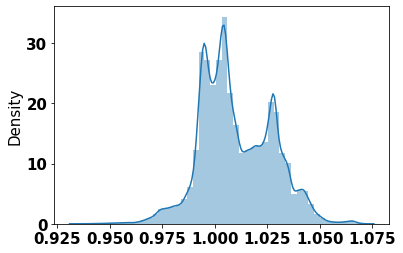

In [57]:
import seaborn as sns
sns.distplot(ratio[~np.isnan(ratio)])

In [58]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

[0 1 2]


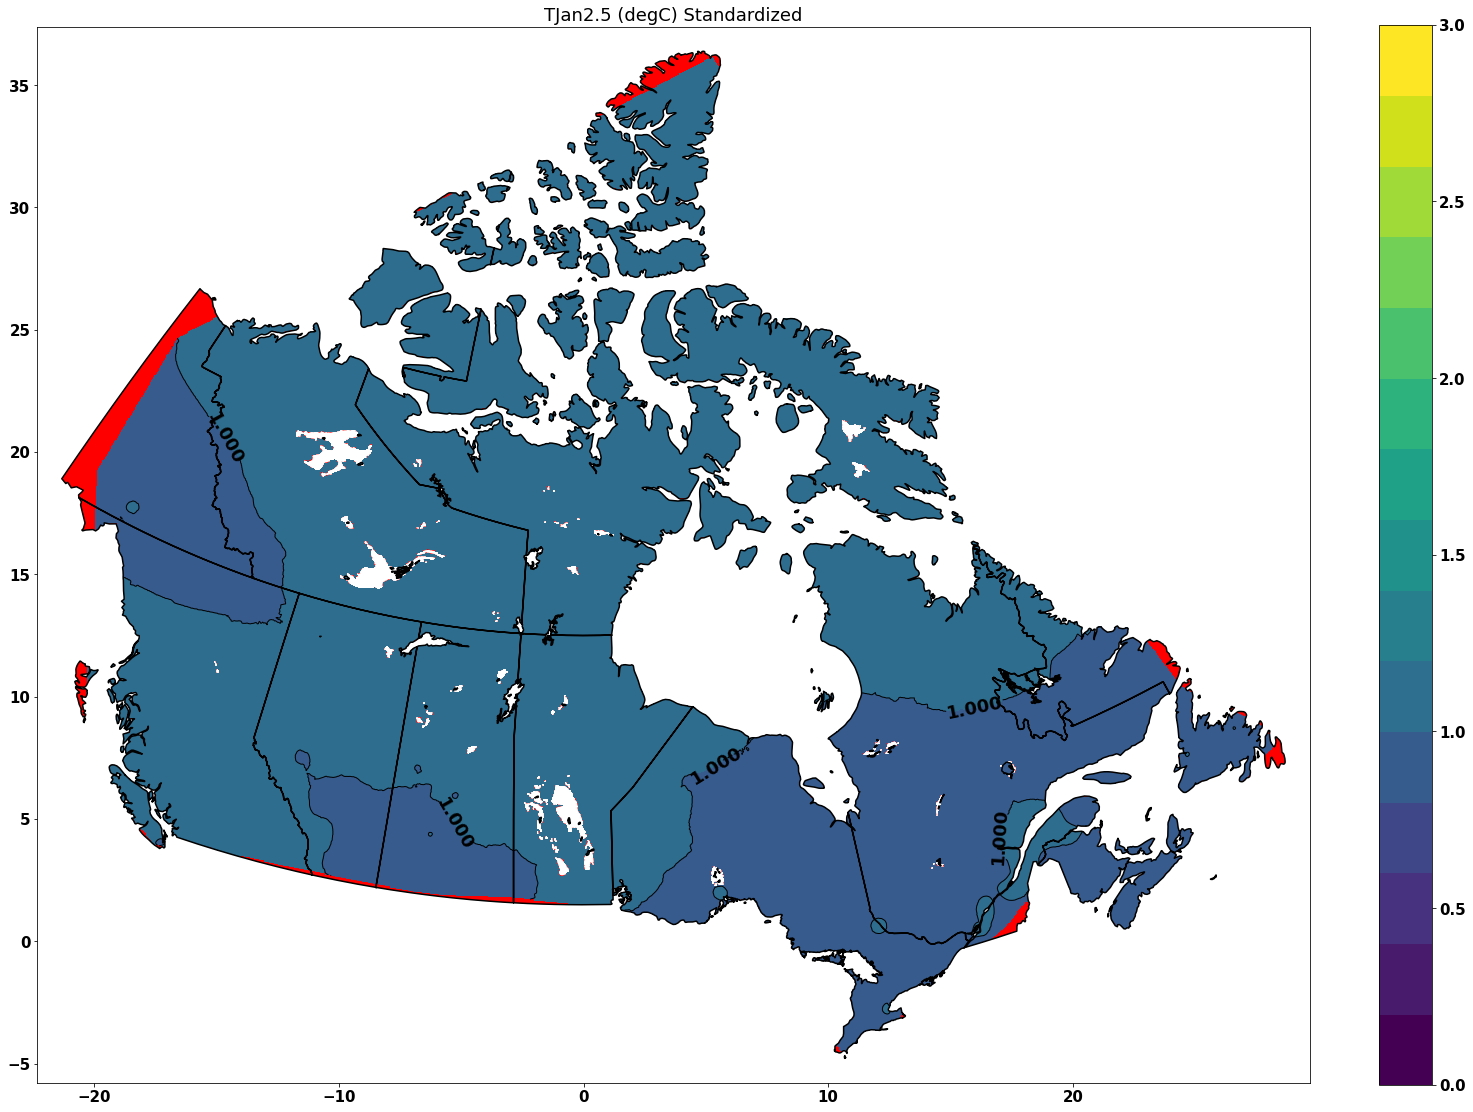

In [59]:
ratio = np.array(ratio, dtype=np.float)


fig, ax = plt.subplots(figsize=(25, 25))

# vmax = np.nanmax(df[station_dv].values)
# vmin = np.nanmin(df[station_dv].values)
# vmin = 5
vmin = 0
vmax = 3


N = 15
cont = np.arange(vmin, vmax, 1)
print(cont)

# ax.text(-20, -10, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)))
# ax.text(-20, -12, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)))
# # ax.text(-13, -12, 'Reconstruction Max: {}'.format(np.nanmax(ratio_final)))
# ax.text(-20, -14, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)))


# ax.text(1.5, -10, 'Station Min: {}'.format(np.round(np.min(df[station_dv]), 3)))
# ax.text(1.5, -12, 'Station Max: {}'.format(np.max(df[station_dv])))
# ax.text(1.5, -14, 'Station Mean: {}'.format(np.round(np.nanmean(df[station_dv]), 3)))

# ax.text(17, -10, 'Model Min: {}'.format(np.round(np.nanmin(ds[dv]), 3)))
# ax.text(17, -12, 'Model Max: {}'.format(np.round(np.nanmax(ds[dv]), 3)))
# ax.text(17, -14, 'Model Mean: {}'.format(np.round(np.nanmean(ds[dv]), 3)))

col1 = ax.imshow(ratio, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)
# ax.set_ylim(
# ax.set_xlim(canada[1].bounds[0]-3, canada[1].bounds[1]-4)
# ax.set_ylim(2, canada[1].bounds[3])

# ax.set_xlim(canada[1].geometry.bounds.minx.min()-5, canada[1].geometry.bounds.maxx.max()+5)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Standardized')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/standardized-{station_dv}-Z-full-reconstruction-patched.png')

In [60]:
nanmask = ~np.isnan(ratio)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
ratio_final = ratio.copy()

f = NearestNDInterpolator(np.stack([rlon[nanmask], rlat[nanmask]]).T, ratio[nanmask])

ratio_final[nanmask^mask] = f(np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T)
ratio_final = ratio_final*mean_corrected - 273.15
ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask] - 273.15
# ratio_final = ratio_final*np.nanstd(mean_corrected) + mean_corrected
# ratio_final = (-(ratio_final*np.sqrt(-(mean_corrected - 5.0)))**2)+5.0

In [61]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

[-50 -45 -40 -35 -30 -25 -20 -15 -10  -5   0]


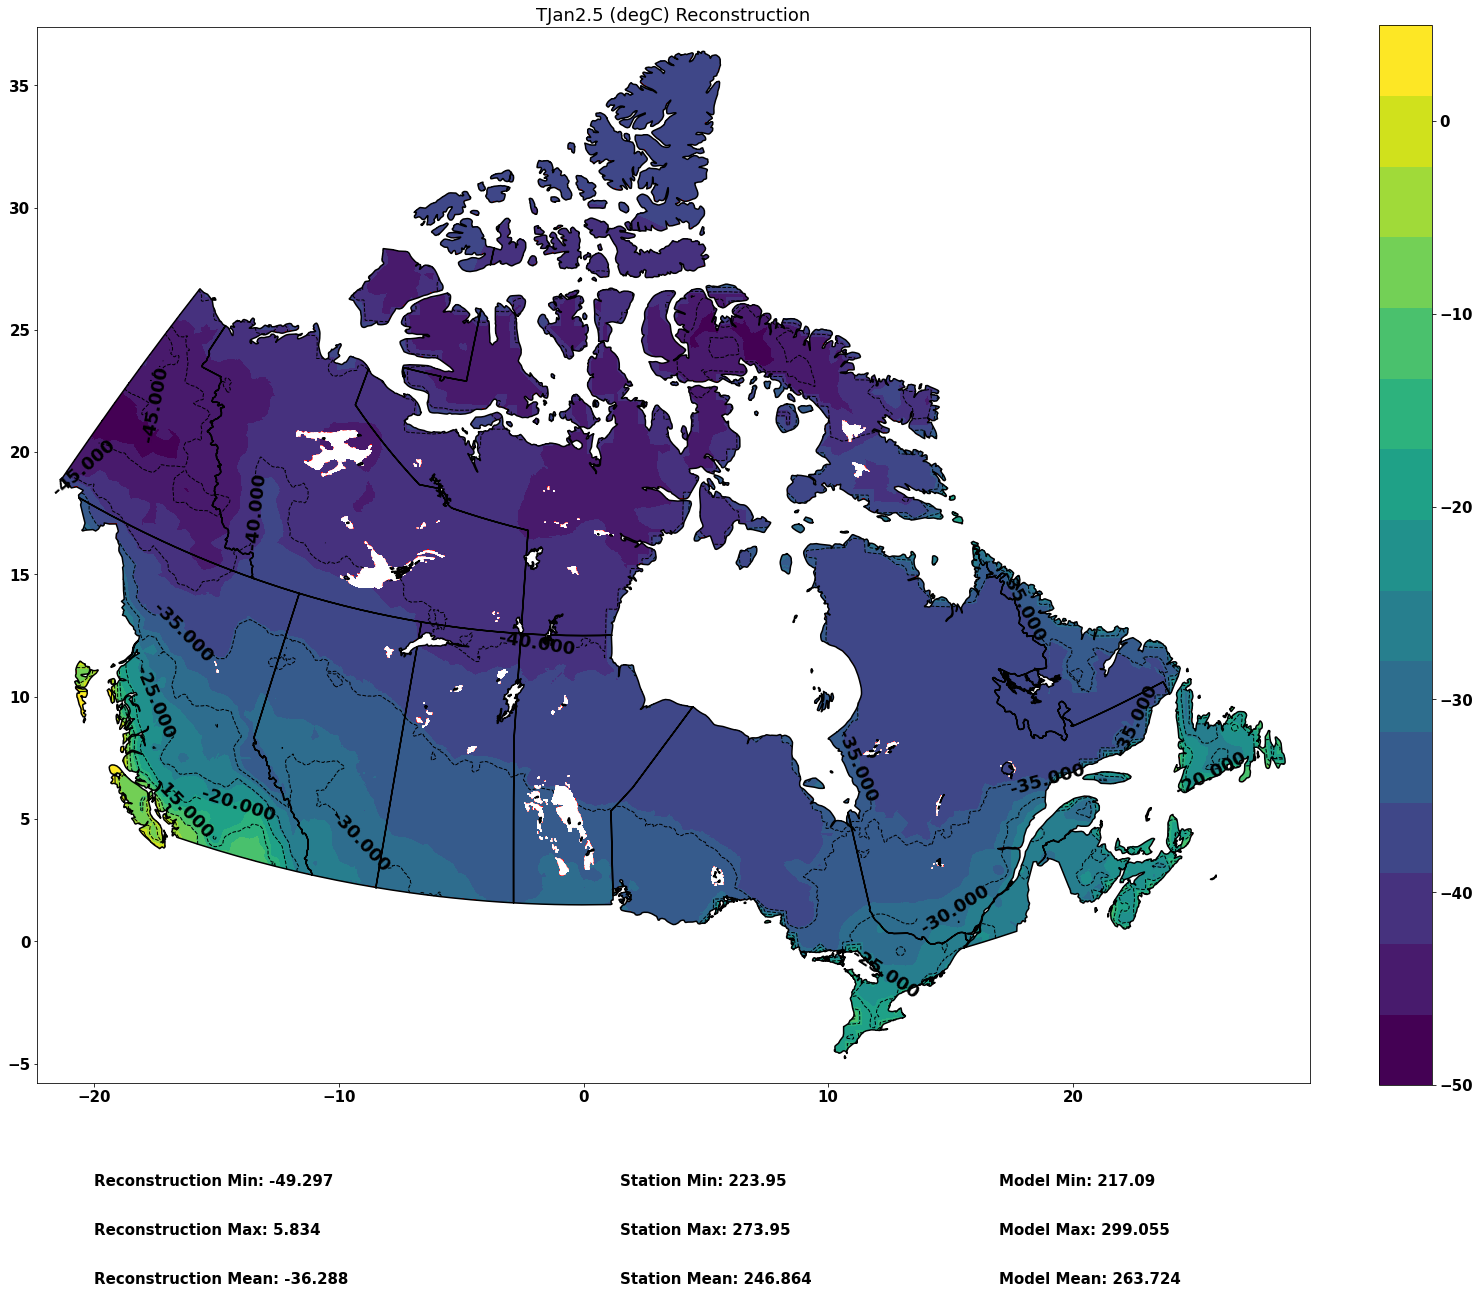

In [64]:
ratio_final[~mask] = np.nan

df = df.assign(station_dv = df[station_dv] - 273.15)


fig, ax = plt.subplots(figsize=(25, 25))

# vmax = np.nanmax(df[station_dv].values)
# vmin = np.nanmin(df[station_dv].values)
# vmin = 5
vmin = -50
vmax = 5


N = 15
cont = np.arange(vmin, vmax, 5)
print(cont)

ax.text(-20, -10, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)))
ax.text(-20, -12, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)))
# ax.text(-13, -12, 'Reconstruction Max: {}'.format(np.nanmax(ratio_final)))
ax.text(-20, -14, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)))


ax.text(1.5, -10, 'Station Min: {}'.format(np.round(np.min(df[station_dv]), 3)))
ax.text(1.5, -12, 'Station Max: {}'.format(np.max(df[station_dv])))
ax.text(1.5, -14, 'Station Mean: {}'.format(np.round(np.nanmean(df[station_dv]), 3)))

ax.text(17, -10, 'Model Min: {}'.format(np.round(np.nanmin(ds[dv]), 3)))
ax.text(17, -12, 'Model Max: {}'.format(np.round(np.nanmax(ds[dv]), 3)))
ax.text(17, -14, 'Model Mean: {}'.format(np.round(np.nanmean(ds[dv]), 3)))

col1 = ax.imshow(ratio_final, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio_final, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)
# ax.set_ylim(
# ax.set_xlim(canada[1].bounds[0]-3, canada[1].bounds[1]-4)
# ax.set_ylim(2, canada[1].bounds[3])

# ax.set_xlim(canada[1].geometry.bounds.minx.min()-5, canada[1].geometry.bounds.maxx.max()+5)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Reconstruction')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/standardized-{station_dv}-full-reconstruction-patched.pdf')

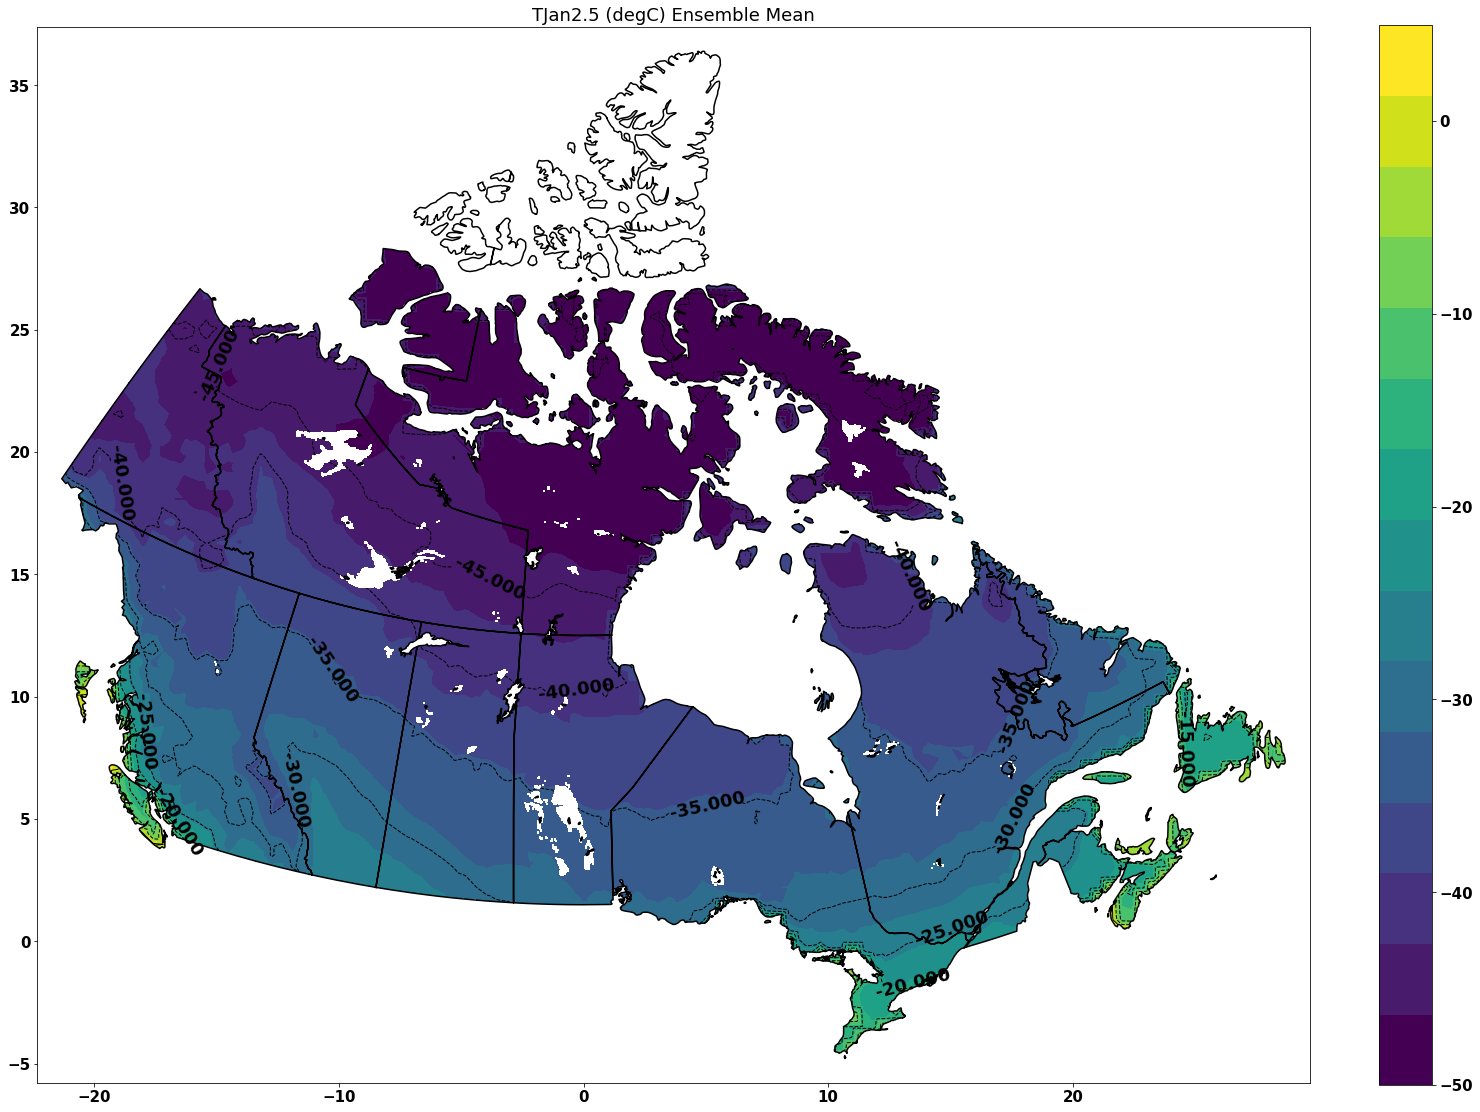

In [33]:
mean = ds[dv].values
mean[~mask] = np.nan
mean[northern_mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 25))



col1 = ax.imshow(mean, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, mean, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Ensemble Mean')
# canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{station_dv}-mean.png')

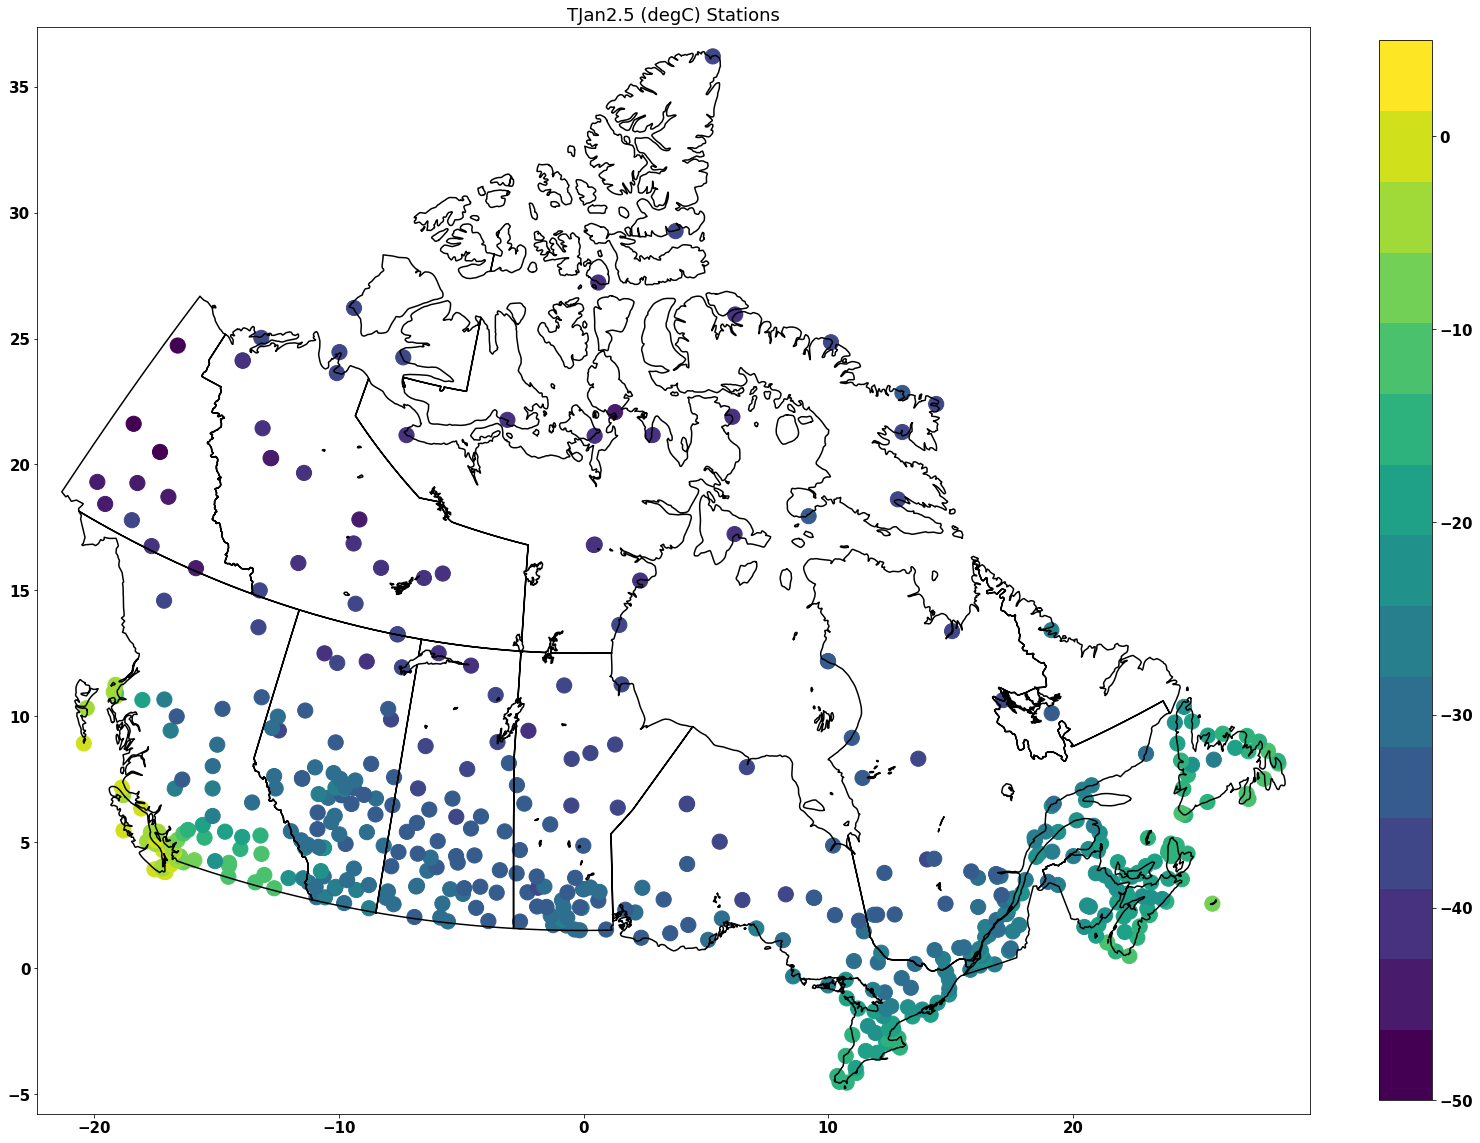

In [34]:
# ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
# ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 20))

sc = ax.scatter(df.rlon, df.rlat, c = df[station_dv], s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap("viridis", N))
plt.colorbar(sc, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.set_title(station_dv+' Stations')
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{station_dv}-stations.png')

# Write to Table C-2


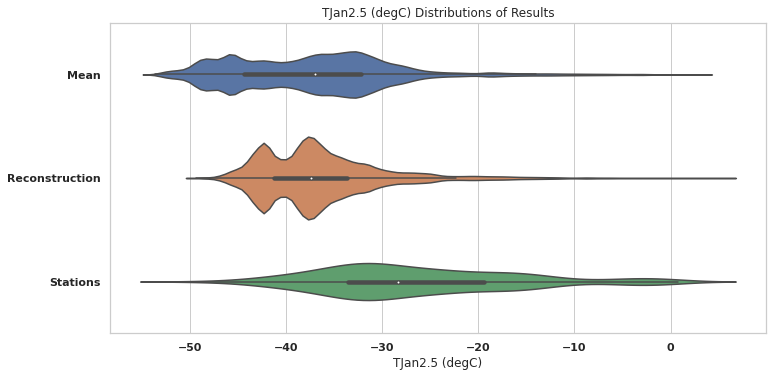

In [35]:
# sns.violinplot
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 5))

violindata = np.concatenate([ds[dv].values.flatten(), ratio_final.flatten(), station_vals])

means_str = ["Mean" for x in ds[dv].values.flatten()]
ratio_str = ["Reconstruction" for x in ratio_final.flatten()]
station_str = ["Stations" for x in station_vals]

vstrings = np.concatenate([means_str, ratio_str, station_str])

vdf = pd.DataFrame({station_dv: violindata, '': vstrings})
plt.tight_layout()

ax.set_title(f"{station_dv} Distributions of Results")
sns.violinplot(ax=ax, x=station_dv, y='', data=vdf)
plt.savefig(f'./data/plots/standardized-violin-{station_dv}-stations.png', bbox_inches='tight')

In [88]:
matched_df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

nrc_nan_df = matched_df_nrc[np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])]

ratio_nan = ~np.isnan(ratio_final)
    
f = NearestNDInterpolator(np.stack([rlon[ratio_nan], rlat[ratio_nan]]).T, ratio_final[ratio_nan])

table_nan = f(
    np.stack(
        [rlon[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values], 
         rlat[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values]
        ]).T).T

# matched_df_nrc[''][np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])] = table_nan
# matched_df_nrc

design_value = ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx]
dvnan = np.isnan(design_value)
design_value[dvnan] = table_nan

nrc_table = pd.DataFrame()
nrc_table = nrc_table.assign(
    Location=matched_df_nrc.Location, 
    lat=matched_df_nrc.lat, 
    lon=matched_df_nrc.lon,
    rlat=matched_df_nrc.rlat, 
    rlon=matched_df_nrc.rlon,
    SL50=design_value)

assert not df.isnull().values.any()

nrc_table.round(3).to_csv("./data/processed/table_c2_"+dv+".csv")